# Import necessary package

In [3]:
import warnings
from collections import OrderedDict
import pandas as pd

import scipy
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.utils import resample
import pysindy as ps
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.metrics import mean_squared_error
from scipy.integrate import odeint
from scipy.stats import multivariate_normal
# import seaborn as sns



from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

import matplotlib
matplotlib.rcParams.update({'font.size': 14})

from sklearn.metrics import mean_squared_error
# mean_squared_error(obs_height, pred_param_height[k2], squared = False)

In [5]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

def set_publcn_matplotlib_defaults():
    """
    Set default configurations for Matplotlib plots suitable for publication.
    This includes setting the font to Times New Roman and adjusting the font size.

    # Call this function at the beginning of your notebook to apply the settings
    set_matplotlib_defaults()
    
    # Example plot to demonstrate the settings
    import numpy as np
    
    t = np.arange(0, 2, 0.01)
    s = 1 + np.sin(2 * np.pi * t)
    
    # Global settings plot
    plt.figure()
    plt.plot(t, s)
    plt.title('Global Settings Plot')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()
    
    # Override figure size and font size locally for this plot
    plt.figure(figsize=(10, 5))  # Override figure size
    plt.plot(t, s)
    plt.title('Custom Figure Size and Font Size Plot', fontsize=18)  # Override title font size
    plt.xlabel('Time (s)', fontsize=14)  # Override x-axis label font size
    plt.ylabel('Amplitude', fontsize=14)  # Override y-axis label font size
    plt.xticks(fontsize=12)  # Override x-axis tick labels font size
    plt.yticks(fontsize=12)  # Override y-axis tick labels font size
    plt.show()
    """
    # plt.style.use('seaborn-whitegrid')  # Optional: You can choose a different style or remove this line.
    
    rcParams.update({
        'font.family': 'serif',
        'font.serif': 'Times New Roman',
        'font.size': 12,             # General font size
        'axes.titlesize': 14,        # Font size for axes title
        'axes.labelsize': 12,        # Font size for axes labels
        'xtick.labelsize': 10,       # Font size for x-axis tick labels
        'ytick.labelsize': 10,       # Font size for y-axis tick labels
        'legend.fontsize': 10,       # Font size for legend
        'figure.titlesize': 16,      # Font size for figure title
        'lines.linewidth': 1.5,      # Line width
        'lines.markersize': 6,       # Marker size
        'figure.dpi': 300,           # Figure DPI for high-resolution images
        'savefig.dpi': 300,          # DPI for saving figures
        'savefig.format': 'png',     # Default format for saving figures
        'text.usetex': False,        # Use TeX for rendering text (False is usually better for compatibility)
    })
set_publcn_matplotlib_defaults()

In [6]:
## Upsampling Function
def resample_data(data, scale = int(200/35)):
    """Code function to either upsample or downsample a dataset depending on the factor"""
    
    def upsample(original_data, factor = 2):
        # Upsampling factor
        upsampling_factor = factor

        # Calculate new number of samples
        new_num_samples = len(original_data) * upsampling_factor

        # Generate new indices for the upsampled data
        new_indices = np.linspace(0, len(original_data) - 1, new_num_samples)

        # Upsample the data
        upsampled_data = np.interp(new_indices, np.arange(len(original_data)), original_data)
        return upsampled_data
    
    
    sz = data.shape
    
    if len(sz) < 2:
        upsampled_data = upsample(data.reshape(-1),scale)
        return upsampled_data
        
    else:
        Data = []
        for i in range(sz[-1]):
            data_i = data[:,i].reshape(-1)
            upsampled_i = upsample(data_i, scale)
            Data.append(upsampled_i)
        Data = np.asarray(Data).T
        return Data

In [7]:
class My_STLSQ:
    def __init__(self, threshold=0.05, fit_intcpt = True):
        self.threshold = threshold
        self.fit_intcpt = fit_intcpt  
                

    def fit(self, True_X, y):
        """
        Perform least squares regression with LASSO regularization
        Parameters:
        -----------
        True_X : numpy array
            Feature matrix of shape (n_samples, n_features)
        y : numpy array
            Response vector of shape (n_samples,)
        self.threshold : float
            LASSO regularization parameter

        Returns:
        --------
        coef : numpy array
            Coefficient vector of the final model
        """

        if self.fit_intcpt:
            # Add a bias term to the input data
            X_ = np.insert(True_X, 0, 1, axis=1)
        else: X_ = np.copy(True_X)

        if len(y.shape) == 1:
            y = y.reshape(-1,1)
            
        n_features = X_.shape[1]
        self.Coeffs = []
        for i in range(y.shape[-1]):
#             print(i)
            X = np.copy(X_)
            y_i = y[:,i] #.reshape(-1)
#             print(y_i.shape)
            model = LinearRegression()
            coef = np.zeros(n_features)
            while True:
                model.fit(X, y_i)
                coef_new = model.coef_
                if np.max(np.abs(coef_new - coef)) < 1e-5:
                    break
                coef = coef_new
                small_coef = np.abs(coef) < self.threshold
                if np.sum(small_coef) == 0:
                    break
                X = X[:, ~small_coef]
                coef = coef[~small_coef]
            indx = find_indexes(X_[0],X[0])
            coefficient = np.zeros(n_features)
            coefficient[indx] = coef
            self.Coeffs.append(coefficient)
        return np.array(self.Coeffs)

    def predict(self, X):
        if self.fit_intcpt:
            # Add a bias term to the input data
            X = np.insert(X, 0, 1, axis=1)
        beta = np.array(self.Coeffs)
        
        if len(beta.shape) == 1:
            beta = beta.reshape(-1,1)
            
        Y_pred = np.dot(X,beta.T)
        return np.array(Y_pred)

    
    
class SequentialThresholdLeastSquares:
    def __init__(self, threshold=0.05, fit_intcpt = False):
        self.threshold = threshold*10
        self.fit_intcpt = fit_intcpt  
                
    
    def fit(self, X, y, ):        
        if self.fit_intcpt:
            # Add a bias term to the input data
            X = np.insert(X, 0, 1, axis=1) 
        if len(y.shape) == 1:
            y = y.reshape(-1,1)
        
        self.Beta = [] #np.zeroes(y.shape[-1],X.shape[-1])
        for t in range(y.shape[-1]):
            yt = y[:,t]
            # Initialize the parameter vector
            self.beta = np.zeros(X.shape[1])

            # Compute the initial residual and RSS
            r = yt - np.dot(X, self.beta)
            RSS = np.sum(r**2)

            # Iterate until convergence
            while True:
                # Compute the correlation coefficients
                corr = np.abs(np.dot(X.T, r))

                # Find the feature with the highest correlation
                j_star = np.argmax(corr)

                # Check if the highest correlation is above the threshold
                if corr[j_star] > self.threshold:
                    # Compute the new parameter estimate for feature j_star
                    beta_j_star = np.dot(X[:,j_star], r) / np.dot(X[:,j_star], X[:,j_star])

                    # Update the parameter vector and residual
                    self.beta[j_star] += beta_j_star
                    r -= beta_j_star * X[:,j_star]
                    RSS = np.sum(r**2)
                else:
                    break
            self.Beta.append(self.beta)
        return np.array(self.Beta)
    
    def predict(self, X):
        if self.fit_intcpt:
            # Add a bias term to the input data
            X = np.insert(X, 0, 1, axis=1)
        beta = np.array(self.Beta)
        
        if len(beta.shape) == 1:
            beta = beta.reshape(-1,1)
            
        Y_pred = np.dot(X,beta.T)
        return np.array(Y_pred)

#Linear regression function
def LR(X, y,alpha, n_features):
    model = LinearRegression()
    coef = np.zeros(n_features)
    while True:
        model.fit(X, y)
        coef_new = model.coef_
        if np.max(np.abs(coef_new - coef)) < 1e-5:
            break
        coef = coef_new
        small_coef = np.abs(coef) < self.threshold
        if np.sum(small_coef) == 0:
            break
        X = X[:, ~small_coef]
        coef = coef[~small_coef]
    return X,coef

# Function to find the indices of several element in an array
def find_indexes(array, elements):
    if type(array) != list:
        array = array.tolist()
        
    elements = np.array(elements)
    indexes = []
    for element in elements:
        try:
            index = array.index(element)
            indexes.append(index)
        except ValueError:
            indexes.append(None)
    return indexes

In [8]:
def plot_multivariate_normal(data, xlabel='x', ylabel='y', title='Multivariate Normal Distribution'):
    # Compute the mean and covariance of the data
    mean = np.mean(data, axis=0)
    cov = np.cov(data.T)

    # Create a grid of points for the x and y axes
    x, y = np.mgrid[mean[0]-3*np.sqrt(cov[0,0]):mean[0]+3*np.sqrt(cov[0,0]):100j,
                    mean[1]-3*np.sqrt(cov[1,1]):mean[1]+3*np.sqrt(cov[1,1]):100j]

    # Create a multivariate normal distribution using the mean and covariance
    mvn = multivariate_normal(mean=mean, cov=cov)

    # Evaluate the PDF of the multivariate normal distribution at each point on the grid
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y
    pdf = mvn.pdf(pos)
    
    # Set the plot title and axis labels
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Plot the multivariate normal distribution as a contour plot
    ax.contourf(x, y, pdf)
    # Show the plot
    plt.show()

In [9]:
def SINDY(noisy_data, t, threshold = 0.03, wl = 15, condit = False): #wl = window length for smoothening
    """Fits SINDy model to a data and returns the resulting coefficients"""
    Poly_lib = ps.PolynomialLibrary(degree=2, include_interaction=True, include_bias=True)
    optimizer = ps.STLSQ(threshold)
    smoothed_fd = ps.SmoothedFiniteDifference(order=2, smoother_kws={'window_length': wl})
    dldt = smoothed_fd(noisy_data,t)
    L_dl = np.vstack((noisy_data,dldt)).T

    model = ps.SINDy(
        differentiation_method=smoothed_fd,
        feature_library=Poly_lib,
        optimizer=optimizer,
        feature_names=["L", "dL"] 
    )
    if condit: 
        model.fit(L_dl, t)
        model.print()
        model.get_feature_names()
        return model.coefficients()#.reshape(-1)
    
    else:
        model.fit(L_dl, t)
        return L_dl, model
        

def sort_matrix(matrix, col_idx = -1):
    """Sorts the element of a matrix by a predifine column in ascending order"""
    if len(matrix.shape)  == 1:
        matrix= matrix.reshape(-1,1)
    # Sort the matrix by the specified column
    sorted_matrix = sorted(matrix, key=lambda x: x[col_idx])
    return np.array(sorted_matrix)


def split_matrix(matrix):
    """Splits the last column of a matrix from the original matrix and returns the new matrix and the column"""
    matrix = matrix.tolist()
    # Split the last column from the matrix
    last_column = [row.pop() for row in matrix]
    return np.array(matrix),np.array(last_column)

def min_idx(arr1,arr2):
    """Finds the minimum of arr2 and return the corresponding arr1 values with it """
#     arr2 = arr2.tolist()
    min_value = min(arr2)
    min_index = arr2.index(min_value)
    return ([arr1[min_index],min_value])

def differentiate(data, time, wl=15):
    smoothed_fd = ps.SmoothedFiniteDifference(order=2, smoother_kws={'window_length': wl})
    dldt = smoothed_fd(data,time)
    d2ldt = smoothed_fd(dldt, time)
    d3ldt = smoothed_fd(d2ldt, time)
    return dldt,d2ldt,d3ldt

In [10]:
### Simulating Functions
def simulate_true_model(parameters, initial_vals, simu_time):
    '''
    Function to simulate the model given known parameters
    Parameters contains: density,viscosity,permeability,gravity, and capillary_pressure in that order.
    Function returns the simulated data
    '''
    from scipy.integrate import odeint
    density,viscosity,permeability,gravity, capillary_pressure = parameters
    l0,v0 = initial_vals
    
    alpha = density*gravity
    beta  = viscosity/permeability
    gamma = density
    delta = density
    
    def infiltration_model(t, S):
        Pc = capillary_pressure
        l, v = S
        dv =  (-1/(gamma*l)) * (alpha*l + beta*l*v + delta*v**2 - Pc)
        return [v,dv]
    
    Simulated = odeint(infiltration_model, y0=initial_vals, t= simu_time,  tfirst = True).T
    return Simulated    

# Simulate recovered model with extra term l^2
def simulate_recovered_model(parameters, initial_vals, simu_time, Pc):
    from scipy.integrate import odeint
    alpha, beta, delta, gamma, mu = parameters
    l0,v0 = initial_vals    
    def infiltration_model(t, S):
        l, v = S
        dv =  (-1/(gamma*l)) * (alpha*l + beta*l*v + delta*v**2 + mu*l**2 - Pc)
        return [v,dv]
    
    Simulated = odeint(infiltration_model, y0=initial_vals, t= simu_time,  tfirst = True).T
    return Simulated    

### Dr Han's Infiltration Data

In [12]:
inf_data = pd.read_csv("Infiltration.csv") #Load data from csv file
digitized = pd.read_csv("Wigly.csv")

obs_time = np.asarray(inf_data["Time (s)"]) #Extract time to 
obs_height = np.asarray(inf_data["Height (mm)"])/1000

Pc = 184.93   #Capillary pressure
t = np.copy(obs_time)
x = np.copy(obs_height)

# a,b = x[0],x[1]
# a,b = b,a
# x[0],x[1] = a,b 

# differentiate data to get dl/dt, d2l/dt2 and d3l/dt3
dl,d2l, _ = differentiate(obs_height,obs_time)
initial_vals = np.array([x[0], dl[0]])

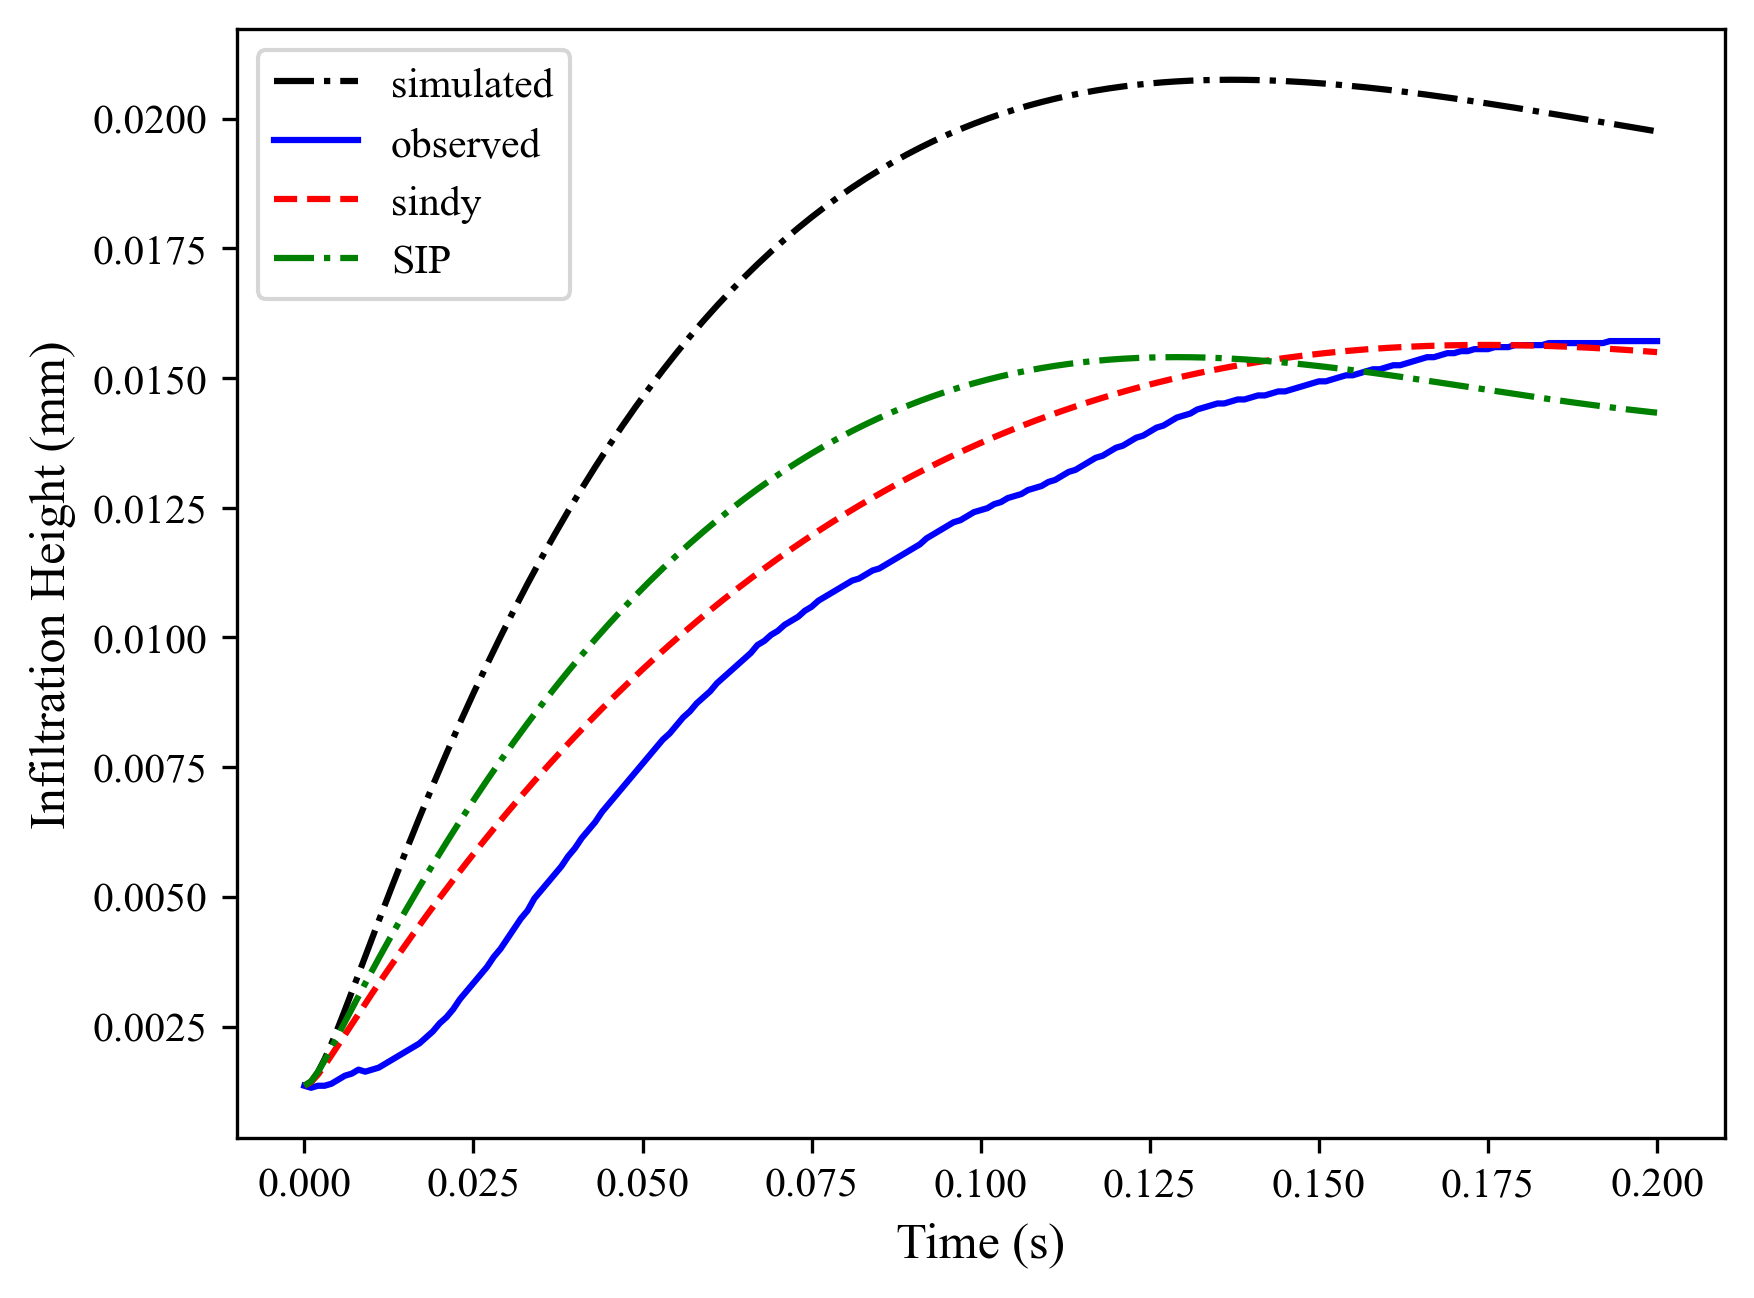

In [13]:
Han_params = np.array([997.77, 8.9e-4, 3.78e-8, 9.81, 184.93])
Han_init = initial_vals
Han_time = obs_time
extend_time = np.linspace(0,0.8, 201)

#Simulate True model
Han_simulated = simulate_true_model(Han_params, Han_init, obs_time)
Han_L_sim = Han_simulated[0]
Han_dL_sim = Han_simulated[1]

# Simulating for recovered parameters
SINDy_parameter = [1.62e4, 1.60e4, 3.53e3, 1.09e3, -2.45e5]
SIP_parameter = [1.28e4, 1.93e4, 2.26e3, 0.86e3, 0]

SINDy_L = simulate_recovered_model(SINDy_parameter, initial_vals, obs_time, Pc = 184.93)[0]
SIP_L = simulate_recovered_model(SIP_parameter, initial_vals, obs_time, Pc = 184.93)[0]

#Plot the models
plt.plot(obs_time, Han_L_sim, 'k-.', label = "simulated")
plt.plot(obs_time, obs_height, 'b', label = "observed")
plt.plot(obs_time, SINDy_L, 'r--', label = "sindy")
plt.plot(obs_time, SIP_L, 'g-.', label = "SIP")


plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Infiltration Height (mm)')
plt.show()

### Digitized data from paper

In [24]:
def get_theta(jurin_height, density, gravity, radius, surface_tension):
    theta_tmp = (jurin_height*density*gravity*radius)/(2*surface_tension)
    
#     print(theta_tmp)
    
    if theta_tmp>1:
        theta_tmp = 0.999
#         if 1/theta_tmp<0.9:
#             theta_tmp = 0.999
#         else:
#             theta_tmp = 1/theta_tmp
    return np.arccos(theta_tmp)*180/np.pi

def get_PC(surface_tension, theta, radius):
    return 2*surface_tension*(np.cos(theta*np.pi/180))/radius

In [26]:
# Digitized parameters
viscosity = 0.3*1e-3 #0.5  #Pa.s
g = 9.81 #m/s
density =  710  #980 #kg/m3
radius = 689 * 1e-6 #421 * 10**(-6) #m
jurin_height  = 7.1 * 1e-3 #10.4 * 10**(-3) #m 
surface_tension = 16.6 * 1e-3 #21.1 * 10**(-3) #N/m
theta = get_theta(jurin_height, density, g, radius, surface_tension)
capillary_pressure =  get_PC(surface_tension, theta, radius) # #jurin_height*density*g/ (np.cos(theta*0.5*np.pi/90)) #Pa
permeability = radius**2/8 #R^2/8

print(f"Permeability = {permeability}")
print(f"capillary pressure = {capillary_pressure}")
# print(f"{theta}")

Permeability = 5.934012499999999e-08
capillary pressure = 48.137590711175626


In [28]:
#Load data
dig_height = np.asarray(digitized["Height (mm)"])/1000
dig_tym = np.asarray(digitized["Time (s)"]) #the time data represents square root of time
dig_time = dig_tym*1e-3

# Original data
original_data = np.vstack((dig_time, dig_height, dig_tym)).T

#Resample data and make plot
Upsampled_digitized = resample_data(original_data, scale=6) #upsampled digitized data
d_time, d_height, d_tym = Upsampled_digitized[:,0], Upsampled_digitized[:,1], Upsampled_digitized[:,2] #copying 
d_height[0] = 0.000001

t_dgt = np.copy(d_time)
x_dgt = np.copy(d_height)

Pc = capillary_pressure  #Capillary pressure

# differentiate data to get dl/dt, d2l/dt2 and d3l/dt3
dl_dgt,d2l_dgt, _ = differentiate(d_height, d_time, 15)

#sindy_data
dgt_sindy_data = np.vstack((x_dgt, dl_dgt)).T

initial values = [1.00000000e-06 2.83537777e-01]
Mean Squared Error = 0.0007441205186106433


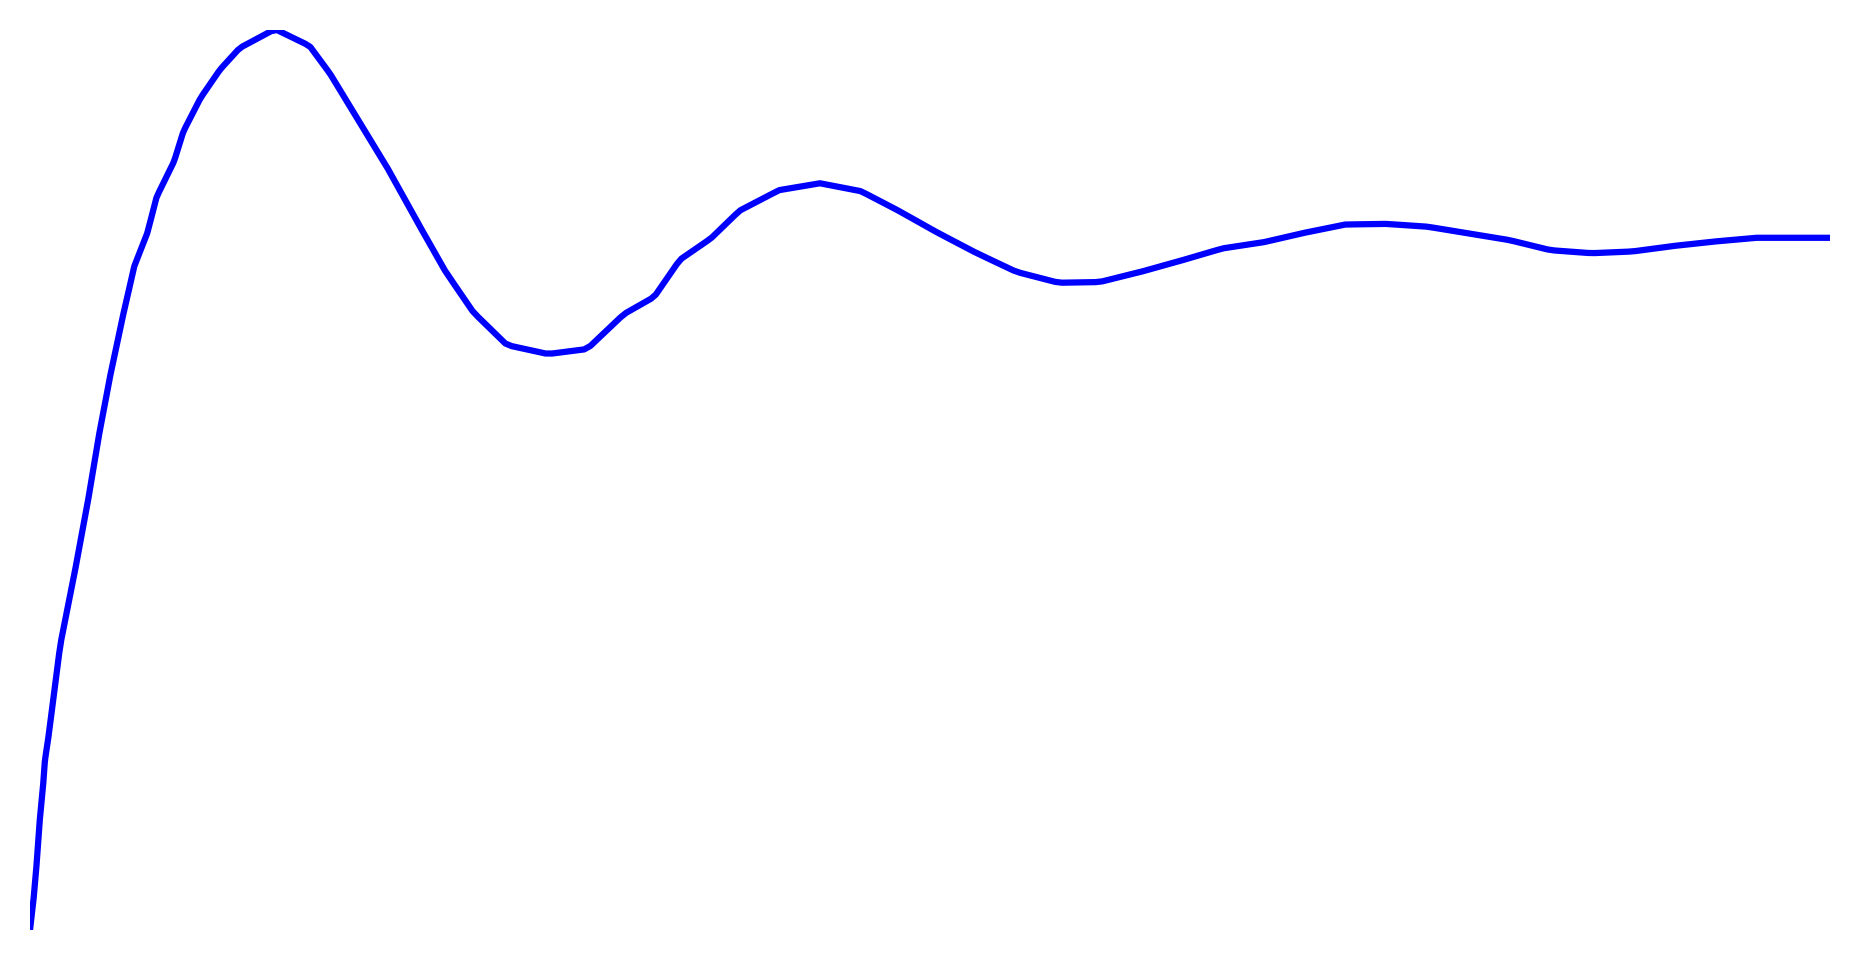

In [30]:
#Initial values and parameters of the digitized data
initial_vals_dgt = np.array([d_height[0], dl_dgt[0]])
digit_params = [density, viscosity, permeability, g, capillary_pressure]

simulated_digit = simulate_true_model(digit_params, initial_vals_dgt, d_time)
simulated_L = simulated_digit[0]
simulated_dL = simulated_digit[1]

#print parameter values
print(f"initial values = {initial_vals_dgt}")
print(f"Mean Squared Error = {mean_squared_error(d_height, simulated_L, squared = False)}")

#plot data
plt.figure(figsize= (6,3))
# plt.plot(d_time, simulated_L, 'r-.', label = "simulated")
plt.plot(d_time,d_height*1000,'b', label = "low viscous") #digitized

# # plt.legend()
# plt.xlabel('Time (s)', fontsize=28)
# plt.ylabel('Infiltration Height (mm)', fontsize=28)
# plt.xticks( fontsize=26, rotation=0) #rotation=45,
# plt.yticks(fontsize=26)
# # Adjust layout to ensure everything is visible
# plt.tight_layout()
# plt.legend(fontsize=22)
# plt.show()

# Remove axis ticks and labels
plt.axis('off')

# Optional: remove padding
plt.margins(0)
plt.tight_layout(pad=0)

plt.show()



# plt.legend()
# plt.xlabel('Time (s)')
# plt.ylabel('Infiltration Height (m)')
# plt.show()

### Normal SINDy Learning

In [33]:
def SINDY_(noisy_data,t, threshold = 0.03, wl = 15, condit = False):
    """Fits SINDy model to a data and returns the resulting coefficients"""
    Poly_lib = ps.PolynomialLibrary(degree=2, include_interaction=True, include_bias=True)
    optimizer = ps.STLSQ(threshold)#threshold = 0.3)
    smoothed_fd = ps.SmoothedFiniteDifference(order=2, smoother_kws={'window_length': wl})
#     dldt = smoothed_fd(noisy_data,t)
#     L_dl = np.vstack((noisy_data,dldt)).T

    model = ps.SINDy(
        differentiation_method=smoothed_fd,
        feature_library=Poly_lib,
        optimizer=optimizer,
        feature_names=["l", "v"] 
    )
    if condit: 
        model.fit(noisy_data, t)
        model.print()
        model.get_feature_names()
        return model.coefficients()#.reshape(-1)
    
    else:
        model.fit(noisy_data, t)
        return model

(l)' = 1.000 v
(v)' = -195.995 1 + 47438.337 l + 1278.769 v + -2780356.083 l^2 + -163964.739 l v + -1919.094 v^2
Mean Squared Error = 0.002284500486496024


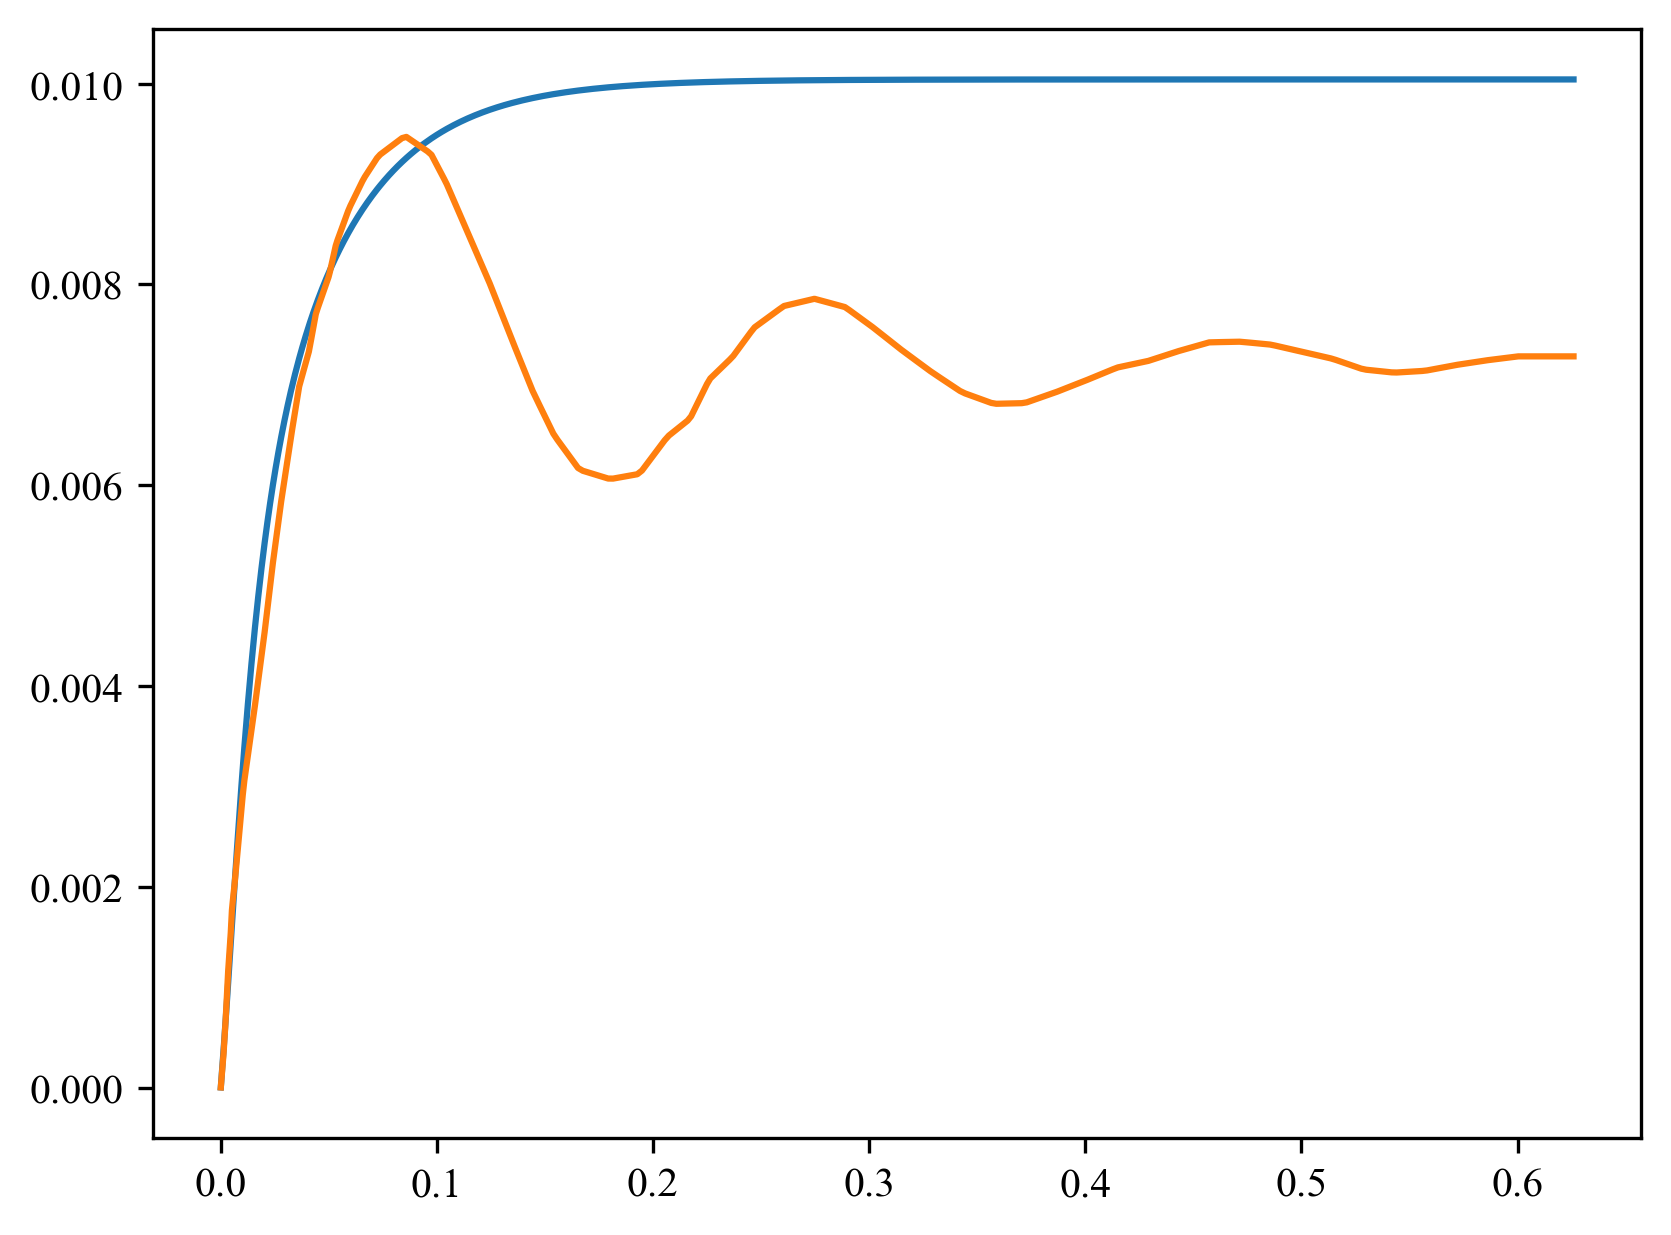

In [35]:
# differentiate data to get dl/dt, d2l/dt2 and d3l/dt3
wdl = 15

dl_dgt,d2l_dgt, _ = differentiate(d_height, d_time, wdl)

#sindy_data
dgt_sindy_data = np.vstack((x_dgt, dl_dgt)).T

sdmodel = SINDY_(dgt_sindy_data, d_time, 0.01, wl = wdl)
sdmodel.print()
sdmodel.coefficients()
sindy_sim = sdmodel.simulate(initial_vals_dgt, d_time)

print(f"Mean Squared Error = {mean_squared_error(d_height, sindy_sim[:,0], squared = False)}")

plt.plot(d_time, sindy_sim[:,0])
plt.plot(d_time, dgt_sindy_data[:,0])
plt.show()

# Learning the model using Digitized data

In [99]:
# Helper Functions
def sample_and_extrapolate(array, time_array, num_samples):
    # Remove first and last row of the array and the corresponding time
    f_arr,l_arr = array[0],array[-1]
    f_time,l_time = time_array[0], time_array[-1]
    
    array_,time_array_ = np.copy(array),np.copy(time_array)
    
    array = array[1:-1]
    time_array = time_array[1:-1]
    
    # Randomly sample from the remaining array based on num_samples
    sampled_indices = sort_matrix(np.random.choice(len(array), size=num_samples, replace=False)).reshape(-1)
    sampled_array = array[sampled_indices]
    sampled_time = time_array[sampled_indices]
    
    # Add previously removed first and last row back to the array
    sampled_array = np.concatenate(([f_arr], sampled_array, [l_arr]))
    sampled_time = np.concatenate(([f_time], sampled_time, [l_time]))
    
    
    # Extrapolate for all time in the time array
    interpolated_array = np.interp(time_array_, sampled_time , sampled_array)
    return interpolated_array

def sort_matrix(matrix, col_idx = -1):
    """Sorts a matrix by a predifine column in ascending order"""
    if len(matrix.shape)  == 1:
        matrix= matrix.reshape(-1,1)
    # Sort the matrix by the specified column
    sorted_matrix = sorted(matrix, key=lambda x: x[col_idx])
    return np.array(sorted_matrix)


def split_matrix(matrix):
    """Splits the last column of a matrix from the original matrix and returns the new matrix and the column"""
    matrix = matrix.tolist()
    # Split the last column from the matrix
    last_column = [row.pop() for row in matrix]
    return np.array(matrix),np.array(last_column)

def min_idx(arr1,arr2):
    """Finds the minimum of arr2 and return the corresponding arr1 values with it """
#     arr2 = arr2.tolist()
    min_value = min(arr2)
    min_index = arr2.index(min_value)
    return ([arr1[min_index],min_value])

# x_xtrap = sample_and_extrapolate(x,t,int(0.8*len(x)))

# STLSQ function for model learning
def Learn_Model(X,y, thresh=0.01):
    sindy_model = SequentialThresholdLeastSquares(threshold=thresh, fit_intcpt = False)
    params = sindy_model.fit(X,y).reshape(-1)
    return params

#### Specify Library Function to use

In [103]:
def Library(obs_height, obs_time, wl=wdl, basic= False):
    #differentiate data
    dl,d2l,d3l = differentiate(obs_height, obs_time, wl) 
    
    ones = np.ones(len(obs_height))
    l = obs_height 
    lsq = l**2
    ldl = l*dl    
    ldsql = l*d2l
    dlsq = dl**2
    Lib1 = np.vstack((l, ldl, dlsq,  ldsql, lsq)).T # Stack data to get matrix
    Lib2 = np.vstack((l, ldl, dlsq,  ldsql)).T # Basic library containing only necessary terms
    if basic:
        return Lib2
    else: 
        return Lib1
    
# (alpha*l + beta*l*v + delta*v**2 + mu*l**2 - Pc)

In [105]:
# Specify library labels    
Complete_labels =  ['l',  'l*dl/dt', '(dl/dt)^2', 'l*d^2l/dt^2', 'l^2']
Basic_labels = ['l',  'l*dl/dt', '(dl/dt)^2', 'l*d^2l/dt^2']

#Generate library data
Complete_library = Library(d_height, d_time)
Basic_library = Library(d_height,d_time, basic = True)

#Create Response vector y = Pc
y = np.ones(len(d_time))*capillary_pressure

num_params = Complete_library.shape[-1] #number of parameters

Basic SINDy:  [6377.41291299 3650.57977514  302.72800029   22.05607908    0.        ] 
 Digitized parameter:  [6965.1, 5055.601079370831, 710, 710, 0] 
 Complete SINDy:  [ 8.37733979e+03  2.48068869e+03  2.89496797e+02  1.90329651e+01
 -2.63511884e+05] 

RMSE SINDy = 0.0011597052191259466
RMSE Simulated = 0.0
RMSE Basic SINDy = 0.0011728708374831127


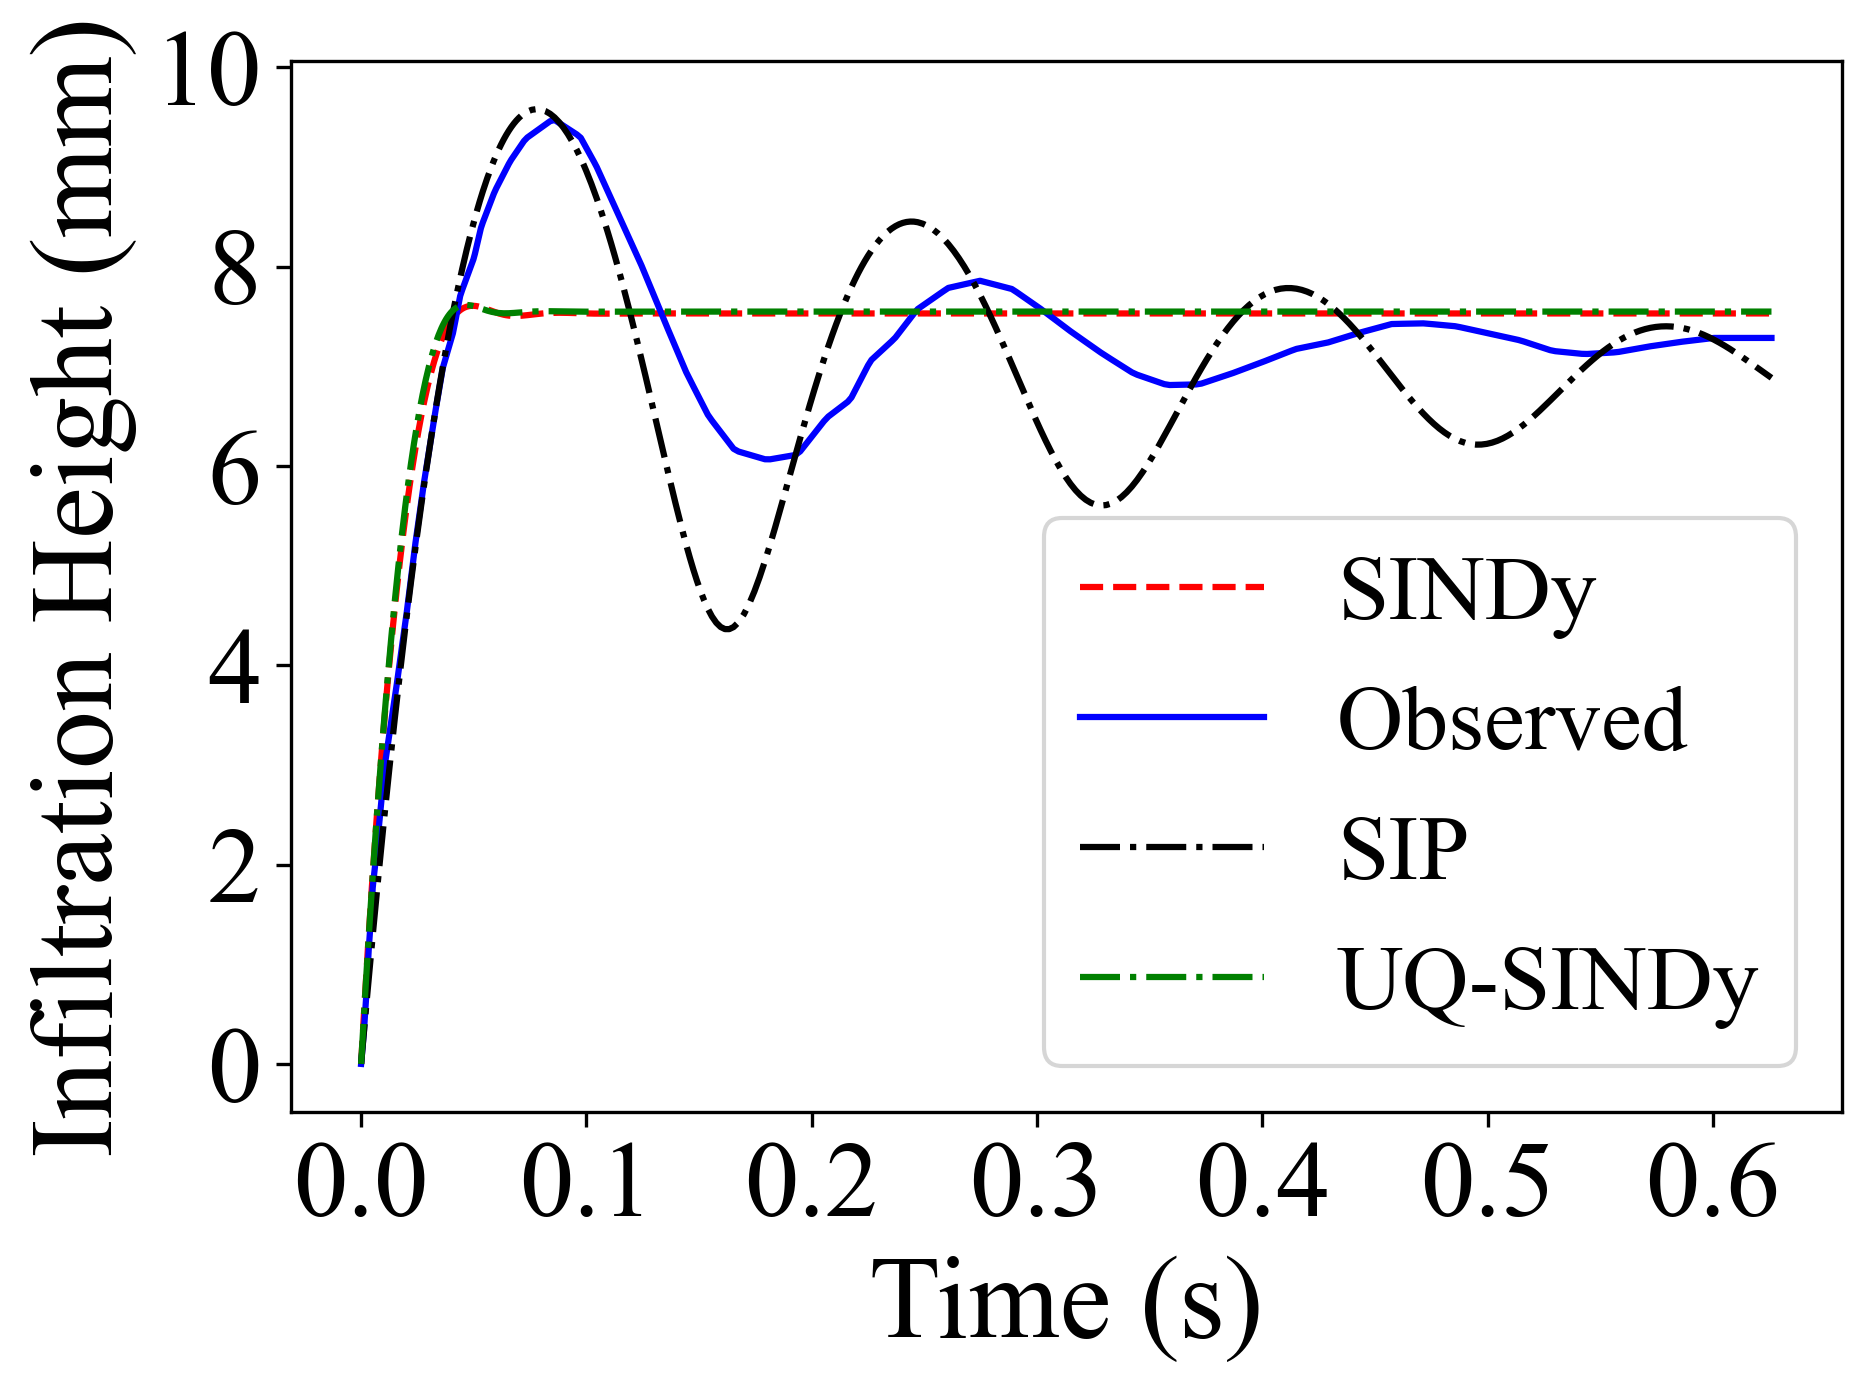

0.0007504542446543497


In [111]:
#digit parameter
alpha = density*g
beta  = viscosity/permeability
gamma = density
delta = density

dig_params = [alpha, beta, gamma, delta, 0]

# Sindy using basic library
basic_sindy_params = Learn_Model(Basic_library,y, thresh=0.002) #Basic Library
basic_sindy_params = np.append(basic_sindy_params, 0)
#simulate sindy recovered basic
bsc_sindy = simulate_recovered_model(basic_sindy_params, initial_vals_dgt, d_time, Pc = capillary_pressure)[0]

#Sindy using complete library
complete_sindy_params = Learn_Model(Complete_library, y, thresh=0.001) #Basic Library
#simulate sindy recovered complete
cplt_sindy = simulate_recovered_model(complete_sindy_params, initial_vals_dgt, d_time, Pc = capillary_pressure)[0]

#simulate true model
dgt_sim = simulate_recovered_model(dig_params, initial_vals_dgt, d_time, Pc = capillary_pressure)[0]


print("Basic SINDy: ", basic_sindy_params, 
      '\n', "Digitized parameter: ",  dig_params, 
      '\n', "Complete SINDy: ", complete_sindy_params,
     '\n',)# "SIP parameter: ", SIP_params, '\n')

print(f"RMSE SINDy = {mean_squared_error(dgt_sim, cplt_sindy, squared = False)}")
# print(f"RMSE SIP = {mean_squared_error(d_height, sip_sim, squared = False)}")
print(f"RMSE Simulated = {mean_squared_error(dgt_sim, dgt_sim, squared = False)}")
print(f"RMSE Basic SINDy = {mean_squared_error(dgt_sim, bsc_sindy, squared = False)}")

plt.figure()
plt.plot(d_time, cplt_sindy*1000, 'r--', label = "SINDy")
plt.plot(d_time, d_height*1000,  'b', label = "Observed")
plt.plot(d_time, dgt_sim*1000, 'k-.', label = "SIP")
plt.plot(d_time, bsc_sindy*1000, 'g-.', label = "UQ-SINDy")

# plt.legend()
# plt.xlabel('Time (s)')
# plt.ylabel('Infiltration Height (m)')
# plt.show()

# plt.legend()
plt.xlabel('Time (s)', fontsize=28)
plt.ylabel('Infiltration Height (mm)', fontsize=28)
plt.xticks( fontsize=26, rotation=0) #rotation=45,
plt.yticks(fontsize=26)
# Adjust layout to ensure everything is visible
plt.tight_layout()
plt.legend(fontsize=22)
plt.show()

print(mean_squared_error(d_height, cplt_sindy, squared = False))

### Bootstrap data to create data distribution

#### Bootstrapping with intrapolation

In [30]:
# Define Smoothed finite difference
wl = 15
smoothed_fd = ps.SmoothedFiniteDifference(order=2, smoother_kws={'window_length': wl})

# Bootstrap the data points
Lt_data = np.vstack((x_dgt,t_dgt)).T

In [31]:
n_bootstraps = 500
bootstrap_params_x = np.zeros((n_bootstraps, num_params))
bootstrap_set_x = []
Differential_set_x = []
x = x_dgt
t = t_dgt

for i in tqdm(range(n_bootstraps)):
    #bootstrap data
    bootstrap_data = sample_and_extrapolate(x,t,int(0.75*len(x)))
    
    #differentiate the data to get dl/dt
    diff_data = smoothed_fd(bootstrap_data,t)
    
    #append bootstrap data and their differentiation into a matrix
    bootstrap_set_x.append(bootstrap_data)
    Differential_set_x.append(diff_data)
    
    #Generate library 
    lib_data =  Library(bootstrap_data, t)
    
    #Fit Sindy to bootstrapped data for prior paramaters
    sindy_params = Learn_Model(lib_data, y, thresh = 0.001)
    
    #append the params to parameter list
    bootstrap_params_x[i,:] = sindy_params
    
#Convert list to array    
bootstrap_set_x = np.array(bootstrap_set_x)*1000
Differential_set_x = np.array(Differential_set_x)
bootstrap_params_mean_x = np.mean(bootstrap_params_x,0)

params = bootstrap_params_mean_x

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 80.89it/s]


#### Bootstrapping without intrapolation

In [32]:
from sklearn.utils import resample
Pc = capillary_pressure

Lt_data = np.vstack((x,t)).T
n_bootstraps = 500
bootstrap_params = np.zeros((n_bootstraps, num_params))
bootstrap_set = []

for i in tqdm(range(n_bootstraps)):
    bootstrap_data = sort_matrix(resample(Lt_data, replace=False, n_samples=int(0.70*len(Lt_data))))
    bsp_data,tym = split_matrix(bootstrap_data)
    bsp_data = bsp_data.reshape(-1)
    bootstrap_set.append(bsp_data)
    
     #Generate library 
    lib_data =  Library(bsp_data, tym)
    y_data = np.ones(len(bsp_data))*Pc
    
    #Fit Sindy to bootstrapped data for prior paramaters
    sindy_params = Learn_Model(lib_data, y_data, thresh = 0.001)
    
    #append the params to parameter list
    bootstrap_params[i,:] = sindy_params
    
bootstrap_set = np.array(bootstrap_set)*1000
bootstrap_params_mean = np.mean(bootstrap_params,0) # np.mean(bootstrap_params, 0)
bootstrap_params_mean

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 128.52it/s]


array([ 7.04978392e+03,  3.69194461e+03,  1.54562218e+02,  1.76458960e+01,
       -8.61467073e+04])

#### Pushforward of the bootstrapped parameters

In [33]:
# Pushforward for intrapolated parameters
simulated_observed_data_x = []
for i in range(len(bootstrap_params_x)):
    param_i = bootstrap_params_x[i]
    pred_height = simulate_recovered_model(param_i, initial_vals_dgt, d_time, Pc = capillary_pressure)[0]*1000
    
    try:
        mse_param = mean_squared_error(d_height*1000, pred_height, squared = False)
        if mse_param < 0.000748*1000:
            simulated_observed_data_x.append(pred_height)
    except: 
        continue
    
simulated_observed_data_x = np.array(simulated_observed_data_x) 
simulated_observed_data_x.shape

C:\Users\USER\.conda\envs\sunode-env\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\USER\.conda\envs\sunode-env\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\USER\.conda\envs\sunode-env\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\USER\.conda\envs\sunode-env\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To

(5, 384)

In [34]:
# Pushforward for non-intrapolated parameters
simulated_observed_data = []
for ix in range(len(bootstrap_params)):
    pred_height = simulate_recovered_model(bootstrap_params[ix], initial_vals_dgt, d_time, Pc = capillary_pressure)[0]*1000
    try:
        mse_param = mean_squared_error(d_height*1000, pred_height, squared = False)
        if mse_param < 0.000848*1000:
            simulated_observed_data.append(pred_height)
    except: 
        continue
    
simulated_observed_data = np.array(simulated_observed_data) 

C:\Users\USER\AppData\Local\Temp\ipykernel_9628\944147287.py:36: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  Simulated = odeint(infiltration_model, y0=initial_vals, t= simu_time,  tfirst = True).T
C:\Users\USER\.conda\envs\sunode-env\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\USER\.conda\envs\sunode-env\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\USER\.conda\envs\sunode-env\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed 

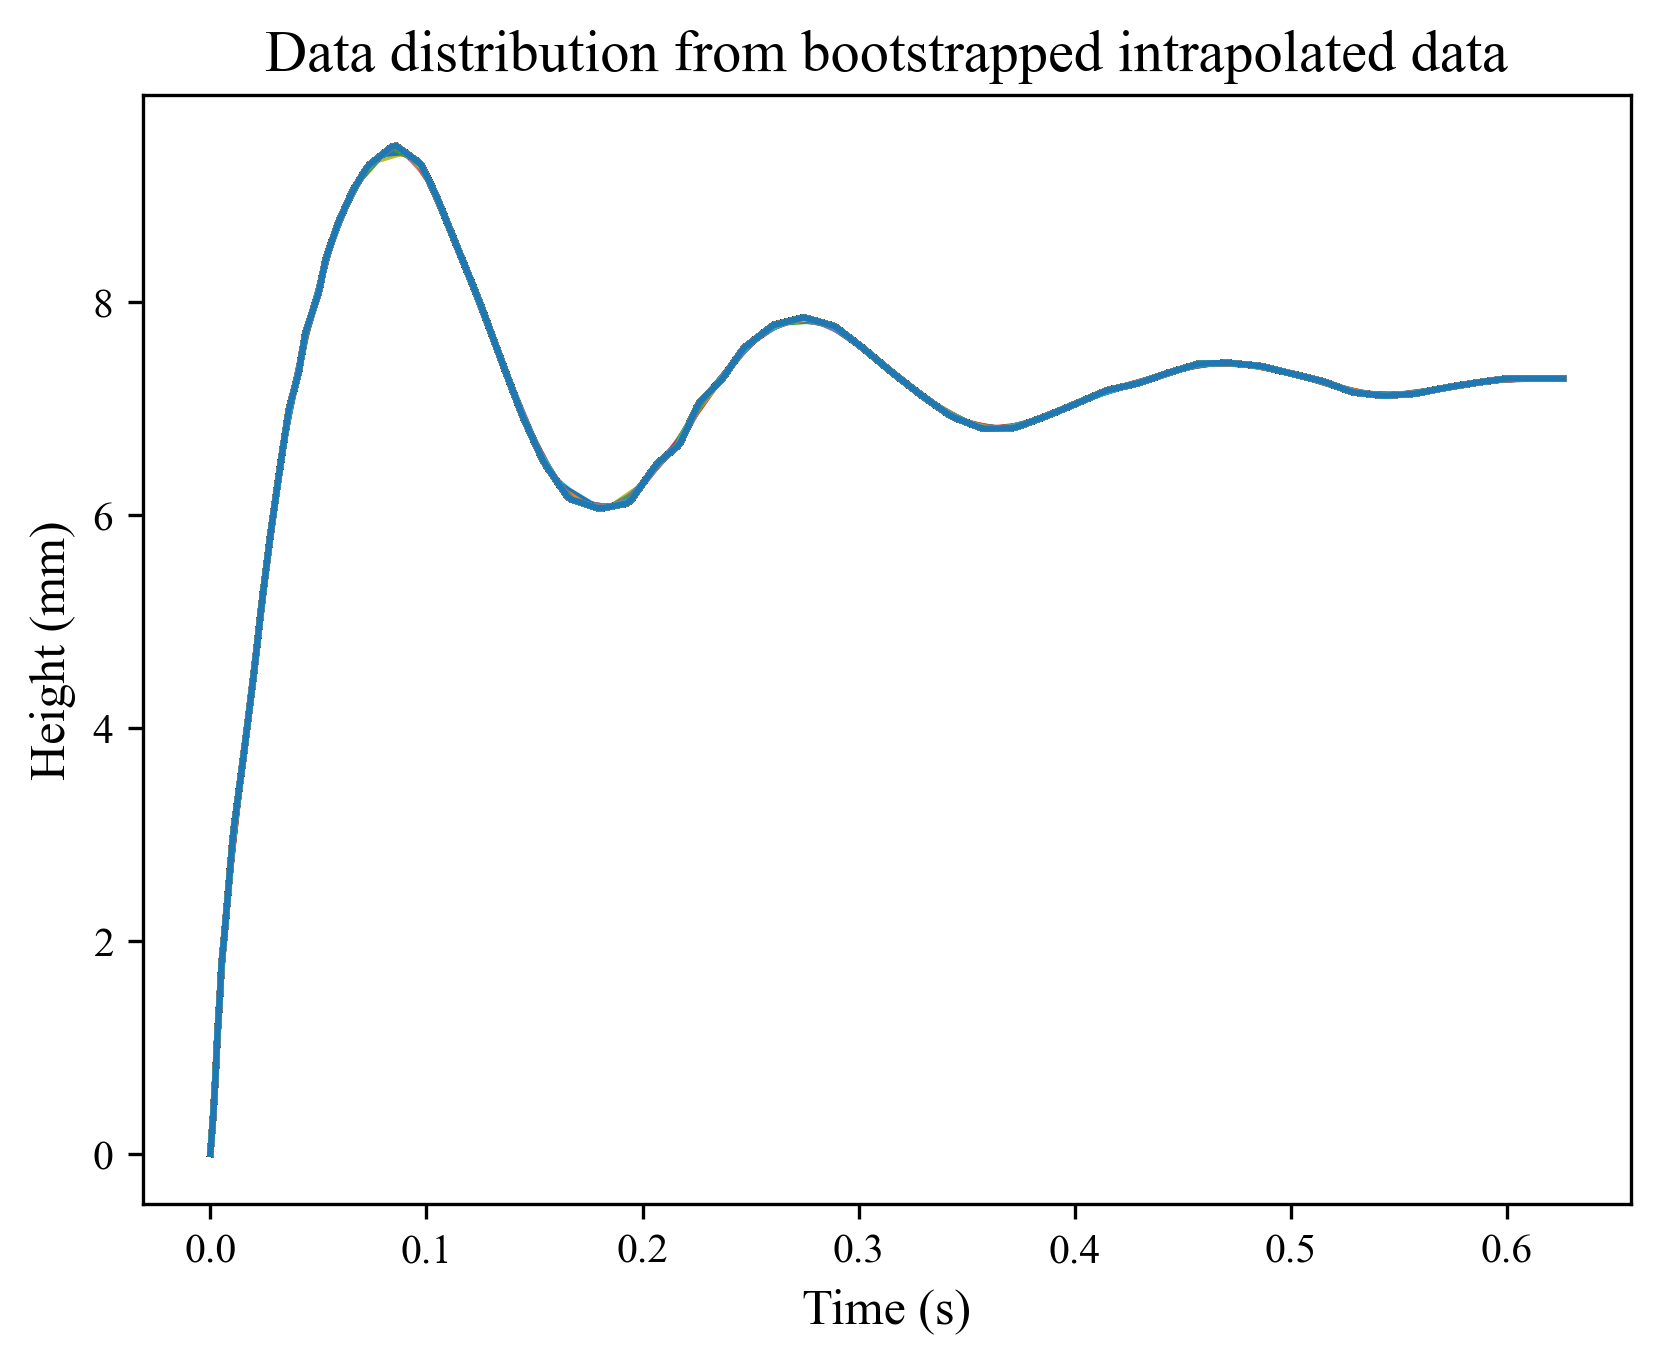

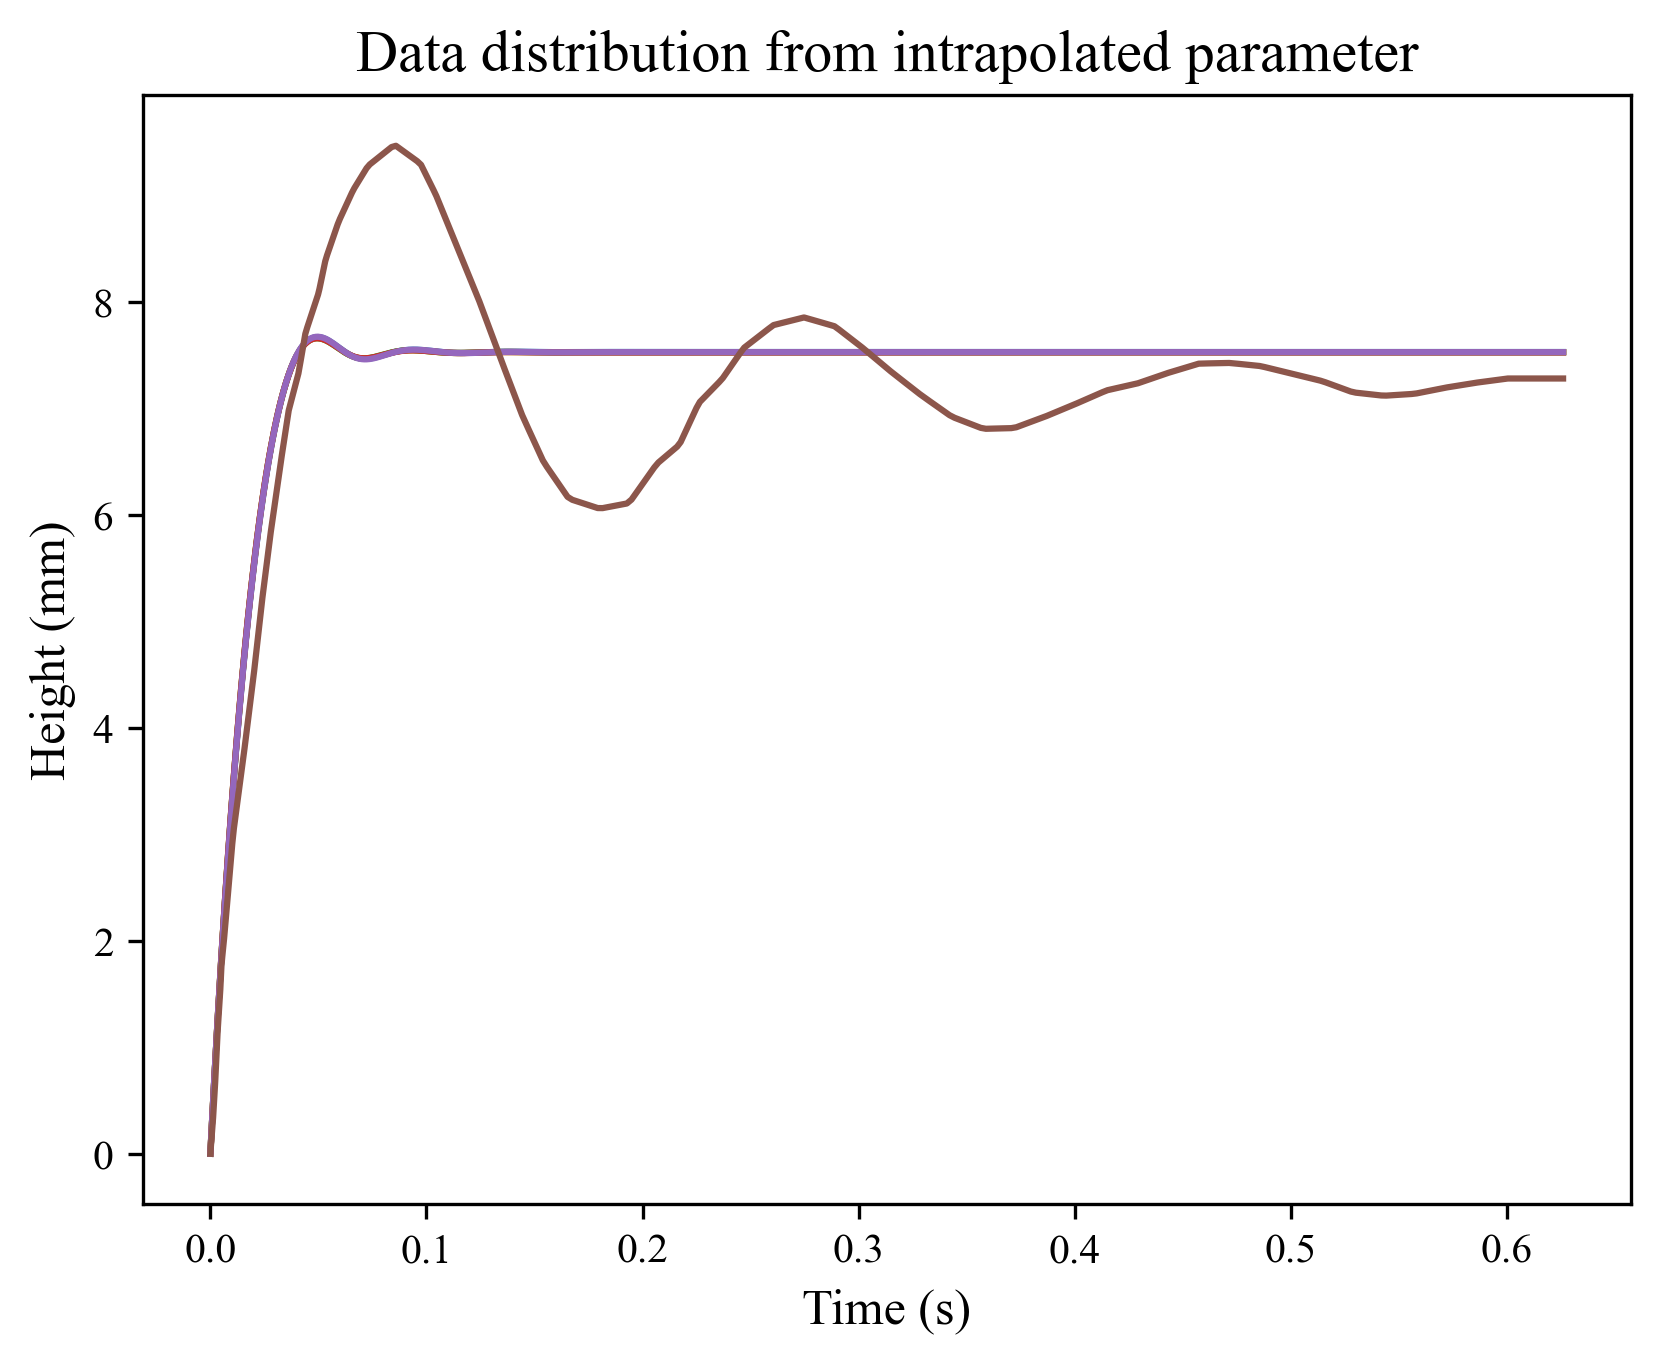

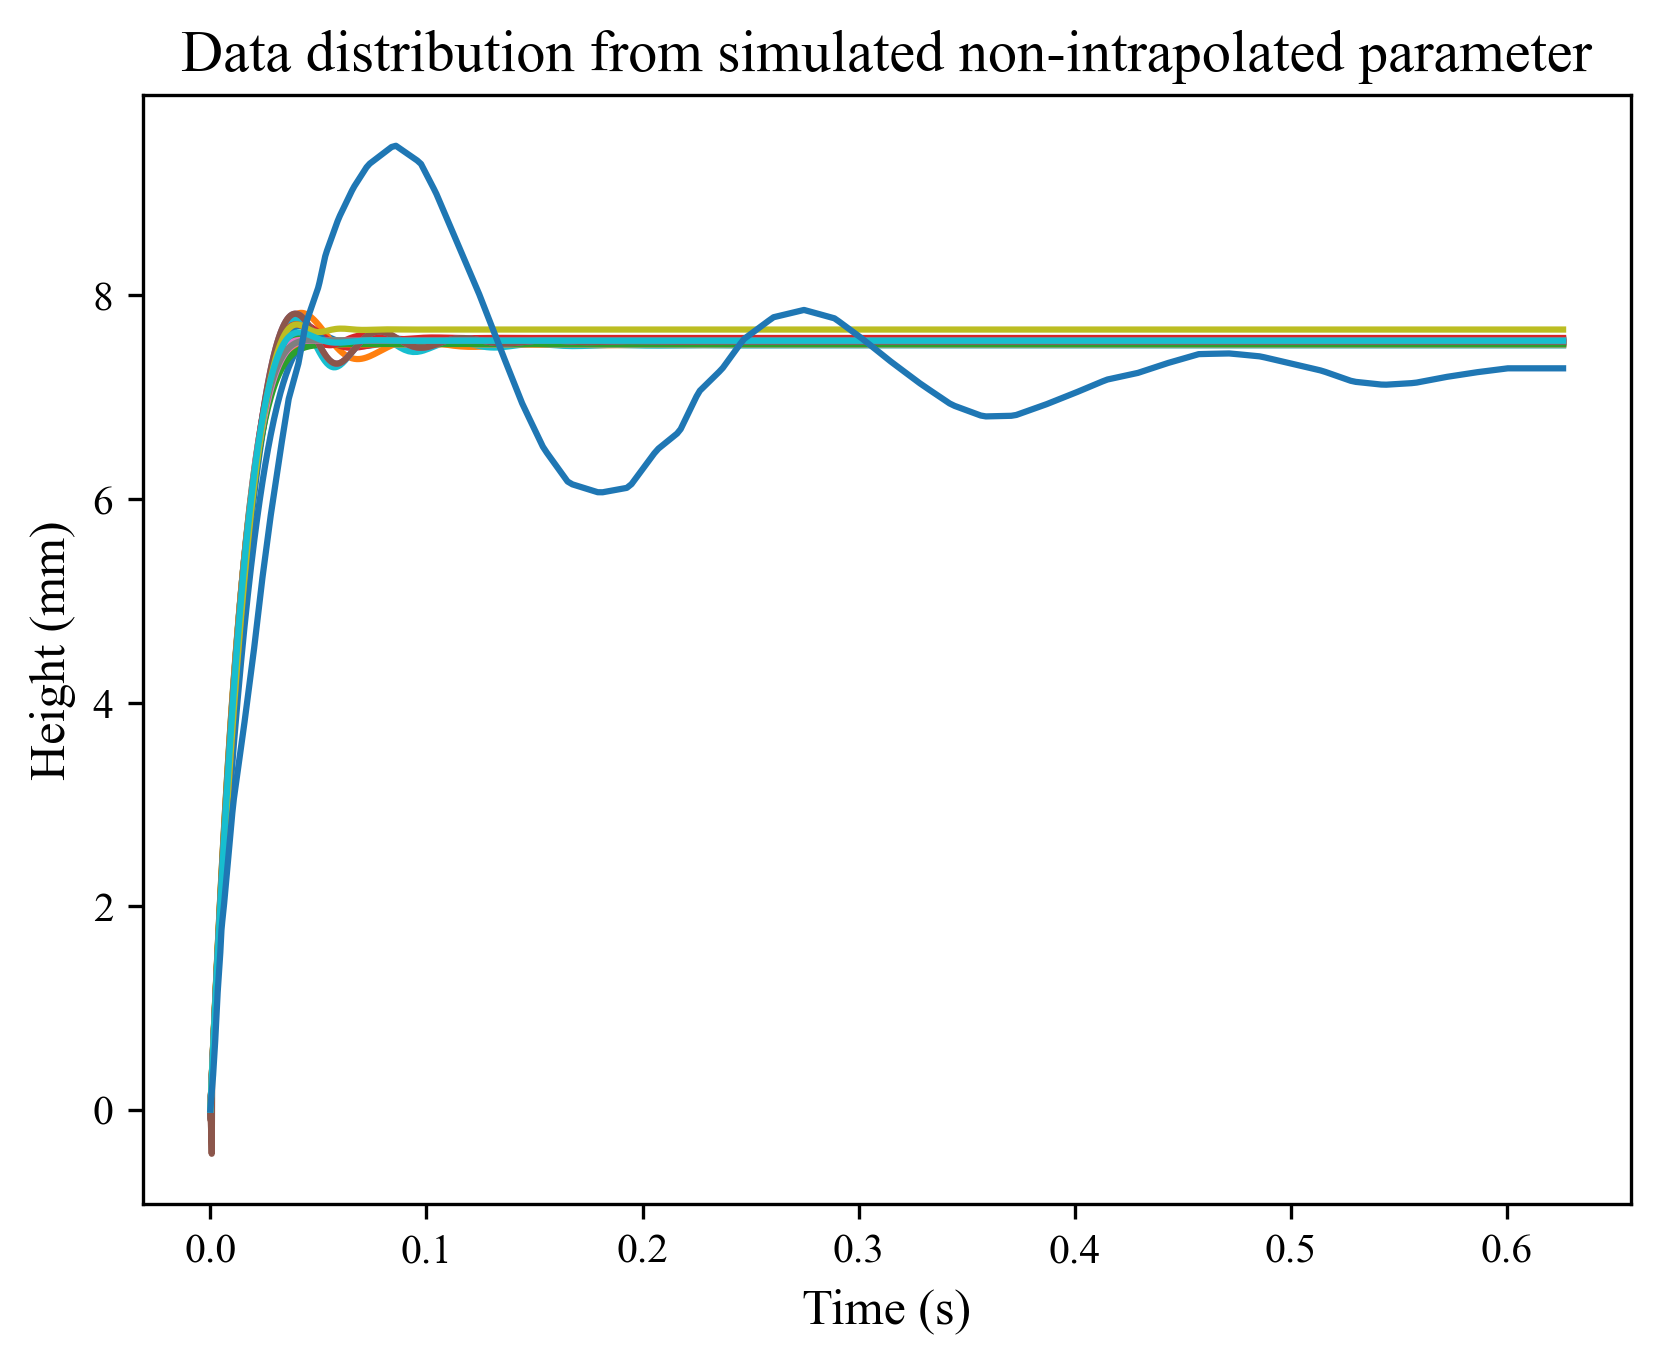

In [35]:
#plot intrapolated data
for i in range(len(bootstrap_set_x)):
    plt.plot(d_time, bootstrap_set_x[i])
    
plt.plot(d_time,d_height*1000)
plt.xlabel('Time (s)')
plt.ylabel('Height (mm)')
plt.title("Data distribution from bootstrapped intrapolated data")
plt.show()


#plot simulated data from intrapolated parameter
for i in range(len(simulated_observed_data_x)):
    plt.plot(d_time, simulated_observed_data_x[i])
    
plt.plot(d_time, d_height*1000)
plt.xlabel('Time (s)')
plt.ylabel('Height (mm)')
plt.title("Data distribution from intrapolated parameter")
plt.show()


#plot simulated data from non-intrapolated parameter
for i in range(len(simulated_observed_data)):
    plt.plot(d_time, simulated_observed_data[i])
    
plt.plot(d_time, d_height*1000)
plt.xlabel('Time (s)')
plt.ylabel('Height (mm)')
plt.title("Data distribution from simulated non-intrapolated parameter")
plt.show()


### Generating KDE for each set of data

In [36]:
vector_length = int(len(d_height)*0.2) #Specifying vector length for acceptance probability calculation

def kde_obs_intrap(X, i=vector_length):
    # Fit a kernel density estimator to the KDE_Dataset_sindy
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(bootstrap_set_x[:,:i])
    pds = np.exp(kde.score_samples(X[:,:i]))
    return pds

def kde_sim_intrap(X, i=vector_length):
    # Fit a kernel density estimator to the KDE_Dataset_sindy
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(simulated_observed_data_x[:,:i])
    pds = np.exp(kde.score_samples(X[:,:i]))
    return pds

def kde_sim(X, i=vector_length):
    # Fit a kernel density estimator to the KDE_Dataset_sindy
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(simulated_observed_data[:,:i])
    pds = np.exp(kde.score_samples(X[:,:i]))
    return pds

In [37]:
kde_obs_intrap(d_height.reshape(1,-1)*1000), kde_sim_intrap(d_height.reshape(1,-1)*1000), kde_sim(d_height.reshape(1,-1)*1000)

(array([6.13595194e+22]), array([9.71961244e-107]), array([9.49342116e-121]))

### Generate Prior Samples

#### Helper Functions


In [38]:

def Prior(mean = params, std=np.ones(len(params))*1): #std_feat
    """Generates a single sample from the prior distribution with the specified mean and covariance matrix"""
    
    sz = len(mean)
    if sz > 4:
        cov = np.diag(std,0)
    else:
        cov = np.diag(np.ones(len(mean))*1,0)
    params = np.random.multivariate_normal(mean, cov, size = 1)
    return params.reshape(-1)


def Generate_priors(n_samples=1000, mean = params, std = np.ones(len(params))*1):
    """Function for Generating multiple samples from the prior
    it samples from n_samples times from the given prior distribution above and then add random samples from the 
    bootstrapped parameter samples"""
    
    prior_params = []
    for i in tqdm(range(n_samples)):
        prior_params.append(Prior(mean,std ))
    prior_params = np.array(prior_params)
#     prior_params = np.vstack((prior_params,featuring_params))
    prior_params = prior_params[np.random.permutation(prior_params.shape[0])]
    return prior_params


def Q(params):
    """Function for Generating Model Output"""
    pred_height =  simulate_recovered_model(params, initial_vals_dgt, d_time, Pc = capillary_pressure)[0]*1000
    return pred_height

def nan_switch(array, val=0):
    # Replace NaN values with zeros
    array[np.isnan(array)] = val
    return array

#  Generate sample, compute pushforward, and define prior_kde

In [39]:
print('\n',"Basic SINDy: ", basic_sindy_params, 
      '\n', "Digitized parameter: ",  dig_params, 
      '\n', "Complete SINDy: ", complete_sindy_params,
     '\n',)# "SIP parameter: ", SIP_params, '\n')

params = complete_sindy_params
params


 Basic SINDy:  [6377.41291299 3650.57977514  302.72800029   22.05607908    0.        ] 
 Digitized parameter:  [6965.1, 5055.601079370831, 710, 710, 0] 
 Complete SINDy:  [ 8.37733979e+03  2.48068869e+03  2.89496797e+02  1.90329651e+01
 -2.63511884e+05] 



array([ 8.37733979e+03,  2.48068869e+03,  2.89496797e+02,  1.90329651e+01,
       -2.63511884e+05])

In [40]:
#Generate 10000 Prior samples with mean of unintrapolated bootstrapped parameter
mu =  dig_params #+np.random.normal([100,100, 20, 20, 0], 60, len(dig_params))
std = 1000
Prior_Samples = Generate_priors(10000, mu, np.ones(len(mu))*std)

# Generate the Push forward of the prior
Push_forward_of_Prior = []
for i in tqdm(range(len(Prior_Samples))):
    Push_forward_of_Prior.append(Q(Prior_Samples[i]))
Push_forward_of_Prior = np.array(Push_forward_of_Prior)


# Prior_kde function using same vector length used for the data kde
def prior_kde(X, dat=Push_forward_of_Prior, i=vector_length):
    """Fits a kernel density estimator to the datapoint up until the (i+1)th term"""
    # Fit a kernel density estimator to the KDE_Dataset
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(dat[:,:i])
    if len(X.shape)<2:
        X=X.reshape(1,-1)
    pds = np.exp(kde.score_samples(X[:,:i]))
    return pds

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:35<00:00, 280.61it/s]


In [41]:
def generate_multivariate_uniform_samples(mean_array, value, sample_size):
    # Calculate the lower and upper bounds for the multivariate uniform distribution
    mean_array = np.array(mean_array)
    lower_bound = mean_array - value
    upper_bound = mean_array + value

    # Generate random samples from the multivariate uniform distribution
    samples = np.random.uniform(lower_bound, upper_bound, size=(sample_size, len(mean_array)))
    return samples

# Example usage
mean_array = np.zeros(len(dig_params))
value = 10000
sample_size = 5000

uniform_samples = generate_multivariate_uniform_samples(mean_array, value, sample_size)

In [42]:
#Generate 10000 Prior samples with mean of intrapolated bootstrapped parameter
mu_x =  params #np.zeros(5)#bootstrap_params_mean_x
std_x = 1000
Prior_Samples_x = Generate_priors(20000, mu_x, np.ones(len(mu))*std_x)#      uniform_samples#      

# Generate the Push forward of the prior
Push_forward_of_Prior_x = []
for i in tqdm(range(len(Prior_Samples_x))):
    Push_forward_of_Prior_x.append(Q(Prior_Samples_x[i]))
Push_forward_of_Prior_x = np.array(Push_forward_of_Prior_x)

# Prior_kde function using same vector length used for the data kde
def prior_kde_x(X, dat=Push_forward_of_Prior_x, i=vector_length):
    """Fits a kernel density estimator to the datapoint up until the (i+1)th term"""
    # Fit a kernel density estimator to the KDE_Dataset
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(dat[:,:i])
    if len(X.shape)<2:
        X=X.reshape(1,-1)
    pds = np.exp(kde.score_samples(X[:,:i]))
    return pds

  0%|                                                                                        | 0/20000 [00:00<?, ?it/s]C:\Users\USER\AppData\Local\Temp\ipykernel_9628\944147287.py:36: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  Simulated = odeint(infiltration_model, y0=initial_vals, t= simu_time,  tfirst = True).T
100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:34<00:00, 210.97it/s]


In [43]:
# obs_kdes = kde_obs_intrap, kde_sim_intrap, kde_sim
# prior_kdes = prior_kde, prior_kde_x

# Reweighting Factor r(lamda)
def r_ratio(Push_forward_Data):
    r_prior = prior_kde(Push_forward_Data)
    r_obs = kde_obs_intrap(Push_forward_Data)
    ratios = r_obs/r_prior
    m = max(ratios)
    return m,ratios

# Reweighting Factor r(lamda)
def r_ratio_x(Push_forward_Data):
    r_prior = prior_kde_x(Push_forward_Data)
    r_obs = kde_obs_intrap(Push_forward_Data)
    ratios = r_obs/r_prior
    m = max(ratios)
    return m,ratios

### Rejection Sampling Algorithm

In [44]:
Push_forward_of_Prior_x = nan_switch(Push_forward_of_Prior_x)
Push_forward_of_Prior = nan_switch(Push_forward_of_Prior)

In [45]:
# Calling the Reweighting Factor function to find M and Lamda values of the prior parameters
# N, Lamda_values = r_ratio(Push_forward_of_Prior) 
Nx, Lamda_values_x = r_ratio_x(Push_forward_of_Prior_x) 

In [46]:
Lamda_values_x, Lamda_values_x

(array([1.77549489e-079, 0.00000000e+000, 4.43566694e-131, ...,
        1.95618167e-152, 1.45156847e-245, 1.60428191e-123]),
 array([1.77549489e-079, 0.00000000e+000, 4.43566694e-131, ...,
        1.95618167e-152, 1.45156847e-245, 1.60428191e-123]))

In [47]:
M = Nx
LVs = Lamda_values_x
PS = Prior_Samples_x
#Iterating to accept or reject lamdas in the prior
Accepted_lamda = []
Index = []
p=0
for p in range(len(LVs)):
    r_p = LVs[p]
    xi_p = np.random.uniform()
    eta_p = r_p/M
    if eta_p > xi_p:
        Accepted_lamda.append(PS[p])
        Index.append(p)
Accepted_lamda = np.array(Accepted_lamda)
Index = np.array(Index)
Index[:].shape

(1,)

In [48]:
Accepted_lamda

array([[ 8.37754272e+03,  2.47489494e+03,  3.99726021e+02,
         2.69686889e+00, -2.63504224e+05]])

### Pushforward of the Posterior

In [49]:
# Compute Pushforward of the posterior
Push_forward_of_Posterior = []
for i in tqdm(range(len(Accepted_lamda))):
    Push_forward_of_Posterior.append(Q(Accepted_lamda[i]))
Push_forward_of_Posterior = np.array(Push_forward_of_Posterior)    

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 167.08it/s]


In [50]:
def plot_matrix_distribution(matrix, labels, y_label= ["Density"]*50):
    """
    Plots the distribution of each column of a matrix using a kernel density estimation.
    Each distribution is plotted in a separate figure vertically stacked on top of each other.
    
    Parameters:
        matrix (numpy.ndarray): Input matrix with shape (n_rows, n_cols).
        labels (list): List of strings containing the labels for each column.
    """
    min_lim =  np.min(np.min(matrix, axis=0))
    max_lim =  np.max(np.max(matrix, axis=0))
    
    # Create a separate plot for each column
    for i in range(matrix.shape[1]):
        fig, ax = plt.subplots(figsize=(3, 1.5))
        min_lim = np.min(matrix[:,i], axis=0)
        max_lim = np.max(matrix[:,i], axis=0)
        
        # Fit a kernel density estimator for the column
        kde = sns.kdeplot(matrix[:, i], bw_adjust=0.5, shade=True, color="brown", ax=ax)
        
        # Set plot aesthetics
        sns.despine(left=True, ax=ax)
        ax.set_xlabel(f"$\mu$ = {np.mean(matrix[:,i]).round(3)}")
        ax.set_ylabel(y_label[i])
        ax.set_yticks([])
        ax.set_xlim(min_lim,max_lim)
        
        # Add a vertical dashed line at the zero point of the x-axis
        ax.axvline(x=0, linestyle='--', color='black', alpha=0.8)
        
        plt.tight_layout()
        
        # Show the plot
        plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_9628\2861987168.py:20: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kde = sns.kdeplot(matrix[:, i], bw_adjust=0.5, shade=True, color="brown", ax=ax)


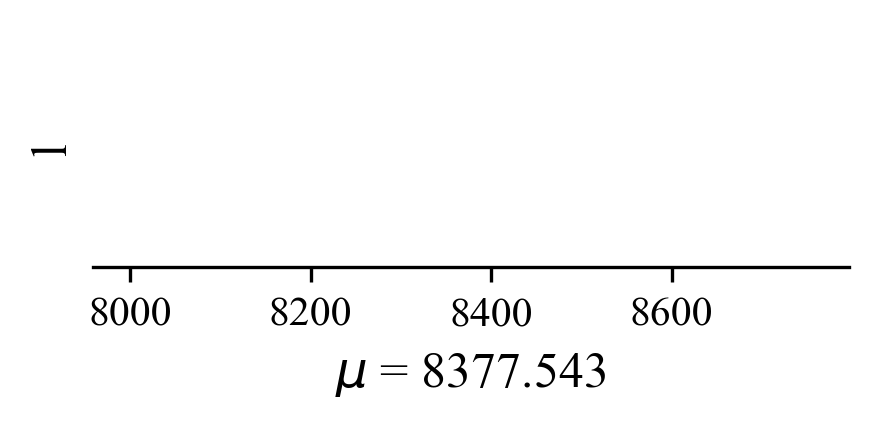

C:\Users\USER\AppData\Local\Temp\ipykernel_9628\2861987168.py:20: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kde = sns.kdeplot(matrix[:, i], bw_adjust=0.5, shade=True, color="brown", ax=ax)


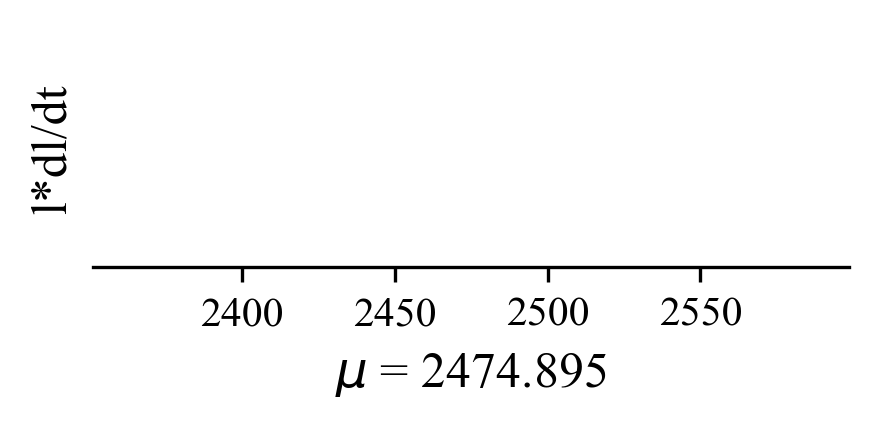

C:\Users\USER\AppData\Local\Temp\ipykernel_9628\2861987168.py:20: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kde = sns.kdeplot(matrix[:, i], bw_adjust=0.5, shade=True, color="brown", ax=ax)


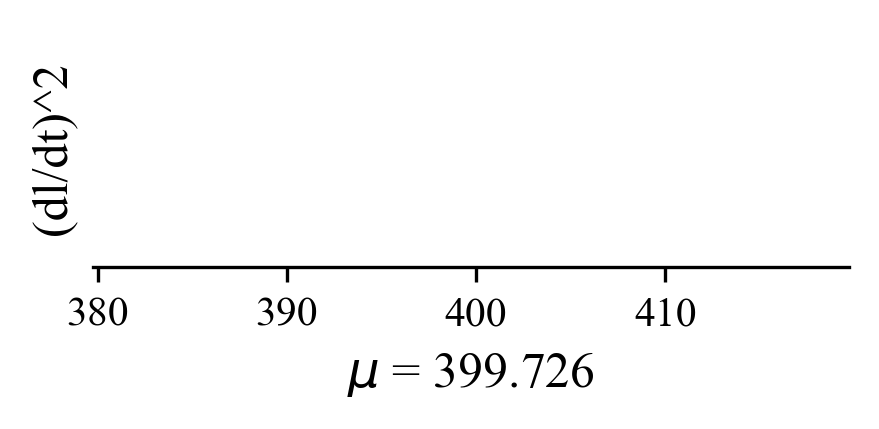

C:\Users\USER\AppData\Local\Temp\ipykernel_9628\2861987168.py:20: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kde = sns.kdeplot(matrix[:, i], bw_adjust=0.5, shade=True, color="brown", ax=ax)


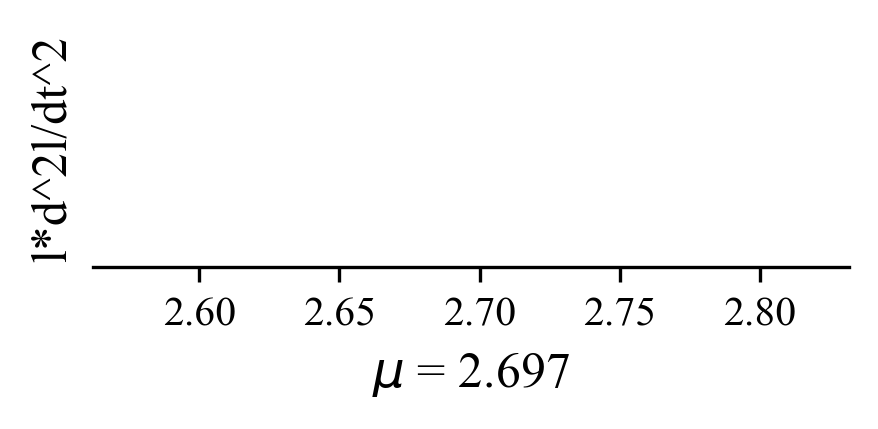

C:\Users\USER\AppData\Local\Temp\ipykernel_9628\2861987168.py:20: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kde = sns.kdeplot(matrix[:, i], bw_adjust=0.5, shade=True, color="brown", ax=ax)


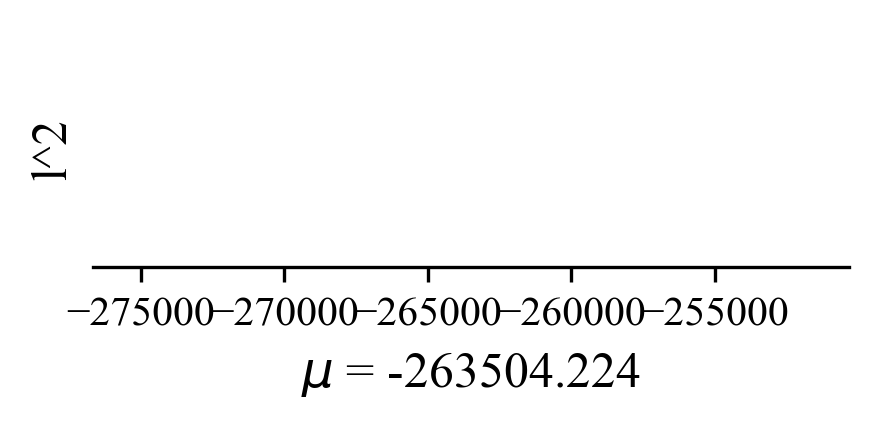

In [51]:
matplotlib.rcParams.update({'font.size': 9})
labels = Complete_labels #  ['1','L','dL/dt','L^2','LdL/dt','(dL/dt)^2' ]
y_label = Complete_labels #['1','L','dL/dt','L^2','LdL/dt','(dL/dt)^2' ]
plot_matrix_distribution(Accepted_lamda[:], labels, y_label)

In [52]:
# Compare mean Prior and Posterior samples of the parameters
SIP_param = np.mean(Accepted_lamda,0)

print(f"Prior mean, sigma = \n {np.mean(PS, 0).round(2)} \n {np.std(PS, 0).round(2)} \n")
print(f"Posterior mean = \n {np.mean(Accepted_lamda,0).round(2)} \n {np.std(Accepted_lamda, 0).round(3)} \n")

Prior mean, sigma = 
 [ 8.3772400e+03  2.4806500e+03  2.8990000e+02  1.9250000e+01
 -2.6351167e+05] 
 [31.54 31.78 31.67 31.63 31.32] 

Posterior mean = 
 [ 8.3775400e+03  2.4748900e+03  3.9973000e+02  2.7000000e+00
 -2.6350422e+05] 
 [0. 0. 0. 0. 0.] 



### Comparing Observed data, Simulated data with "True" parameter and Recovered parameter  

In [53]:
complete_sindy_params
 
(
mean_squared_error(dig_params, [6977.3,  5057.7,  680.5,  673.75,  1.65], squared = False),
mean_squared_error(dig_params, [6599.6,  3735.1,  426.1,  14.1,  0.2] , squared = False),
mean_squared_error(dig_params, [6944.7,  5417.31,  652.33,  84.6,  197.69] , squared = False),
mean_squared_error(dig_params, [9291.8,  5442.4,  752.6,  1421.9,  9362.4], squared = False),
mean_squared_error(dig_params, complete_sindy_params, squared = False),)


C:\Users\USER\.conda\envs\sunode-env\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\USER\.conda\envs\sunode-env\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\USER\.conda\envs\sunode-env\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\USER\.conda\envs\sunode-env\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To

(21.634604076837395,
 698.8833108065365,
 336.08981783526815,
 4329.579573699965,
 117853.97060271261)

MSE SINDy = 0.0011597052191262712
MSE SIP = 0.0010947601483406516
MSE Simulated = 0.0
digitized parameter = [6965.1, 5055.601079370831, 710, 710, 0]
Sindy parameter = [ 8.37733979e+03  2.48068869e+03  2.89496797e+02  1.90329651e+01
 -2.63511884e+05]
SIP parameter = [ 8.37754272e+03  2.47489494e+03  3.99726021e+02  2.69686889e+00
 -2.63504224e+05]


C:\Users\USER\.conda\envs\sunode-env\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\USER\.conda\envs\sunode-env\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\USER\.conda\envs\sunode-env\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


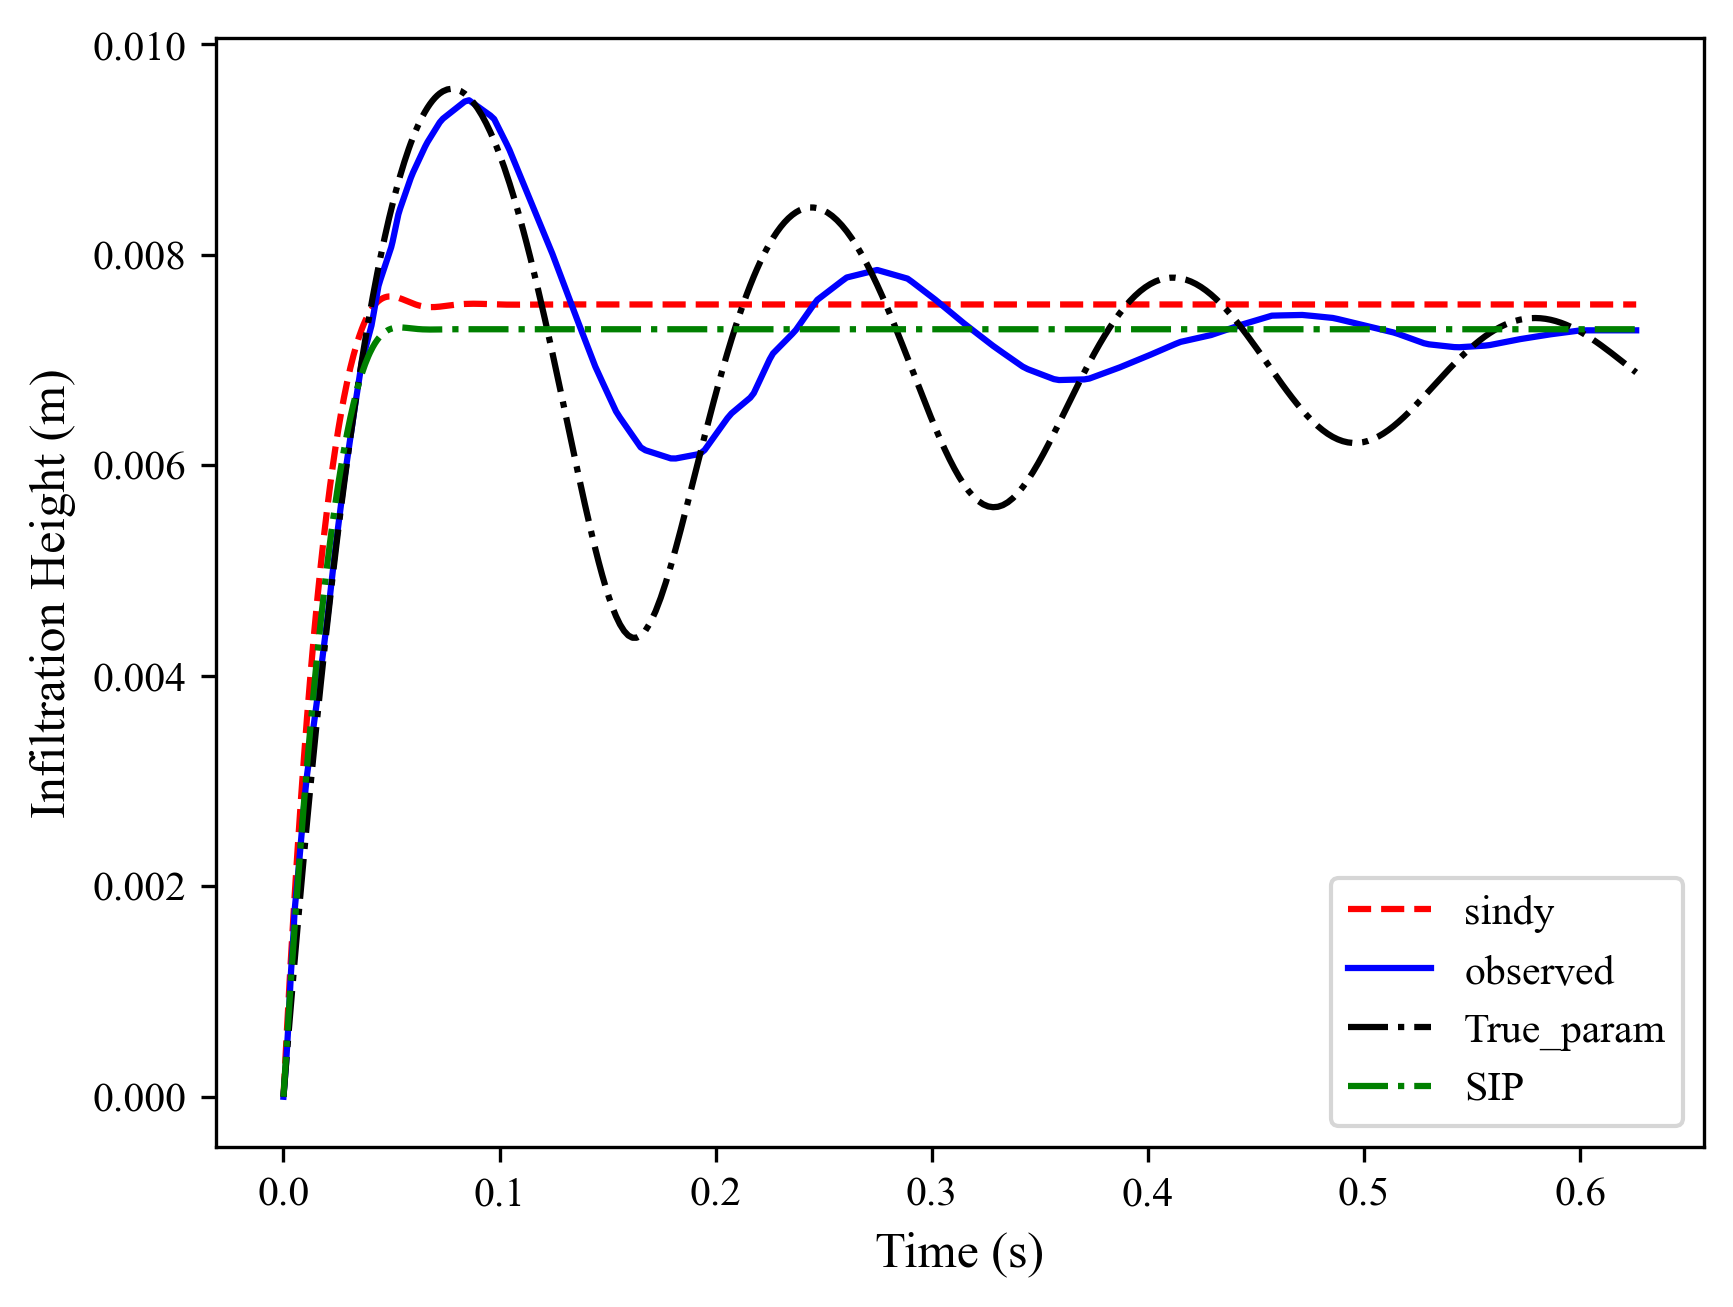

In [54]:
matplotlib.rcParams.update({'font.size': 14})
# SIP_param = Al[0] #np.mean(Al,0)
#simulate SIP recovered model
sip_true = simulate_recovered_model([6599.6,  3735.1,  426.1,  14.1,  0.2] 
                                   ,initial_vals_dgt,d_time, Pc = capillary_pressure)[0]
sip_sim = simulate_recovered_model(SIP_param, initial_vals_dgt, d_time, Pc = capillary_pressure)[0]
cplt_sindy = simulate_recovered_model(complete_sindy_params, initial_vals_dgt, d_time, Pc = capillary_pressure)[0]

print(f"MSE SINDy = {mean_squared_error(dgt_sim, cplt_sindy, squared = False)}")
print(f"MSE SIP = {mean_squared_error(dgt_sim, sip_true, squared = False)}")
print(f"MSE Simulated = {mean_squared_error(dgt_sim, dgt_sim, squared = False)}")

# print(basic_sindy_params, '\n', dig_params, '\n', complete_sindy_params )

plt.plot(d_time, cplt_sindy, 'r--', label = "sindy")
plt.plot(d_time, d_height,  'b', label = "observed")
plt.plot(d_time, dgt_sim, 'k-.', label = "True_param")
plt.plot(d_time, sip_true, 'g-.', label = "SIP")

# print(mean_squared_error(d_height, cplt_sindy, squared = False))
print(f'digitized parameter = {dig_params}')
print(f'Sindy parameter = {complete_sindy_params}')
print(f'SIP parameter = {SIP_param}')

plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Infiltration Height (m)')
plt.show()

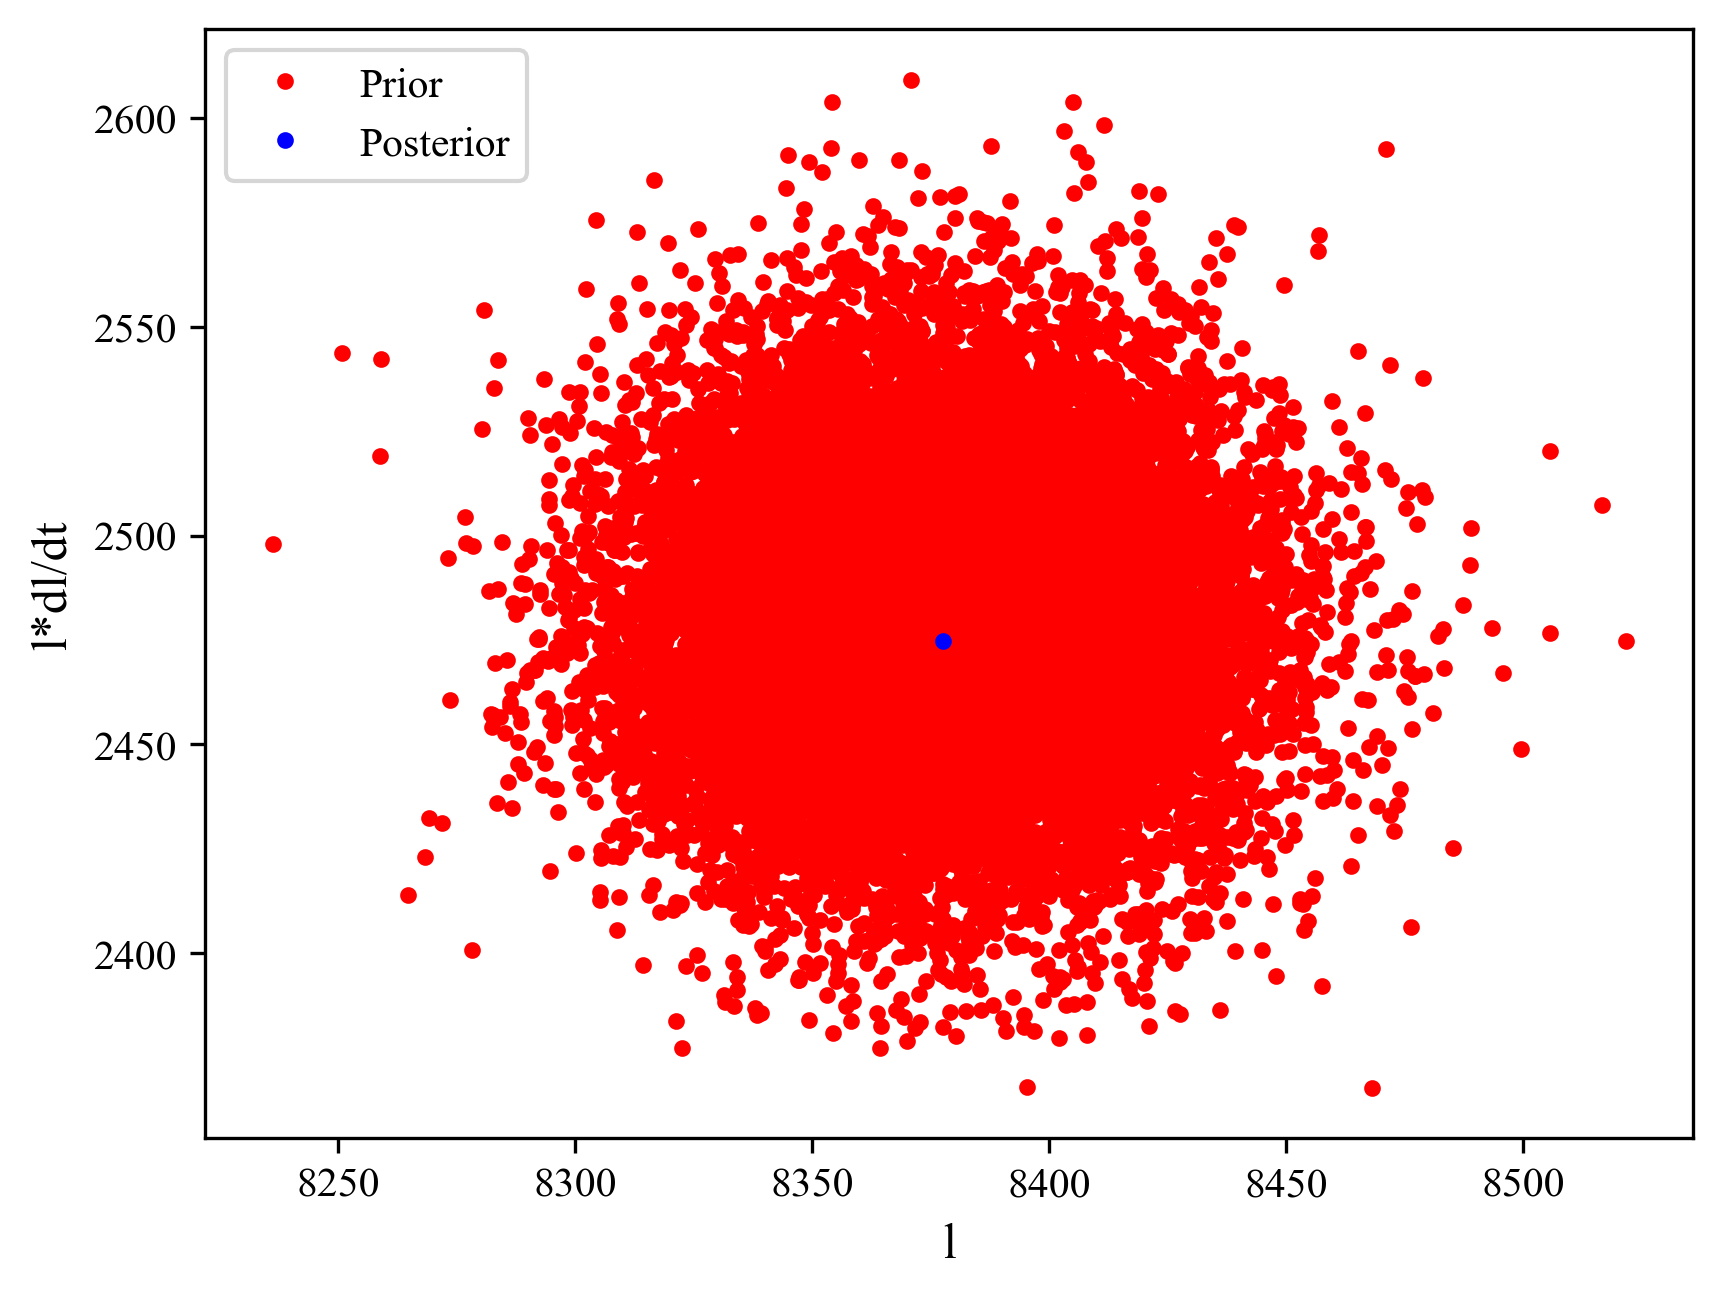

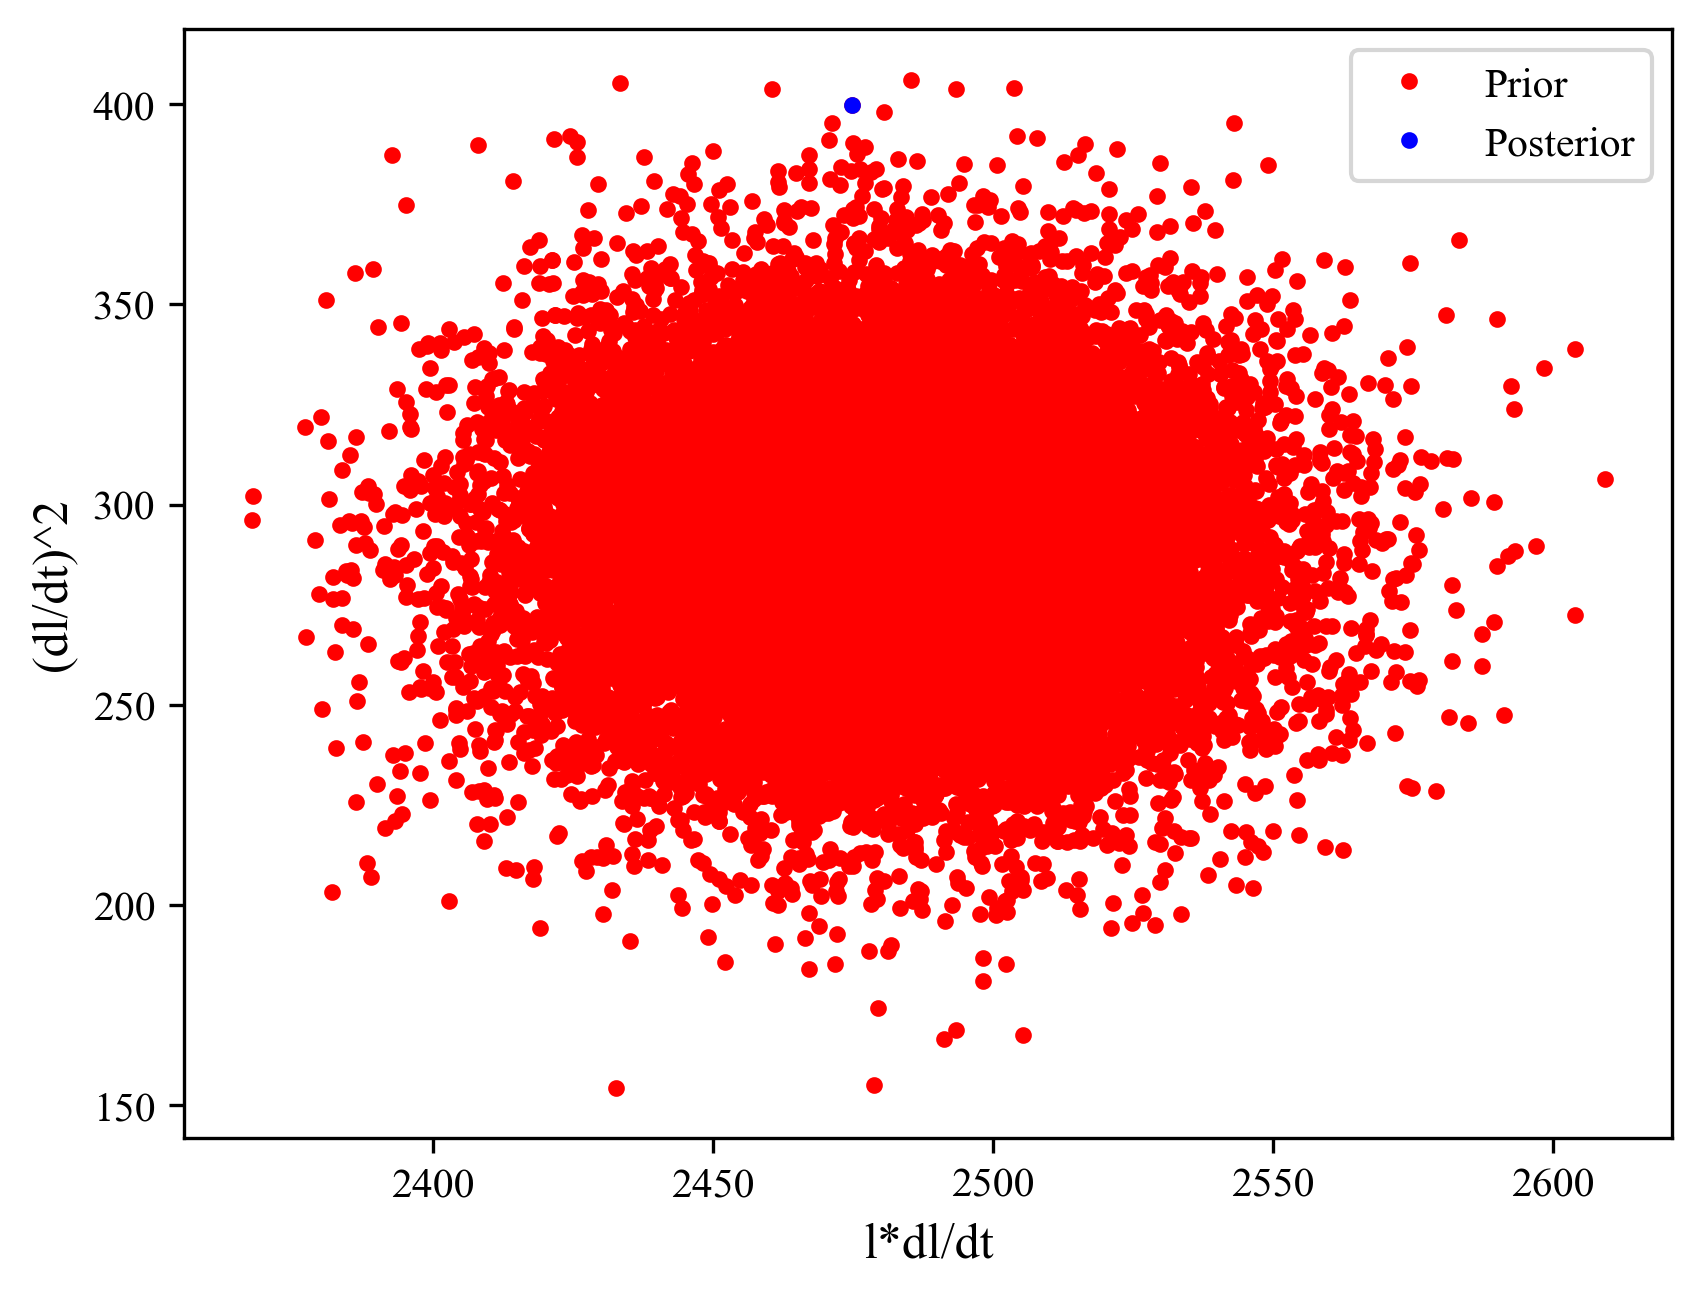

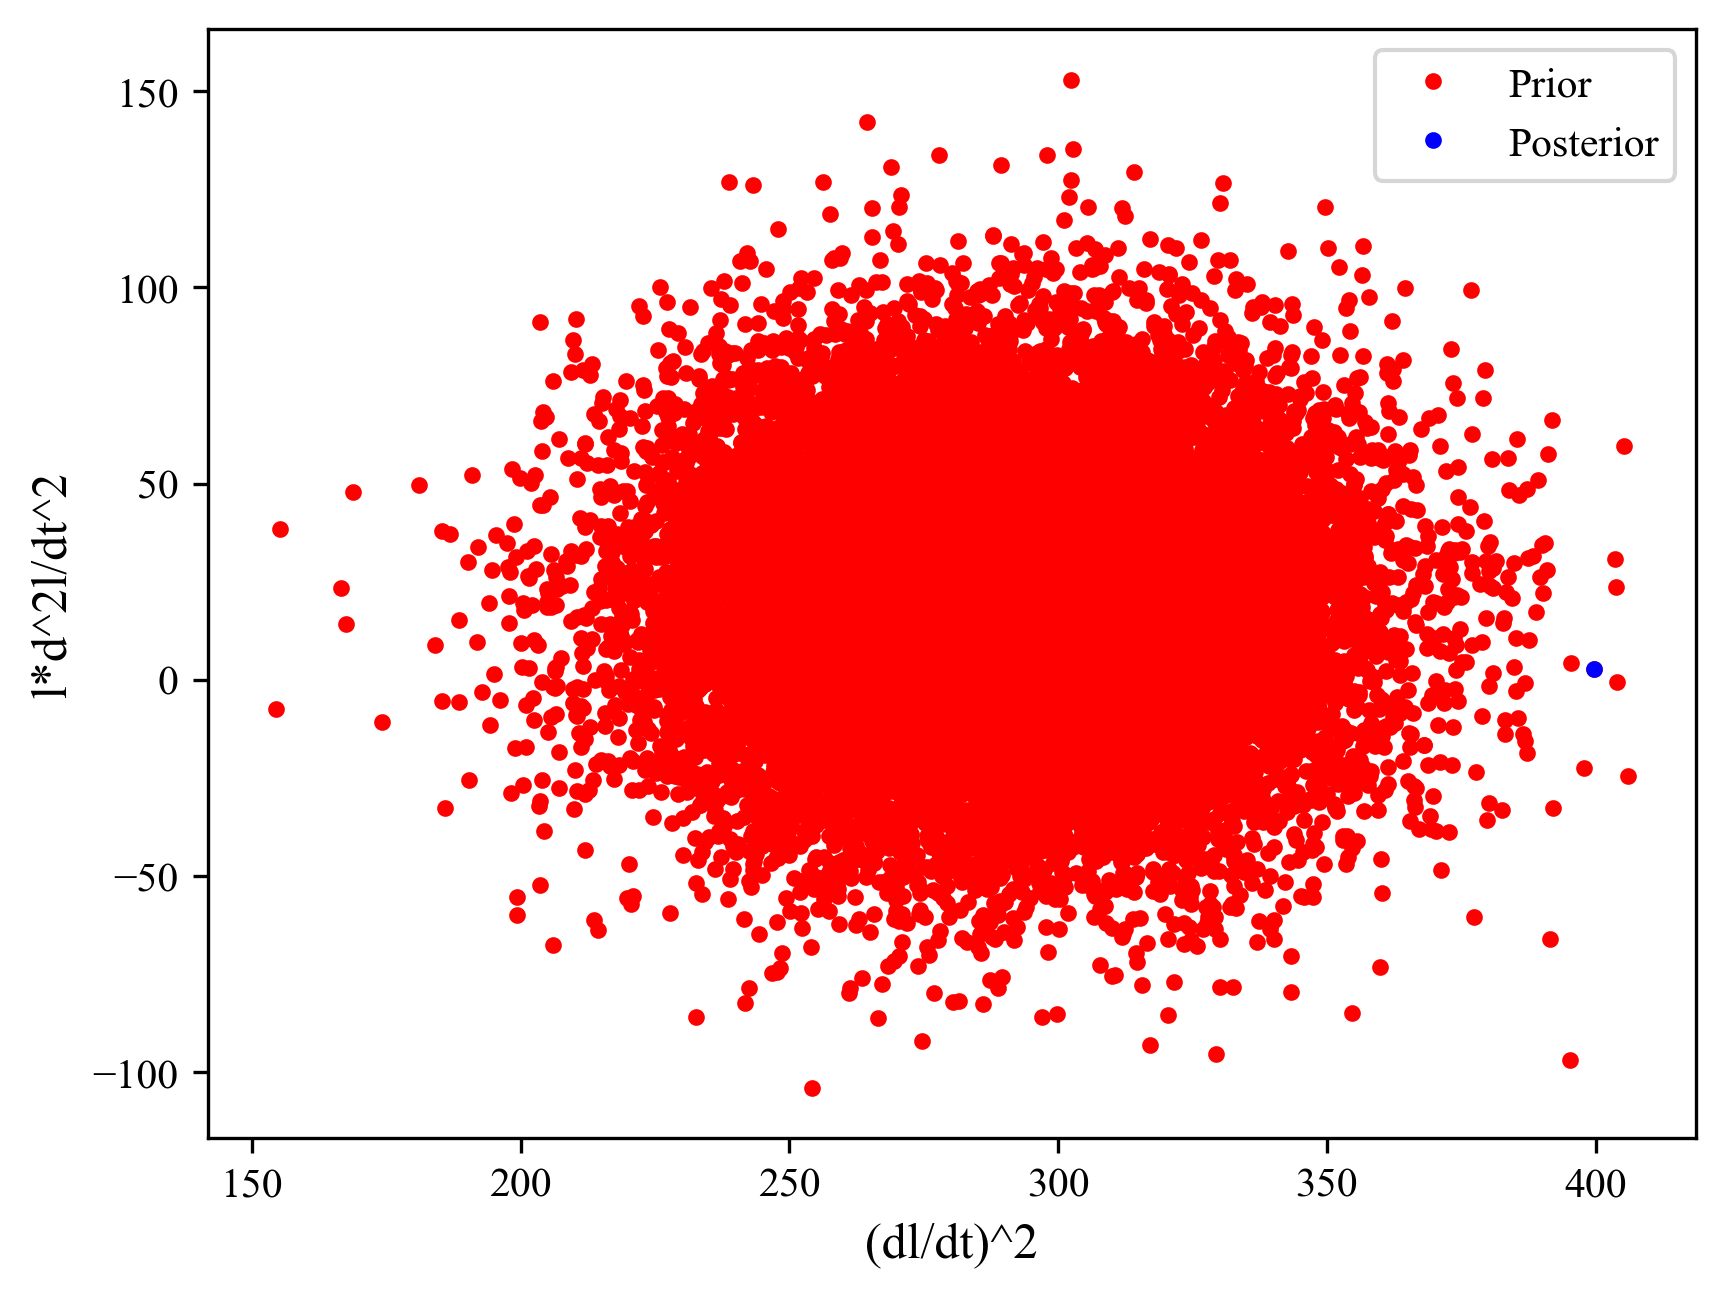

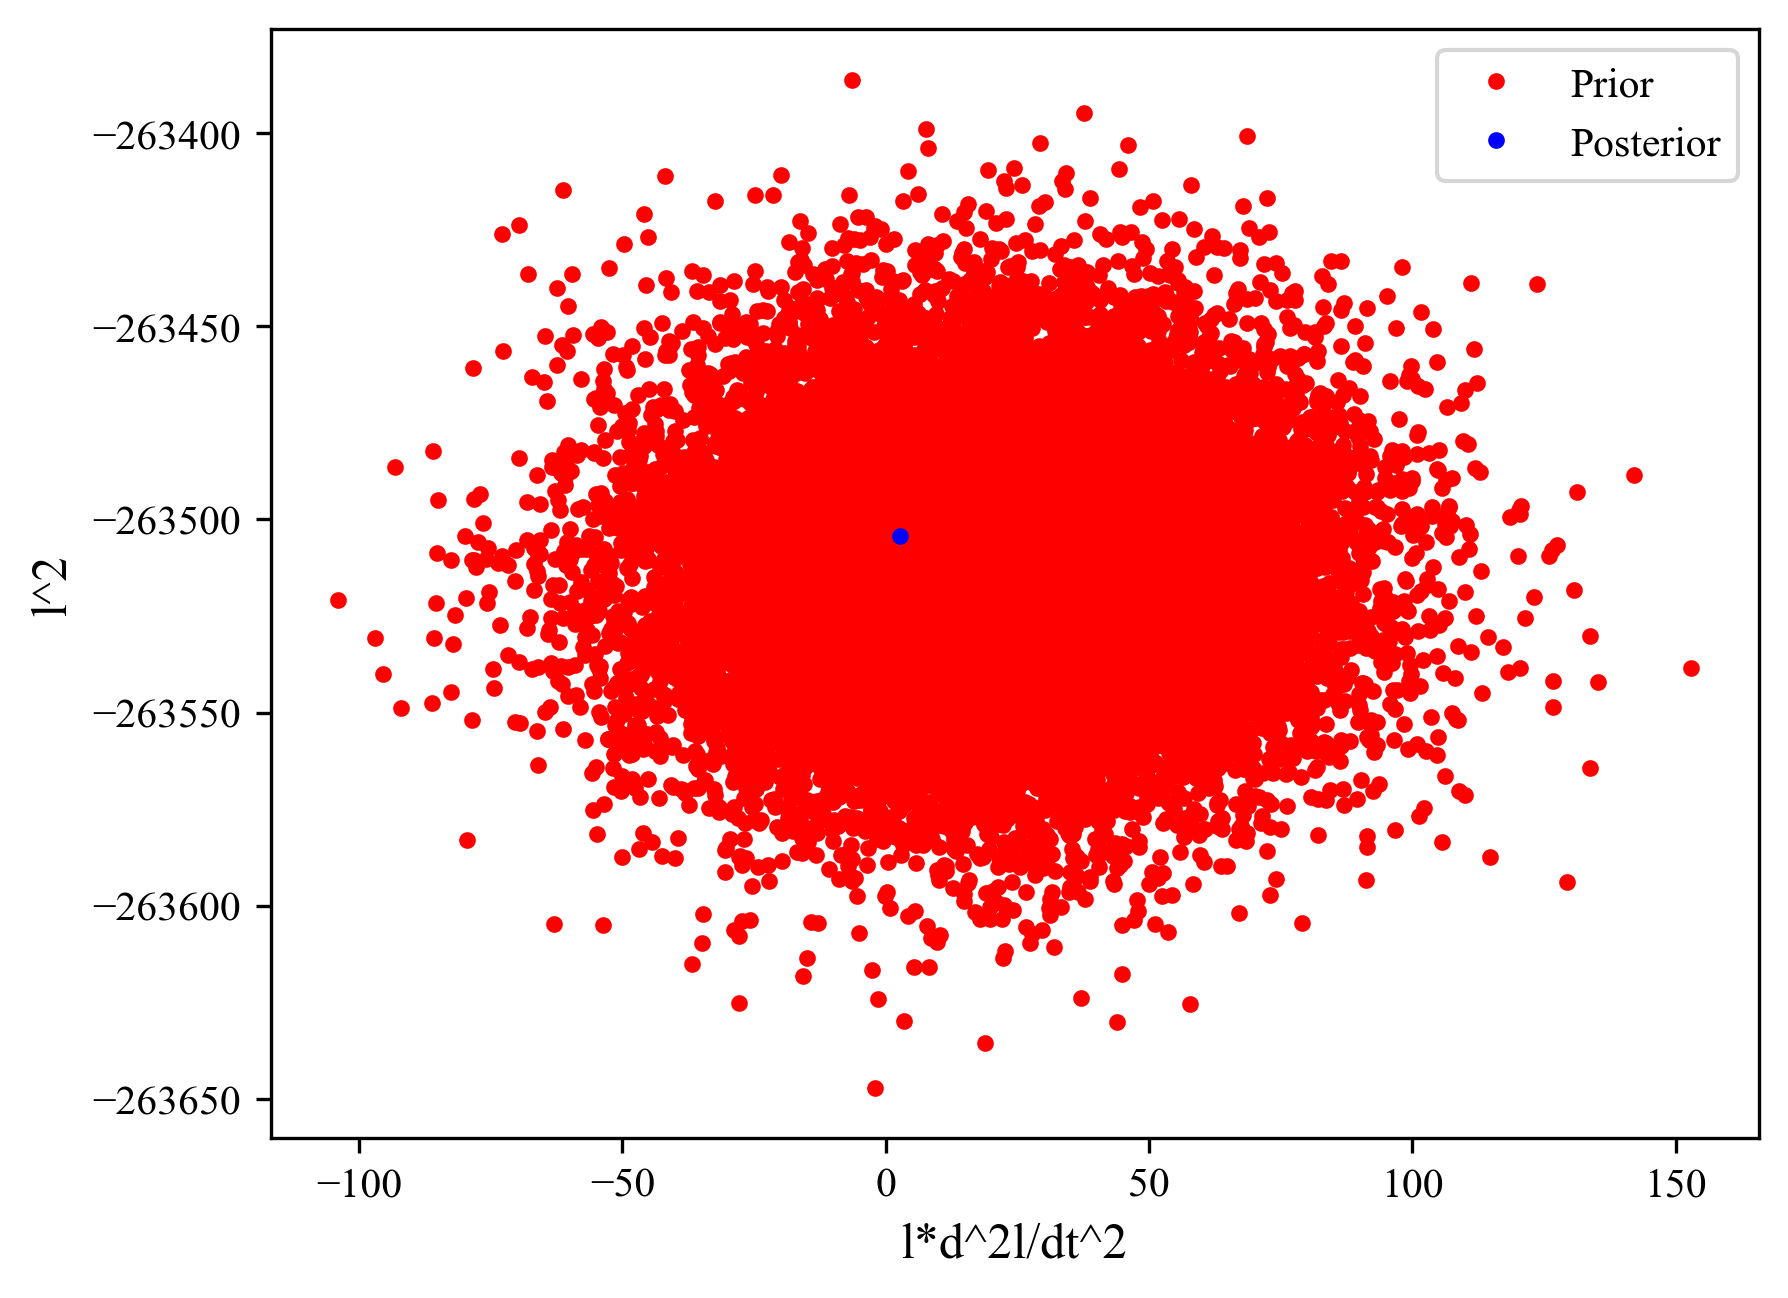

In [55]:
#Scatter plots of Prior and Posterior samples for each parameter
accpt_par = Accepted_lamda#[:,focus_idx]
prior_par = Prior_Samples_x#[:,focus_idx] 
lab_par = np.array(labels)#[focus_idx]
for a in range(len(lab_par)):
    for b in range(len(lab_par)):
        if b==a+1:
            plt.plot(prior_par[:,a],prior_par[:,b],'r.', label='Prior')
            plt.plot(accpt_par[:,a],accpt_par[:,b],'b.',label='Posterior')
            plt.legend()
            plt.xlabel(lab_par[a])
            plt.ylabel(lab_par[b])
            plt.show()

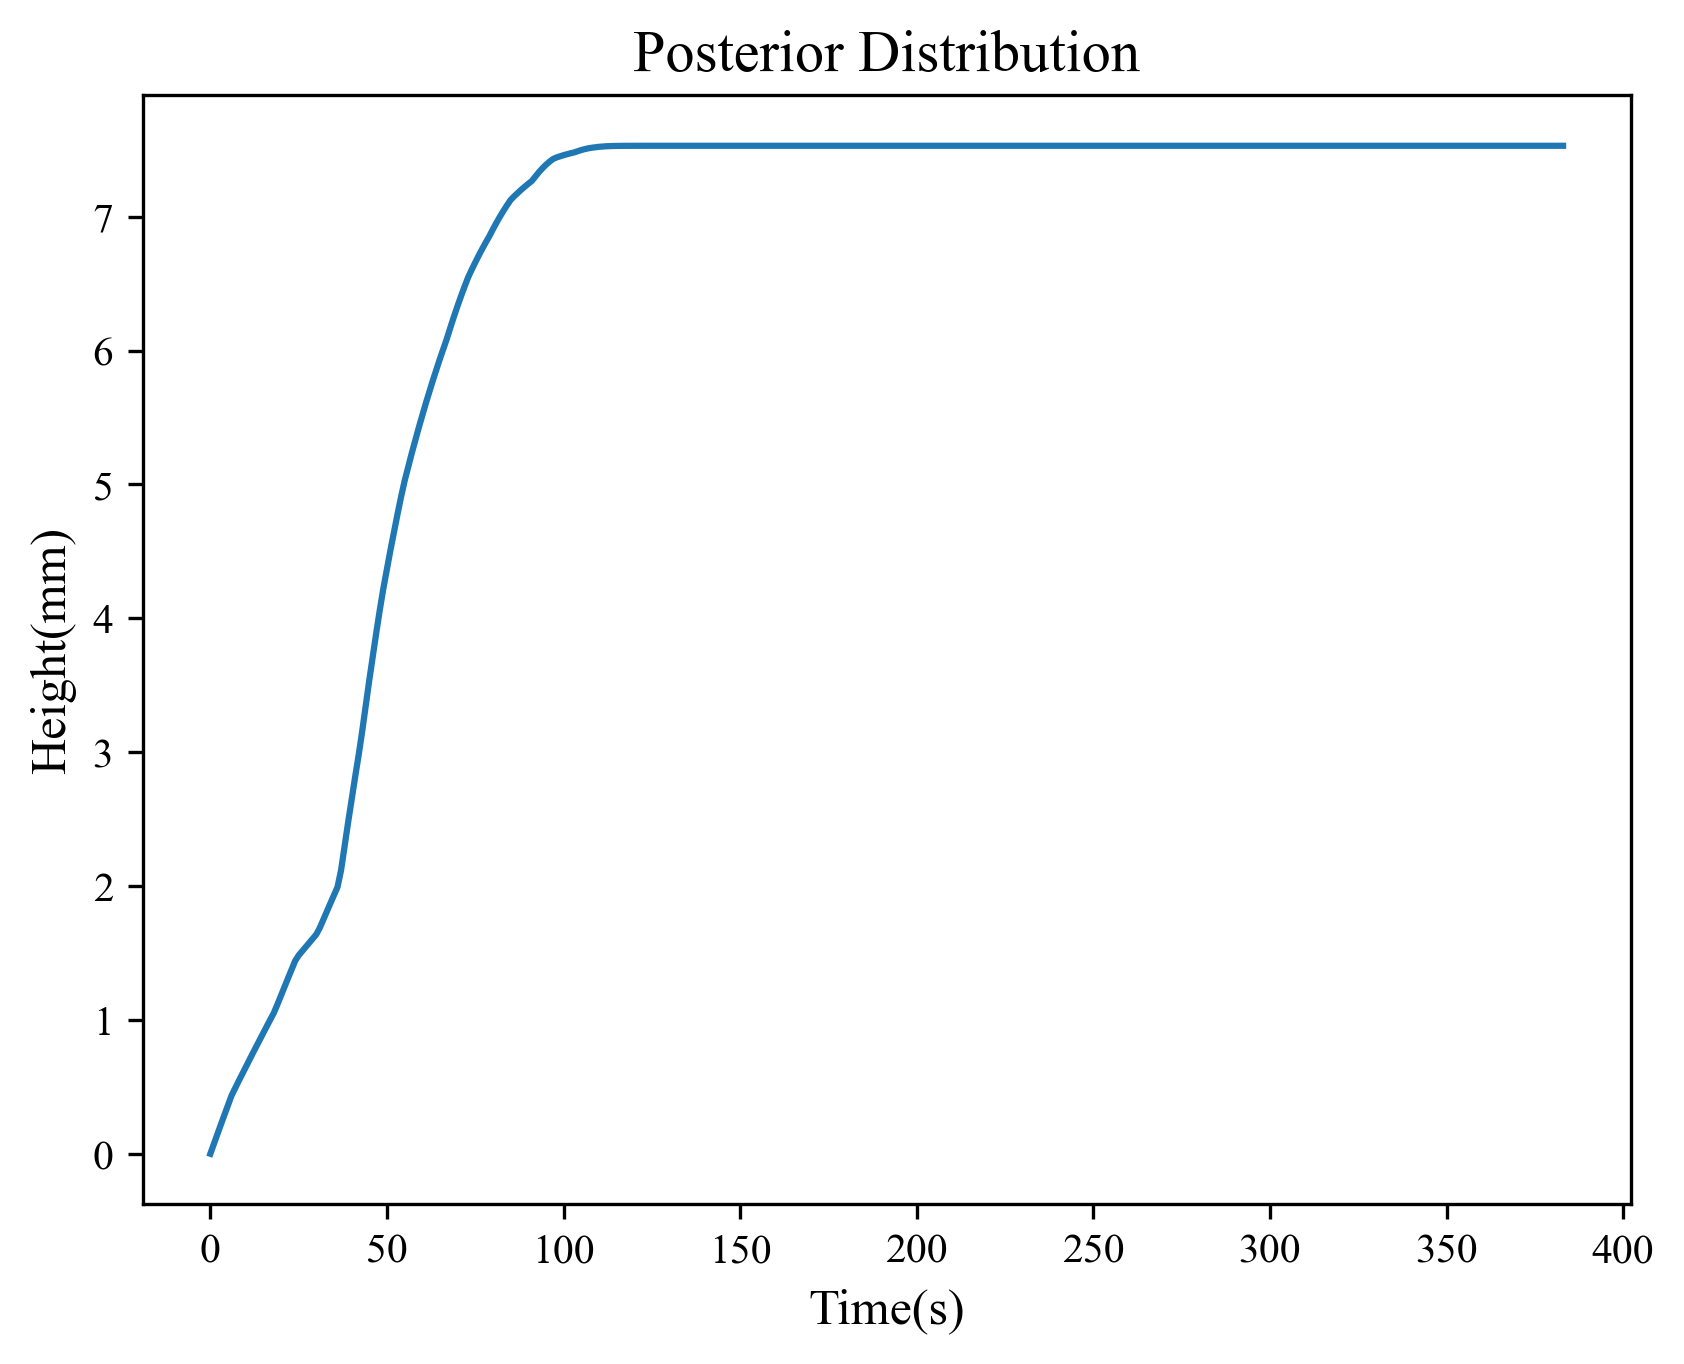

In [56]:
# Plot pushforward distribution
for i in range(len(Push_forward_of_Posterior)):
    plt.plot(Push_forward_of_Posterior[i])

plt.xlabel('Time(s)')
plt.ylabel('Height(mm)')
plt.title("Posterior Distribution")
plt.plot()
plt.show()

In [57]:
labels = ['1','2','3','4','5','6','7','8','9','10','11','12']
def plot_normal(mu = 0, sigma=1, label = labels , title ='Normal Distribution'):
    mu = np.array(mu).reshape(-1,1)
    if len(mu)>1:
        clr = ['b','r','g','k','yellow','orange','pink']
        mu = mu.reshape(-1)
        x_vals = []
        pdf_vals =[]
        for i in range(len(mu)):
            x_i = np.linspace(mu[i] - 4*sigma[i], mu[i] + 4*sigma[i], 1000)
            pdf_i = 1/(sigma[i] * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x_i - mu[i])/sigma[i])**2)
            integral = np.trapz(pdf_i, x_i)
#             print(integral)
            pdf_i = pdf_i / integral
            x_vals.append(x_i)
            pdf_vals.append(pdf_i)
            
        # Create a plot of the normal distribution
        fig, ax = plt.subplots()
        for i in range(len(x_vals)):
            ax.plot(x_vals[i], pdf_vals[i], color=clr[i], lw=2, label = label[i])
        ax.set_xlabel('$\lambda$')
        ax.set_ylabel('PDF')
        ax.set_title(title)
        ax.legend()
        plt.show()    
    
    else:
        mu = mu.reshape(-1)
        x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
        pdf = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu)/sigma)**2)
        integral = np.trapz(pdf, x)
        pdf = pdf / integral
        
          # Create a plot of the normal distribution
        fig, ax = plt.subplots()
        ax.plot(x, pdf, color=color, lw=2)
        ax.set_xlabel('$\lambda$')
        ax.set_ylabel('PDF')
        ax.set_title(title)
        plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_9628\2750339013.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  pdf_i = 1/(sigma[i] * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x_i - mu[i])/sigma[i])**2)
C:\Users\USER\AppData\Local\Temp\ipykernel_9628\2750339013.py:11: RuntimeWarning: invalid value encountered in divide
  pdf_i = 1/(sigma[i] * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x_i - mu[i])/sigma[i])**2)


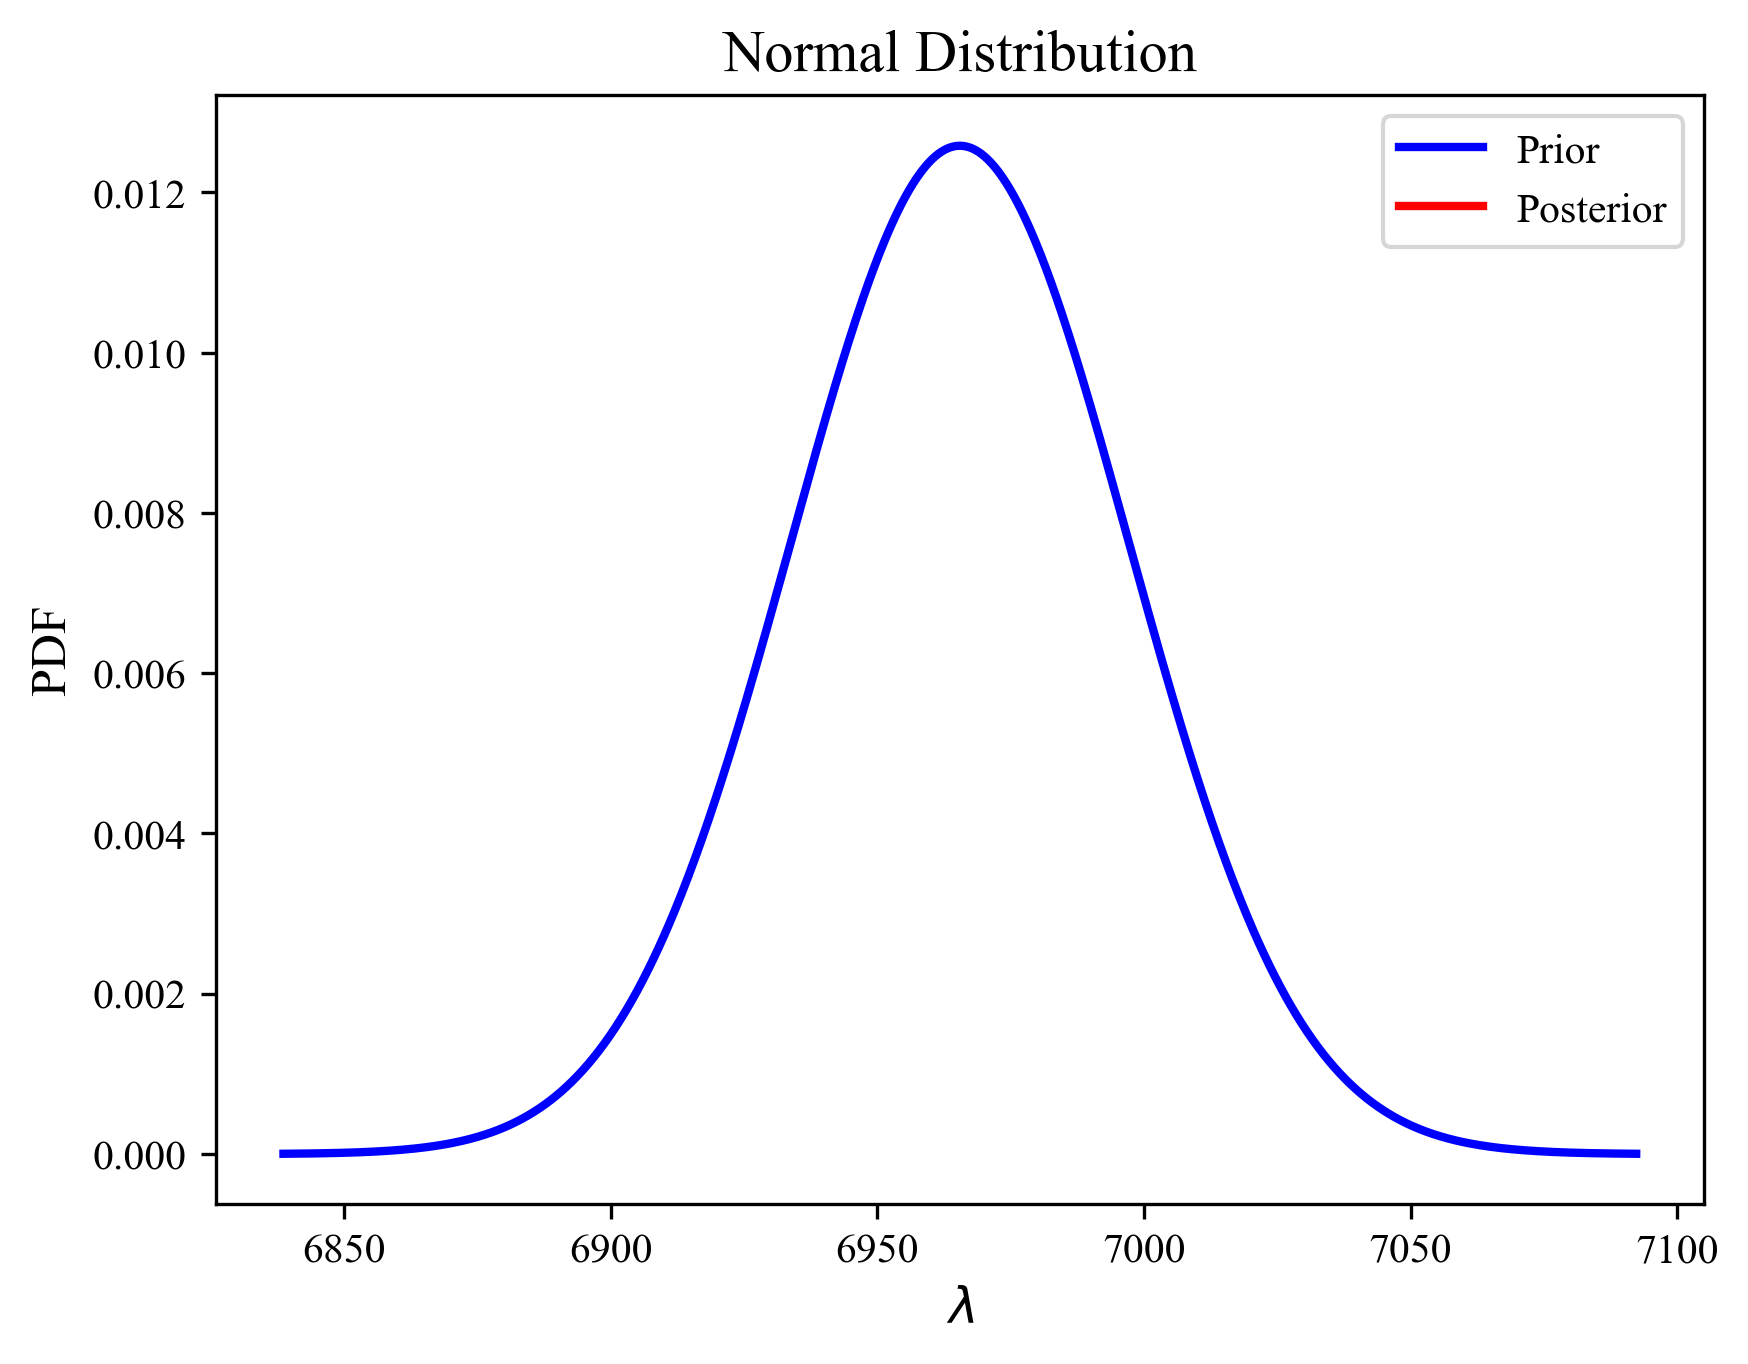

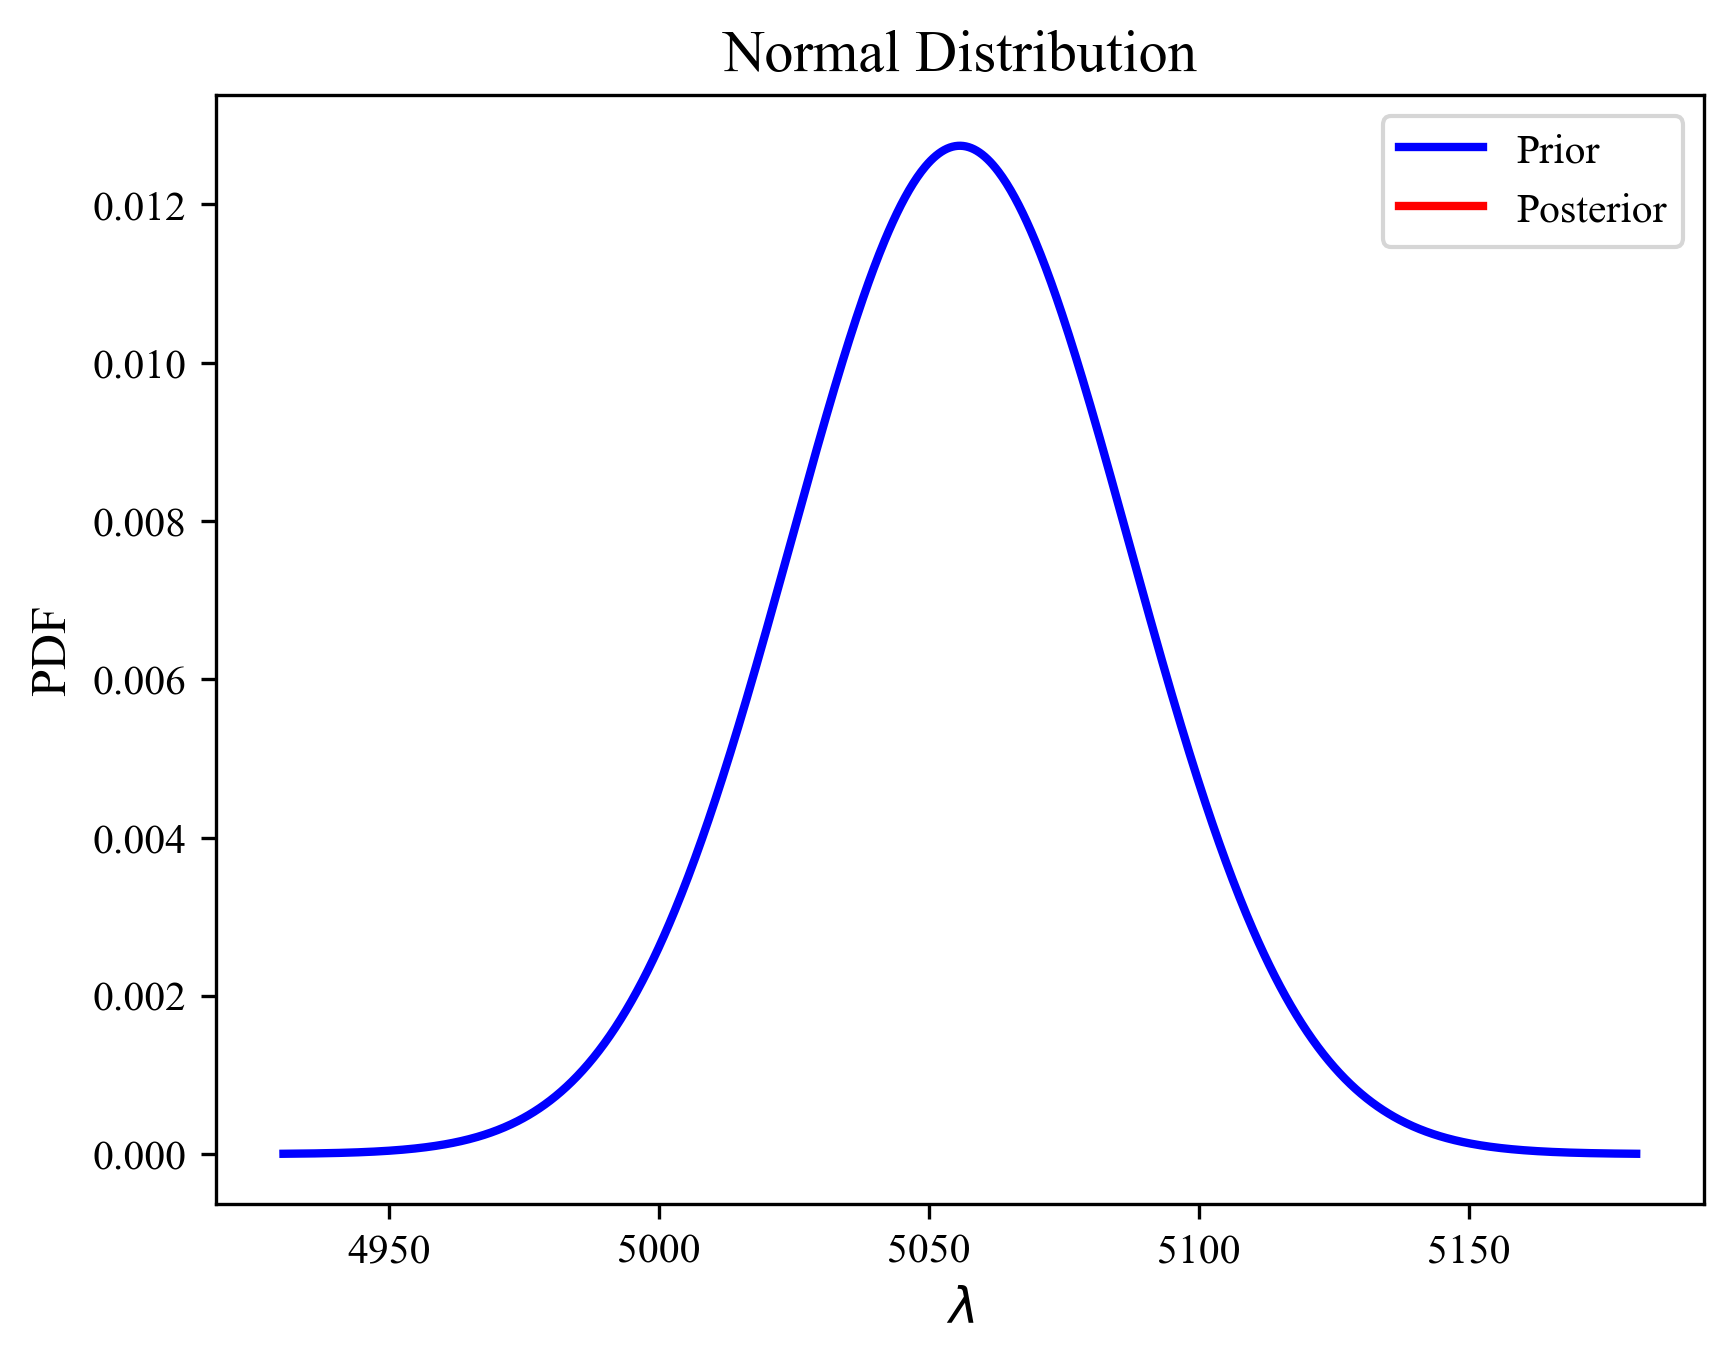

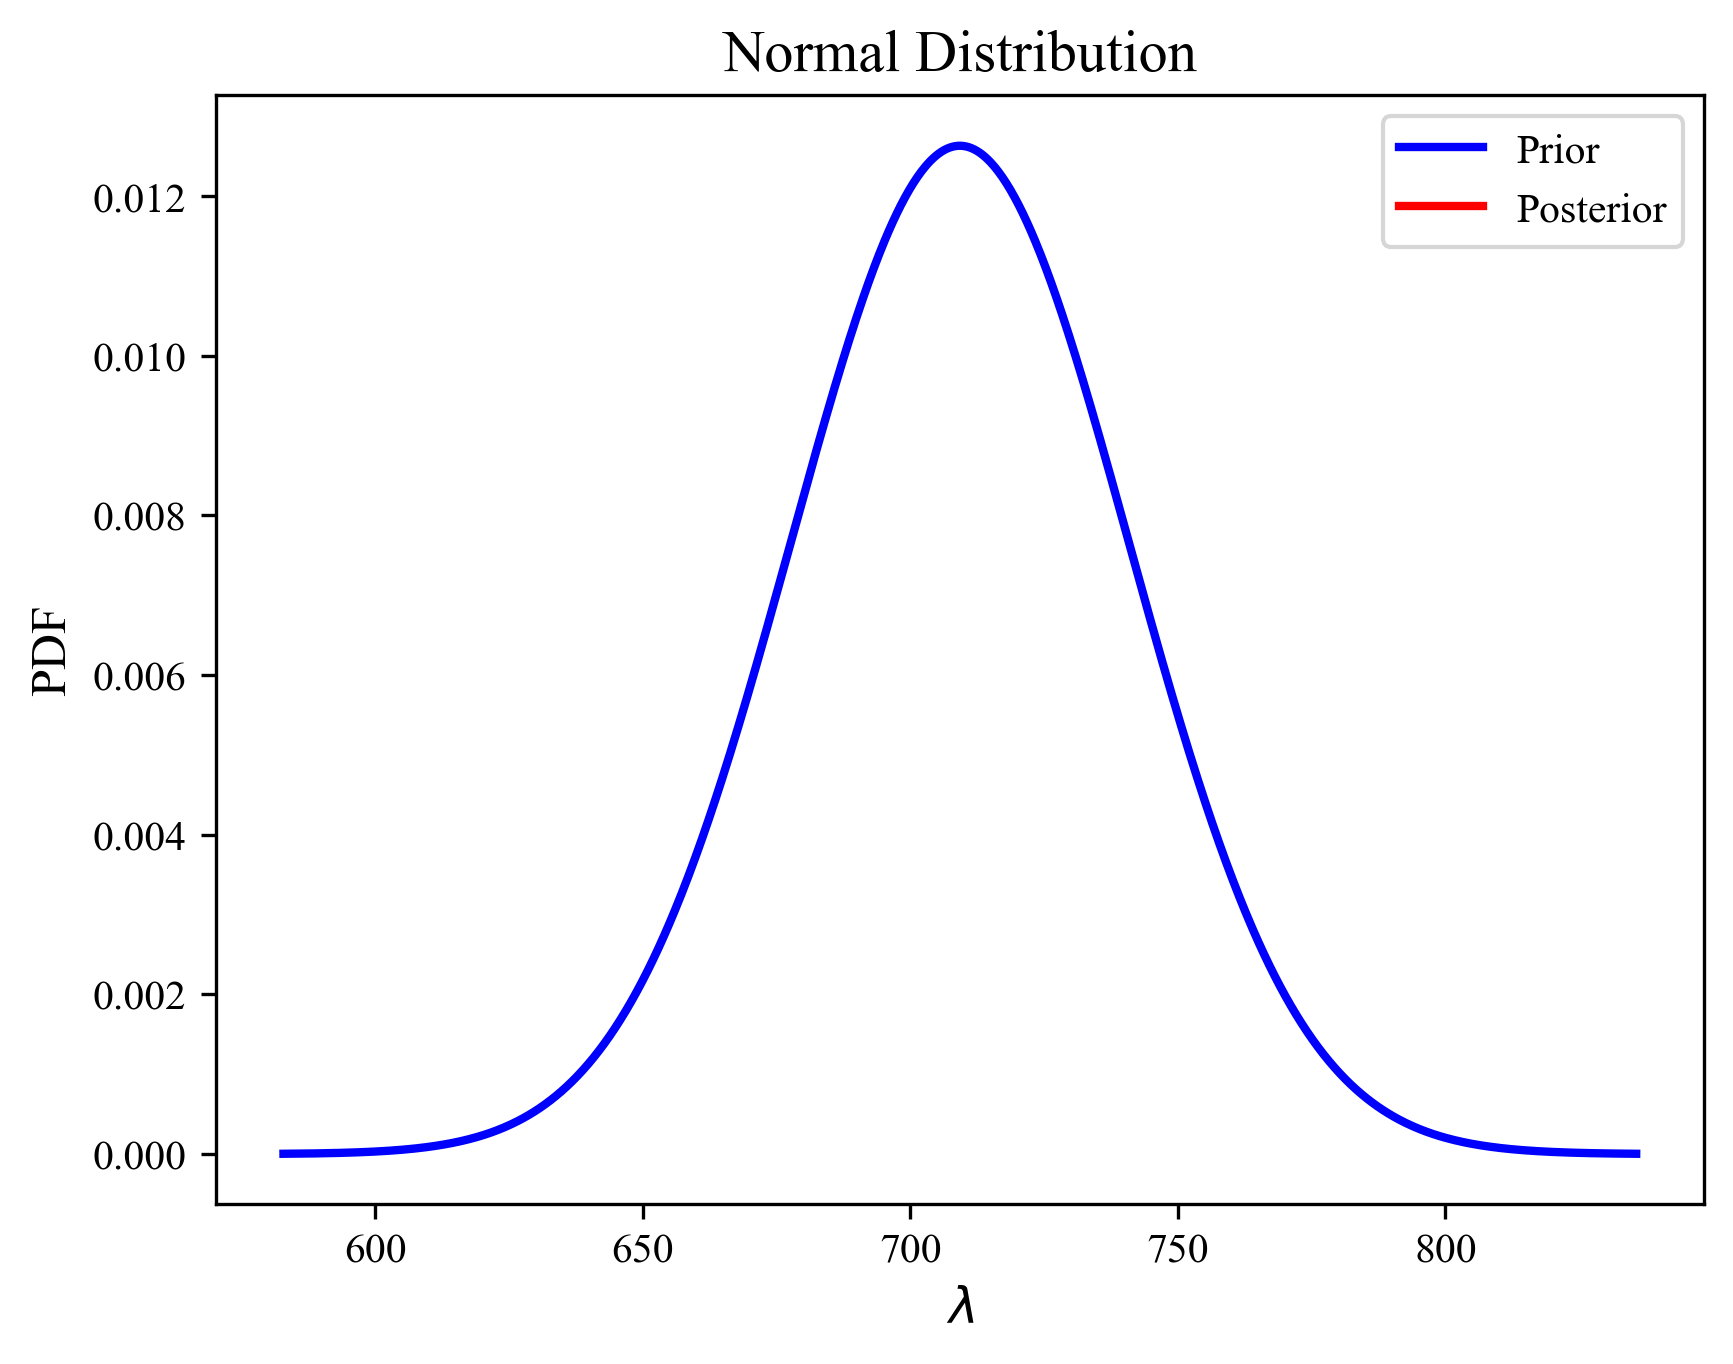

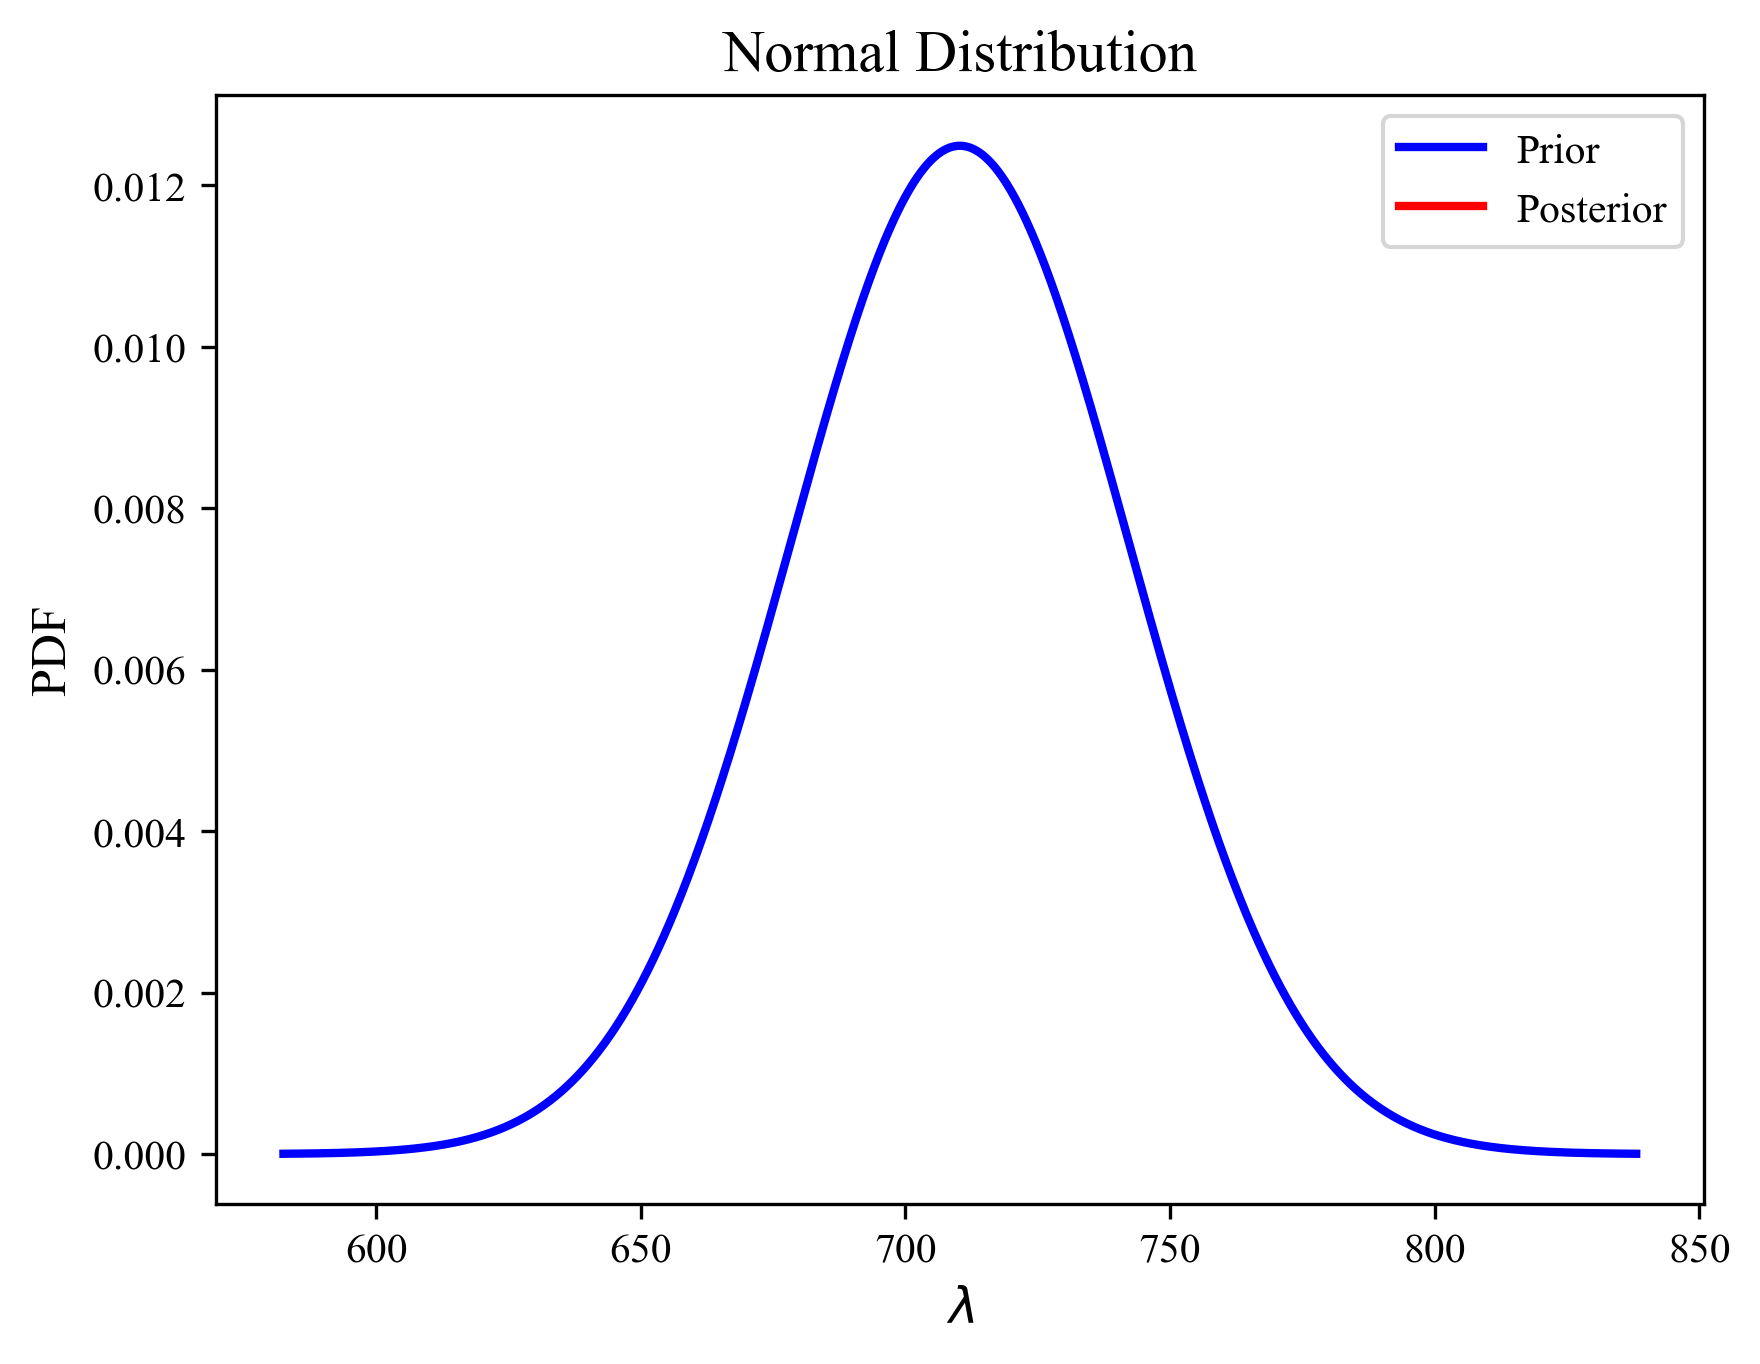

In [58]:

n=Accepted_lamda.shape[0]
for i in range(4):
    labels = ['Prior', 'Posterior', 'True']
    pr_vals = Prior_Samples[:,i] 
    ac_vals = Accepted_lamda[:,i]
    
    mu_pr,std_pr = np.mean(pr_vals),np.std(pr_vals)
    mu_ac,std_ac = np.mean(ac_vals),np.std(ac_vals)
    
    mu_gen = np.array([mu_pr,mu_ac])
    std_gen = np.array([std_pr,std_ac])
    plot_normal(mu = mu_gen, sigma=std_gen, label = labels , title ='Normal Distribution')
    

In [59]:
# Posterior_kde
def posterior_kde(X=Push_forward_of_Posterior, dat=Push_forward_of_Posterior ,i=10):
    """Fits a kernel density estimator to the datapoint up until the (i+1)th term"""
    # Fit a kernel density estimator to the KDE_Dataset
    post_kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(dat[:,:i])
    if len(X.shape)<2:
        X=X.reshape(1,-1)
    pds = np.exp(post_kde.score_samples(X[:,:i]))
    return pds

In [60]:
def extract_column_k(Data, k=0):
    combine = []
    for i in range(len(Data)):
        data = Data[i]
        combine.append(data[:,k])
    combine = np.array(combine)
    return combine.T

# p_prior = Push_forward_of_Prior
# p_post = Push_forward_of_Posterior

C:\Users\USER\AppData\Local\Temp\ipykernel_9628\2750339013.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  pdf_i = 1/(sigma[i] * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x_i - mu[i])/sigma[i])**2)
C:\Users\USER\AppData\Local\Temp\ipykernel_9628\2750339013.py:11: RuntimeWarning: invalid value encountered in divide
  pdf_i = 1/(sigma[i] * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x_i - mu[i])/sigma[i])**2)


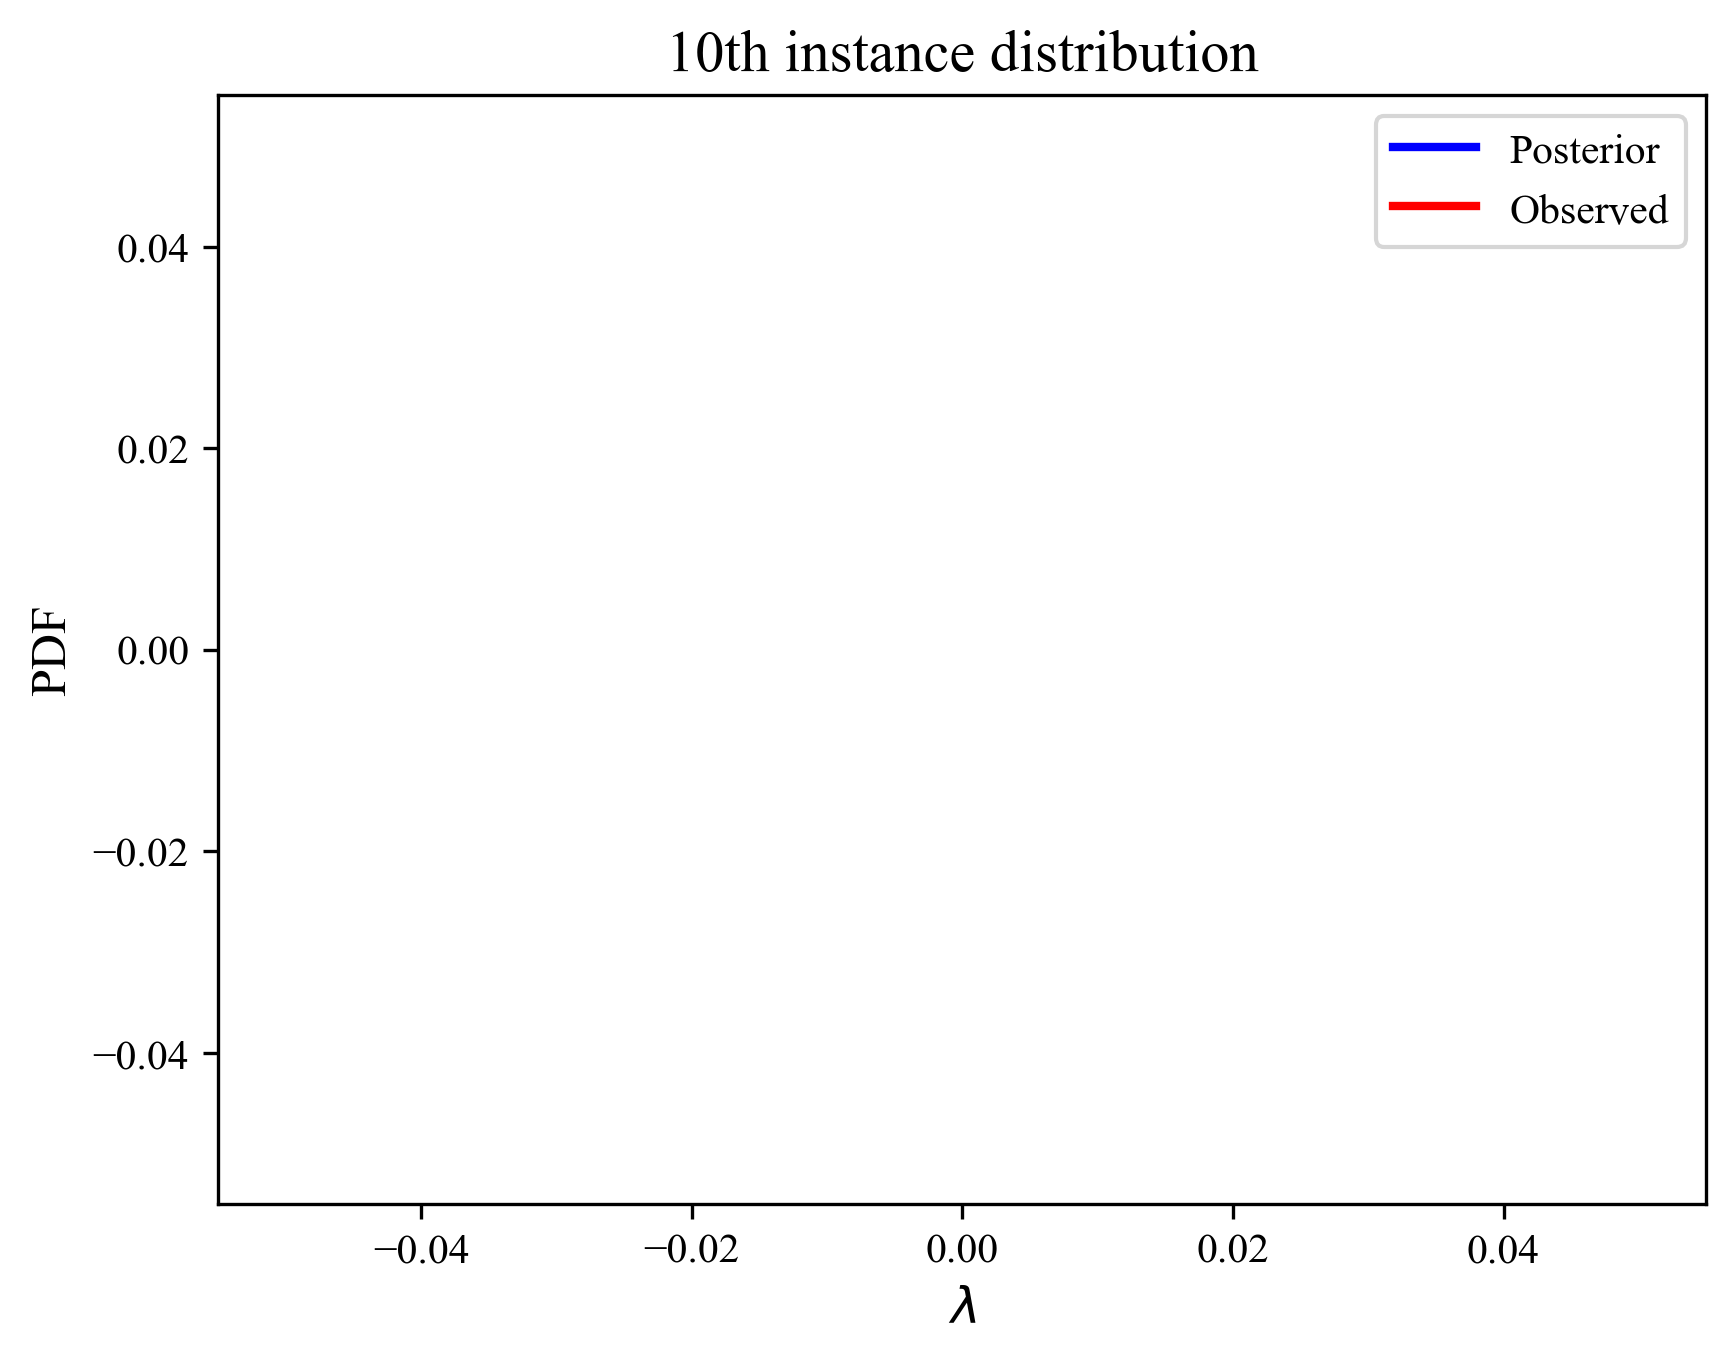

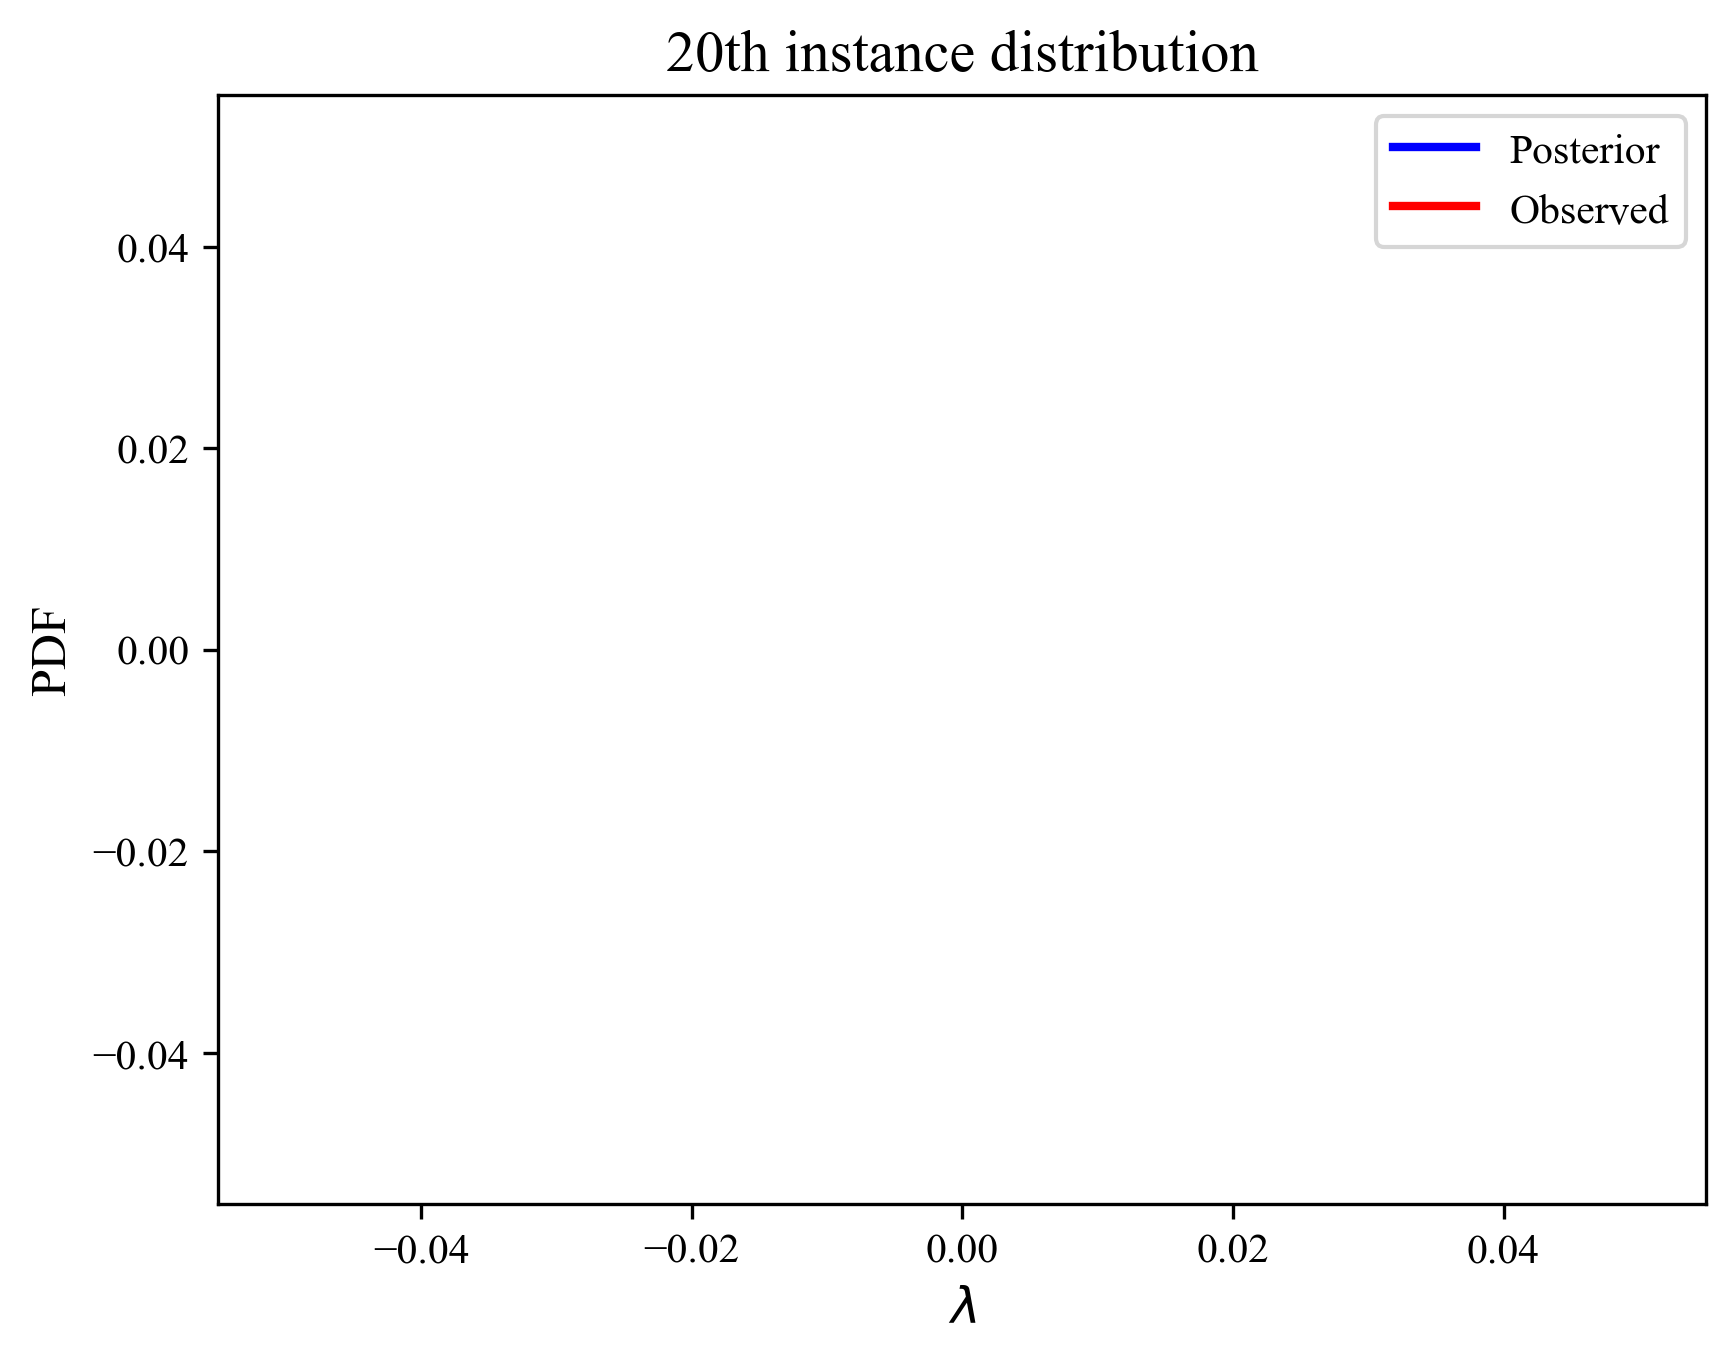

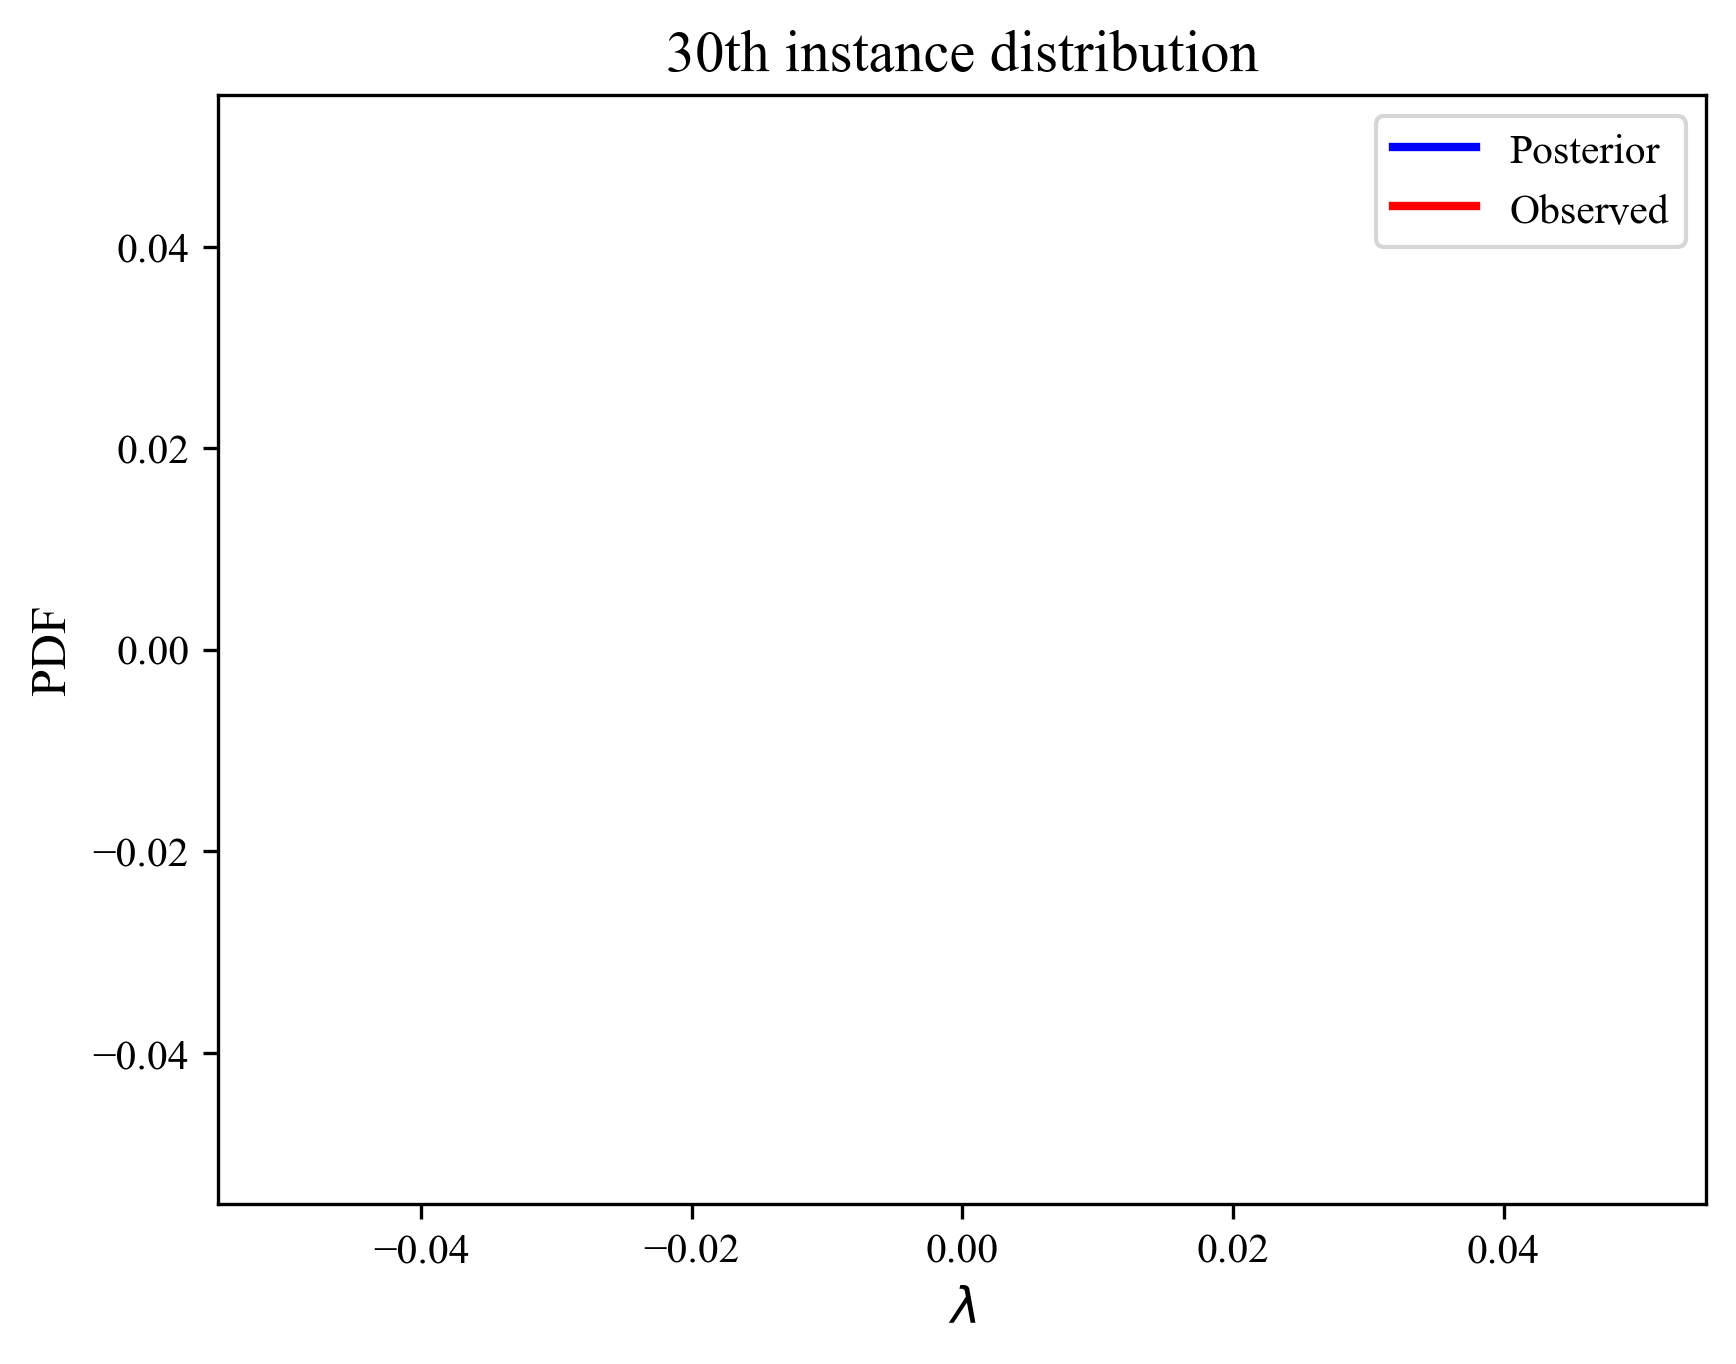

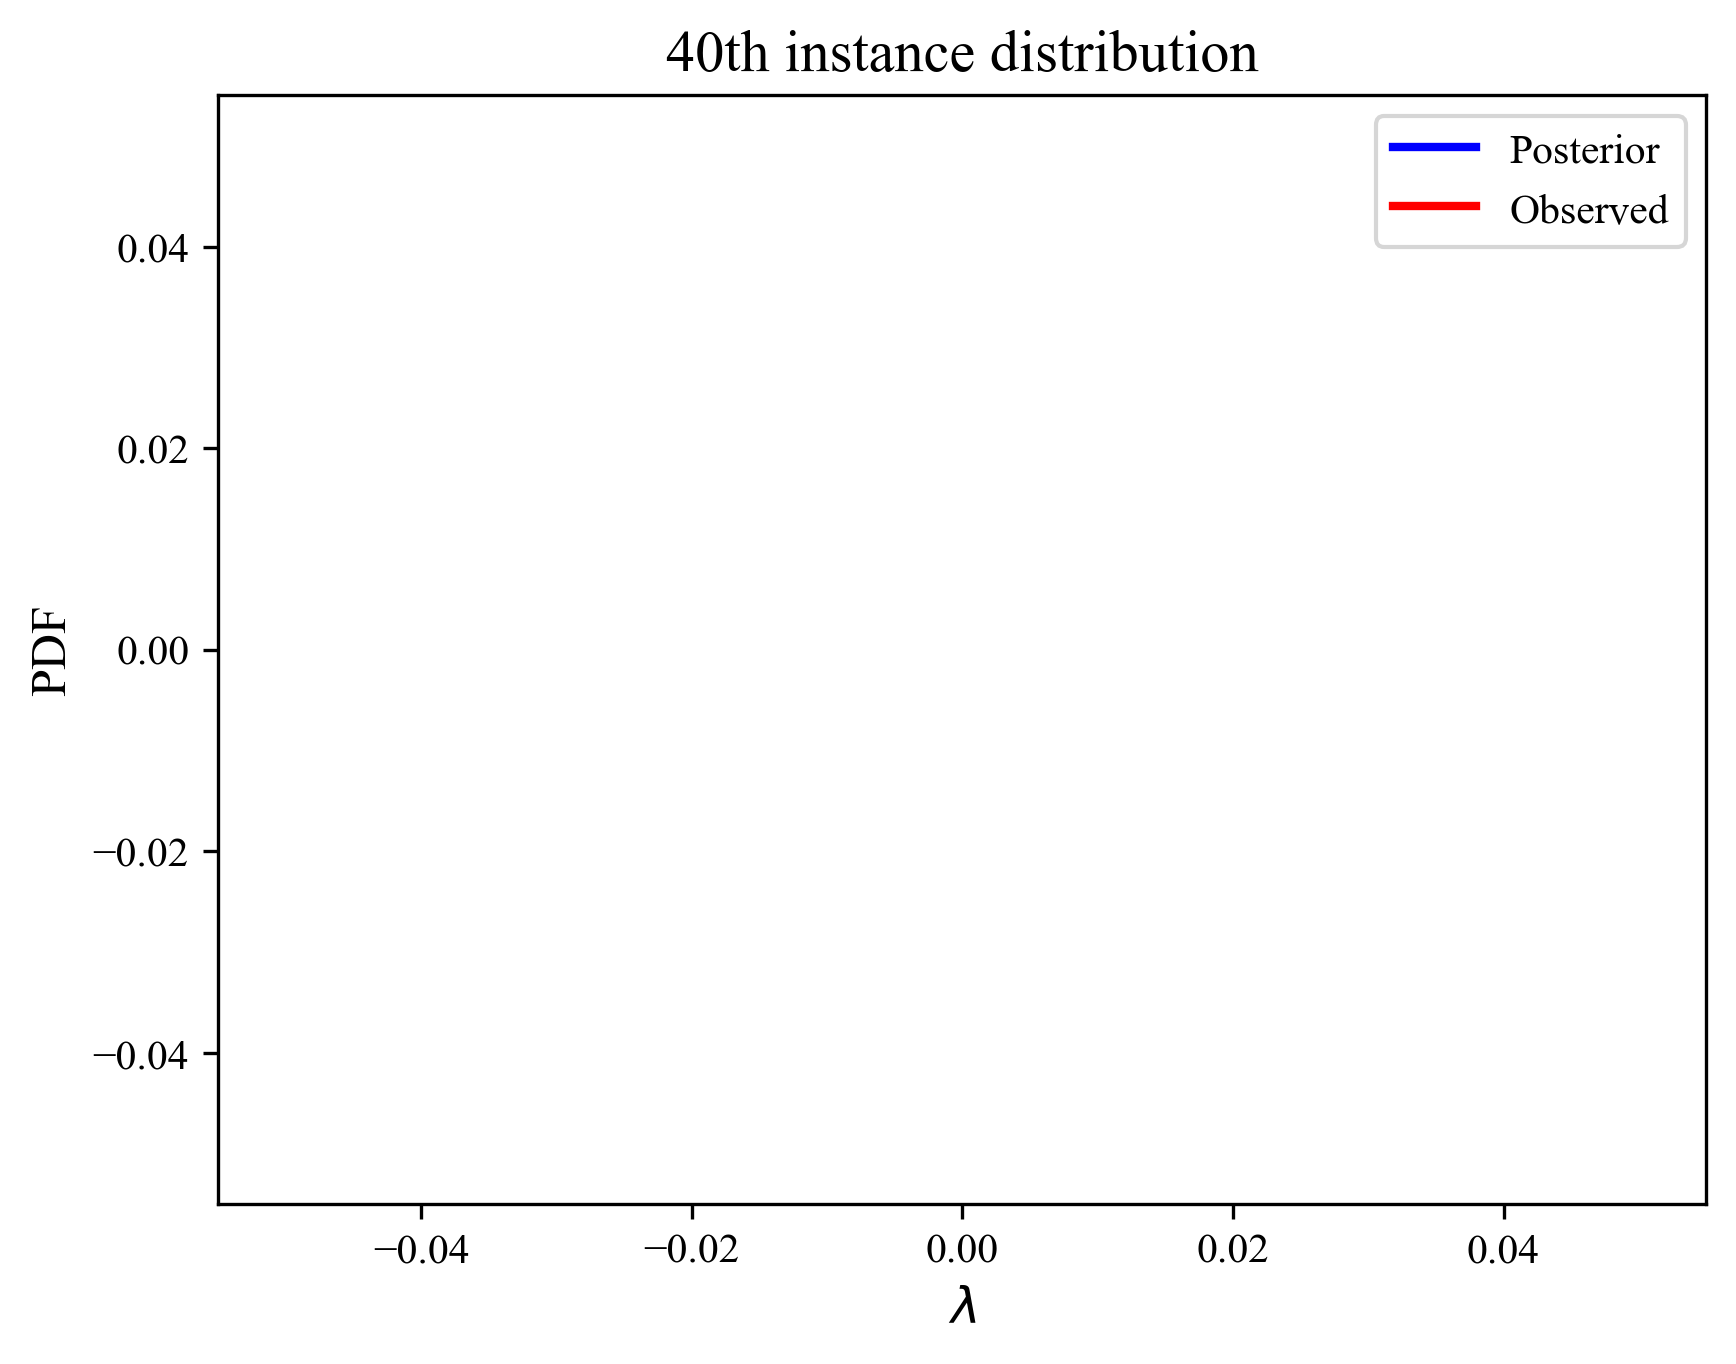

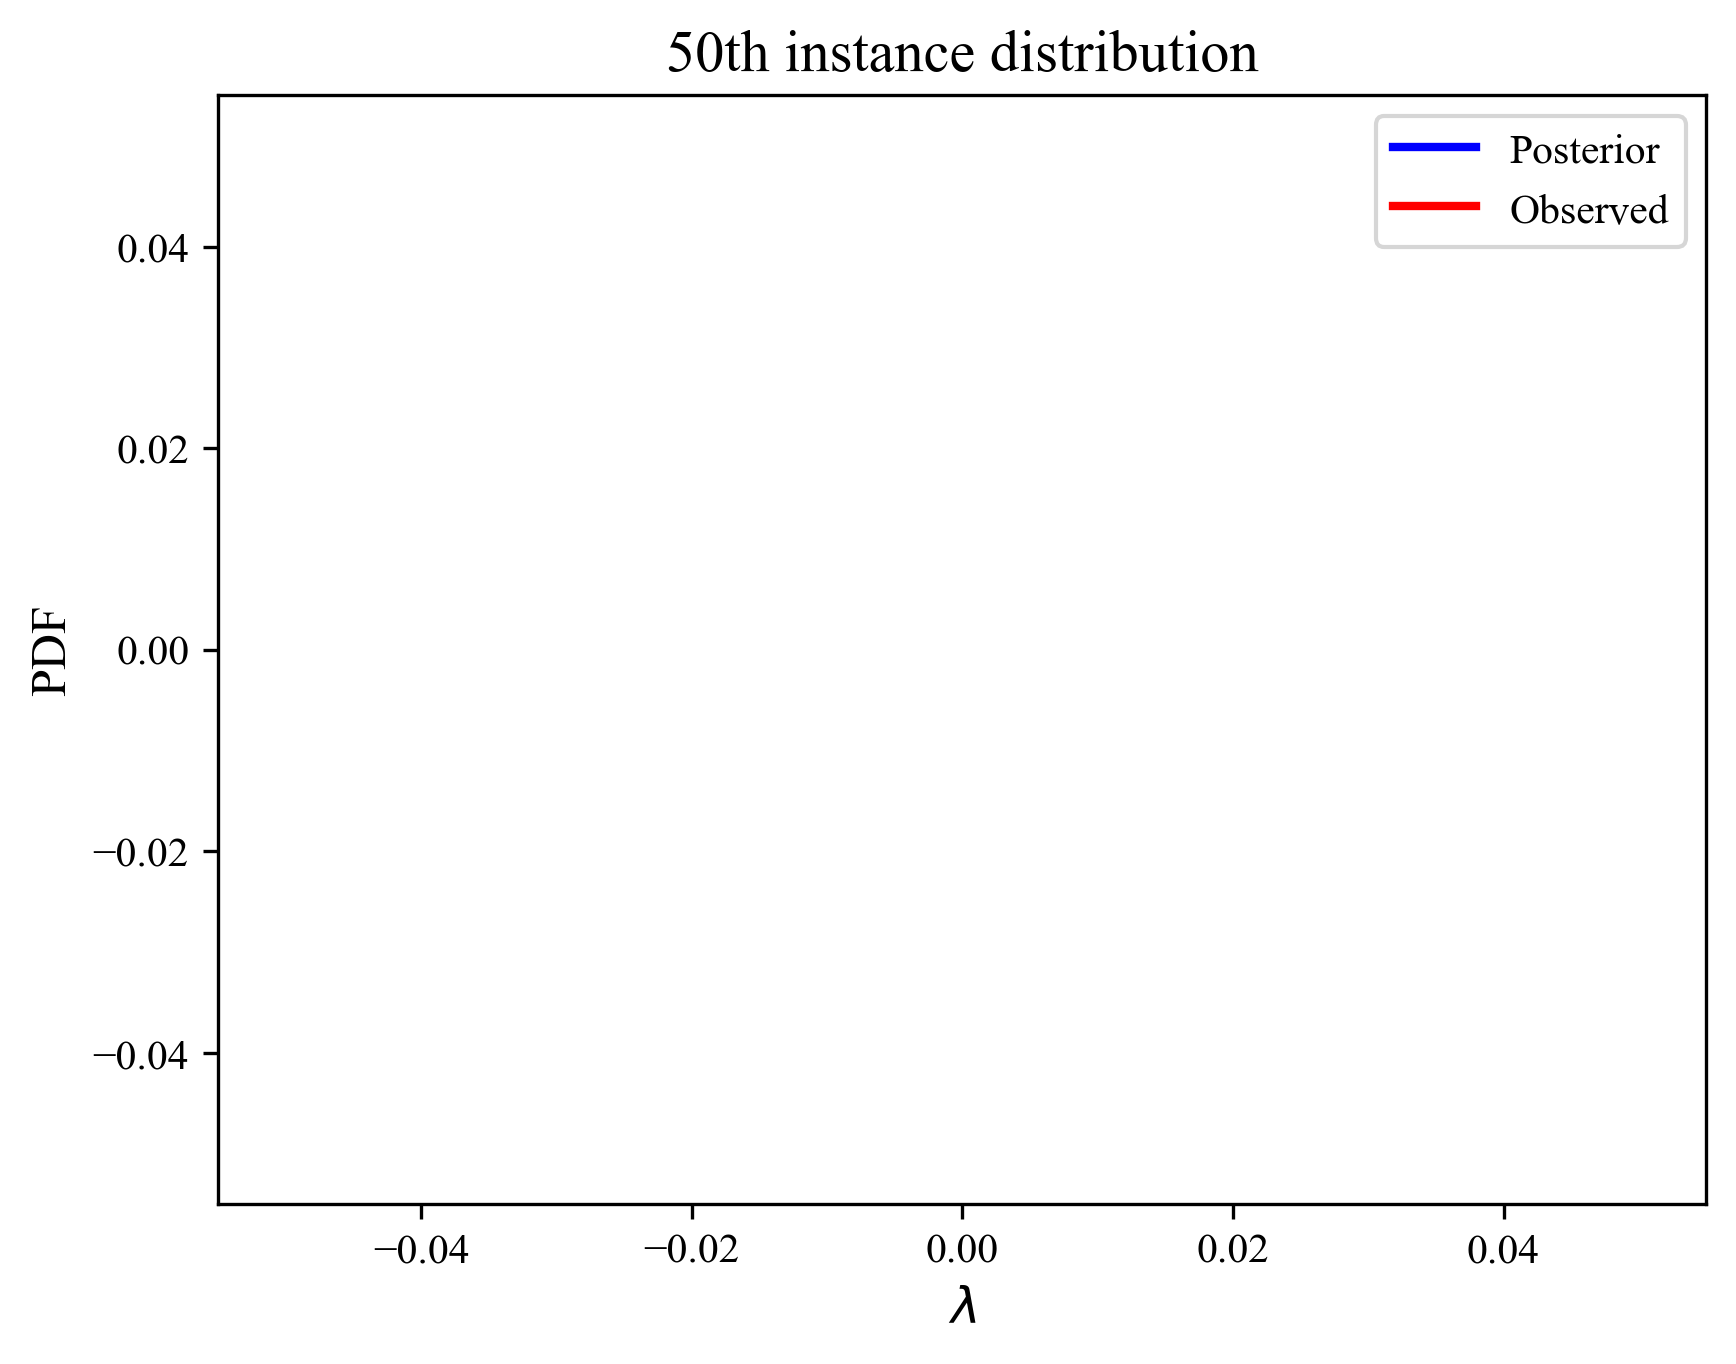

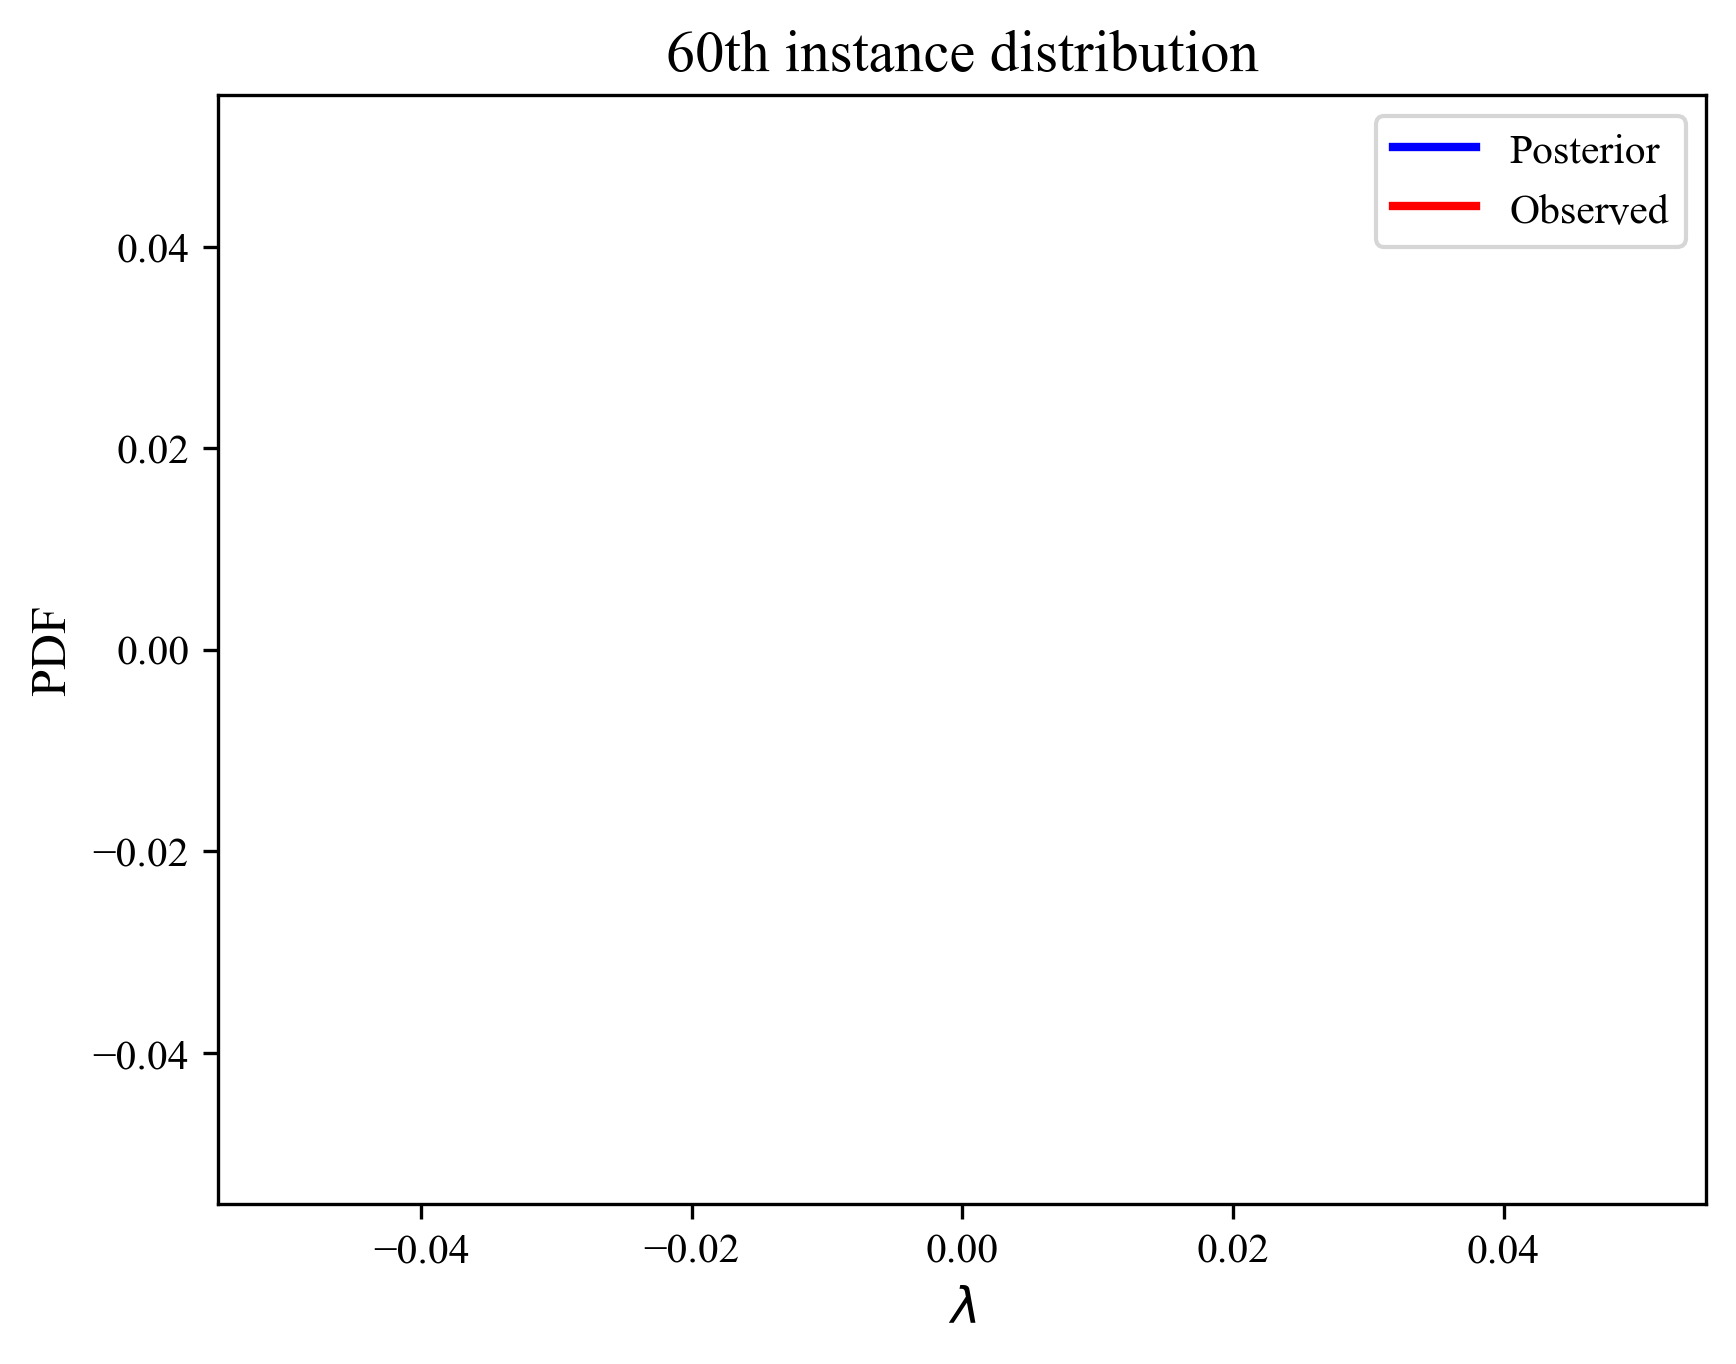

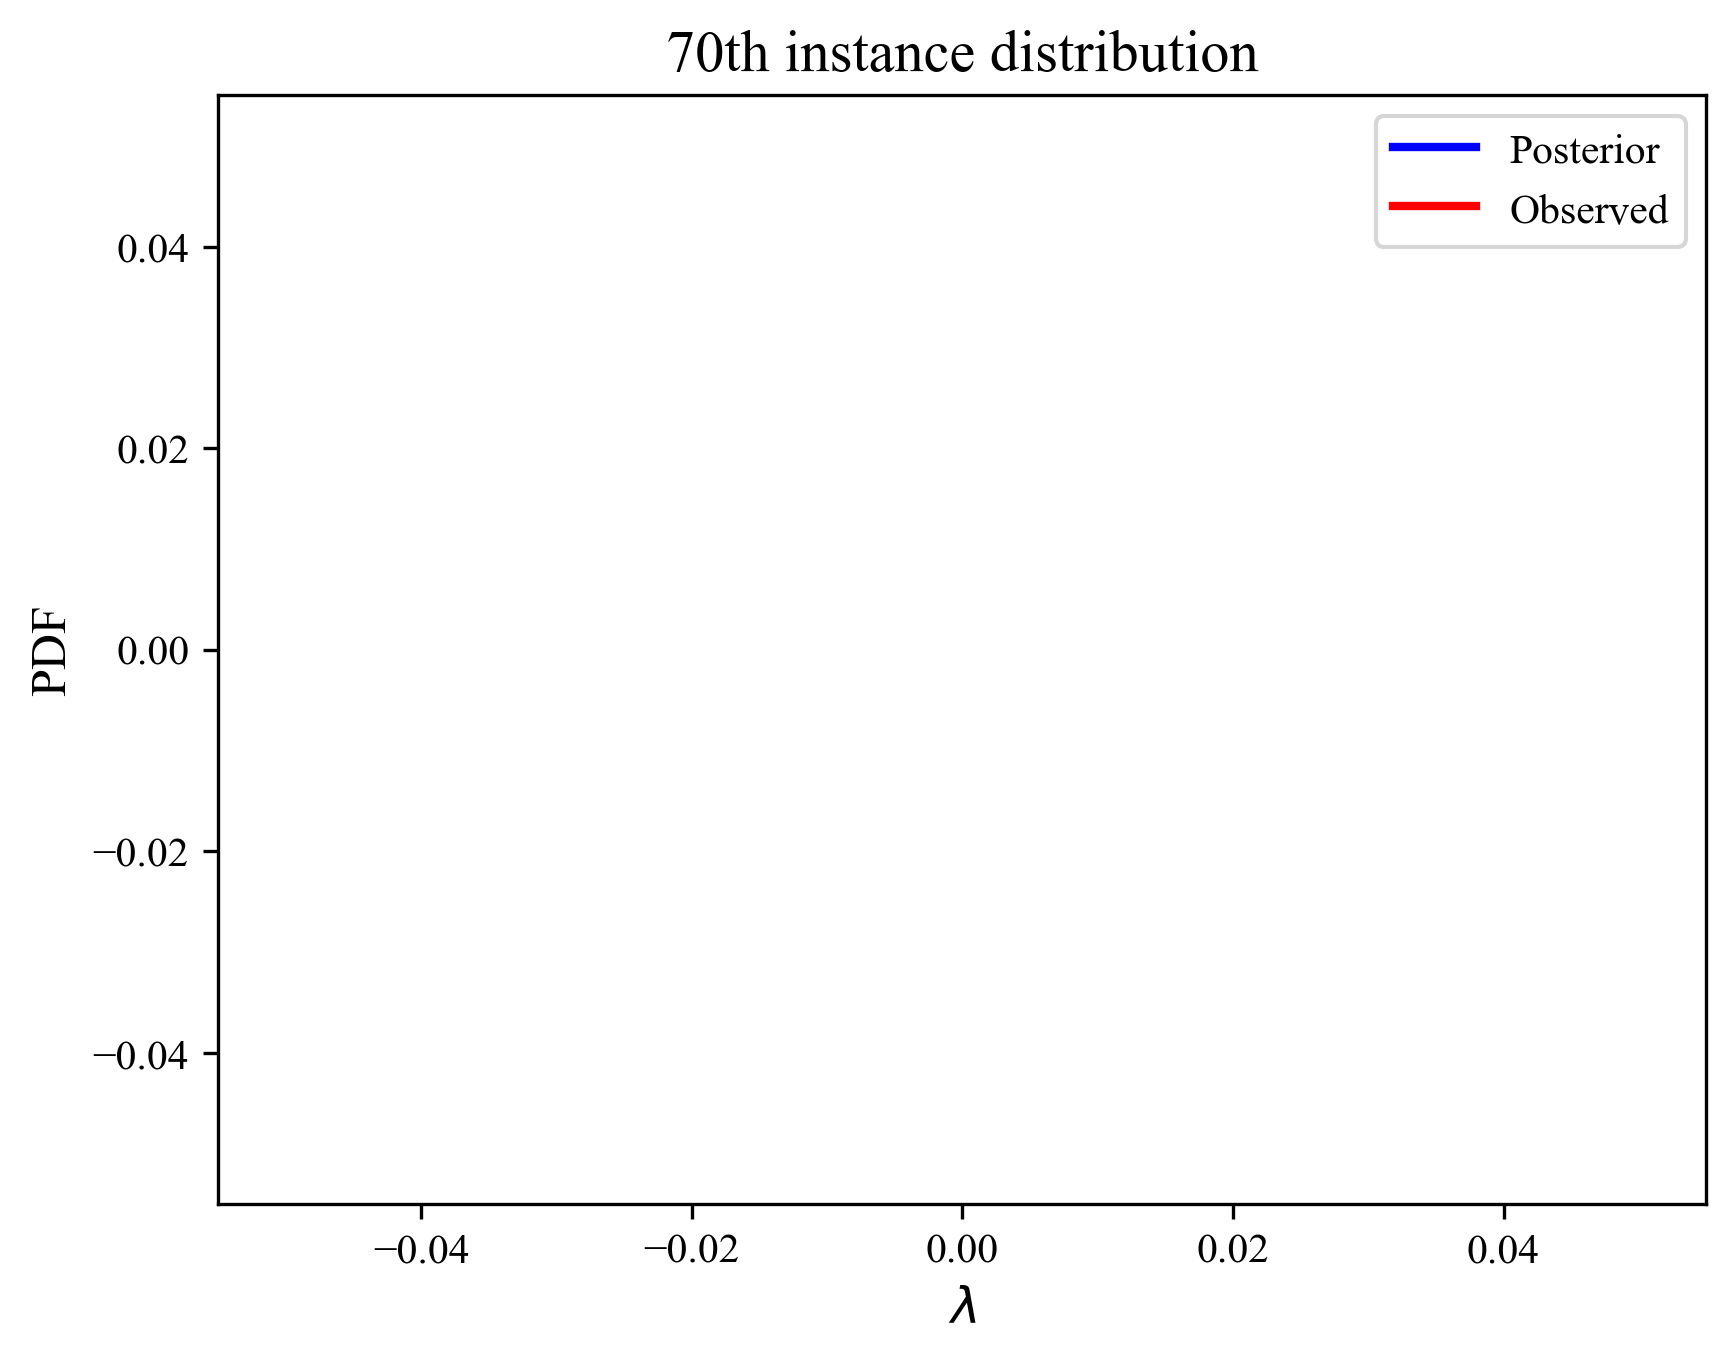

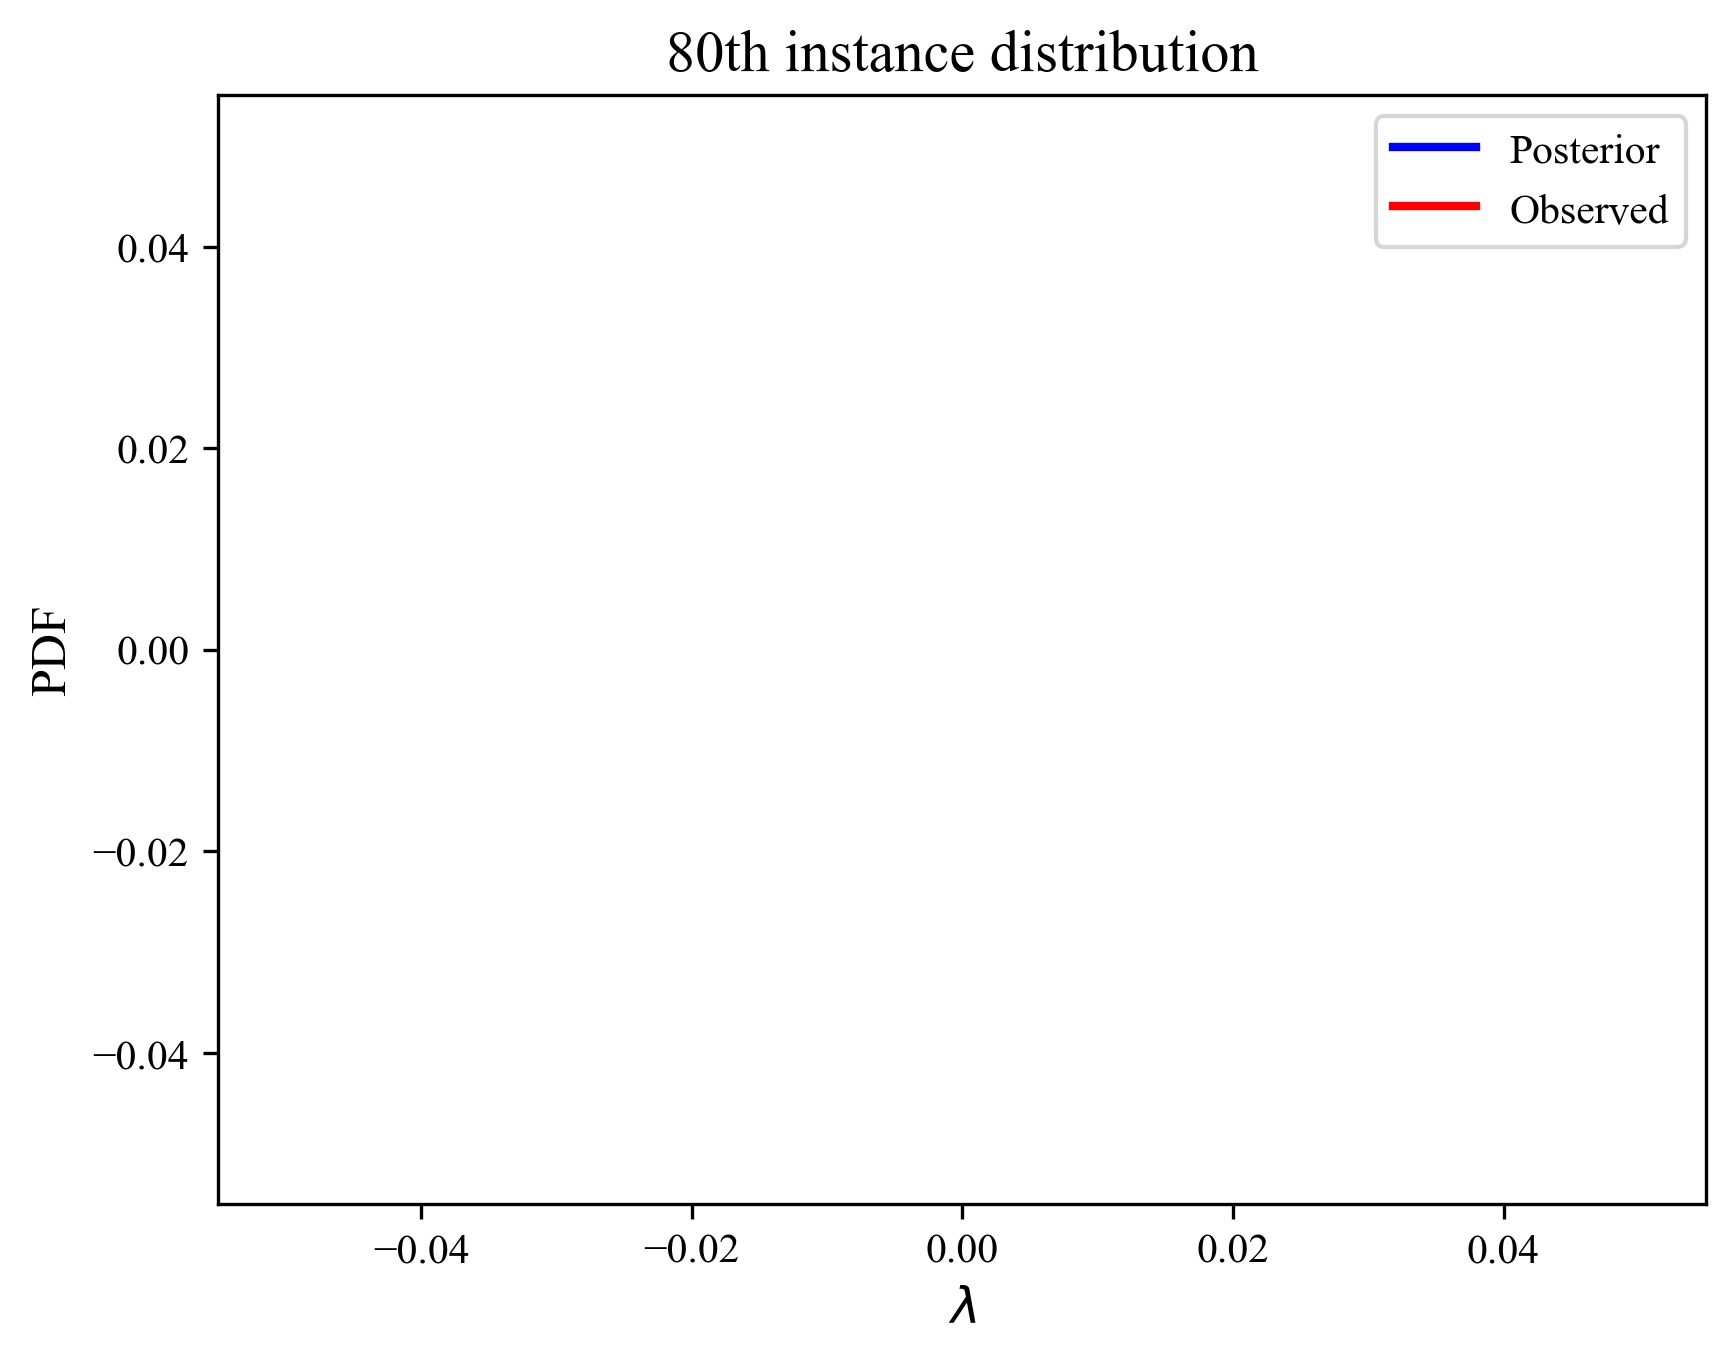

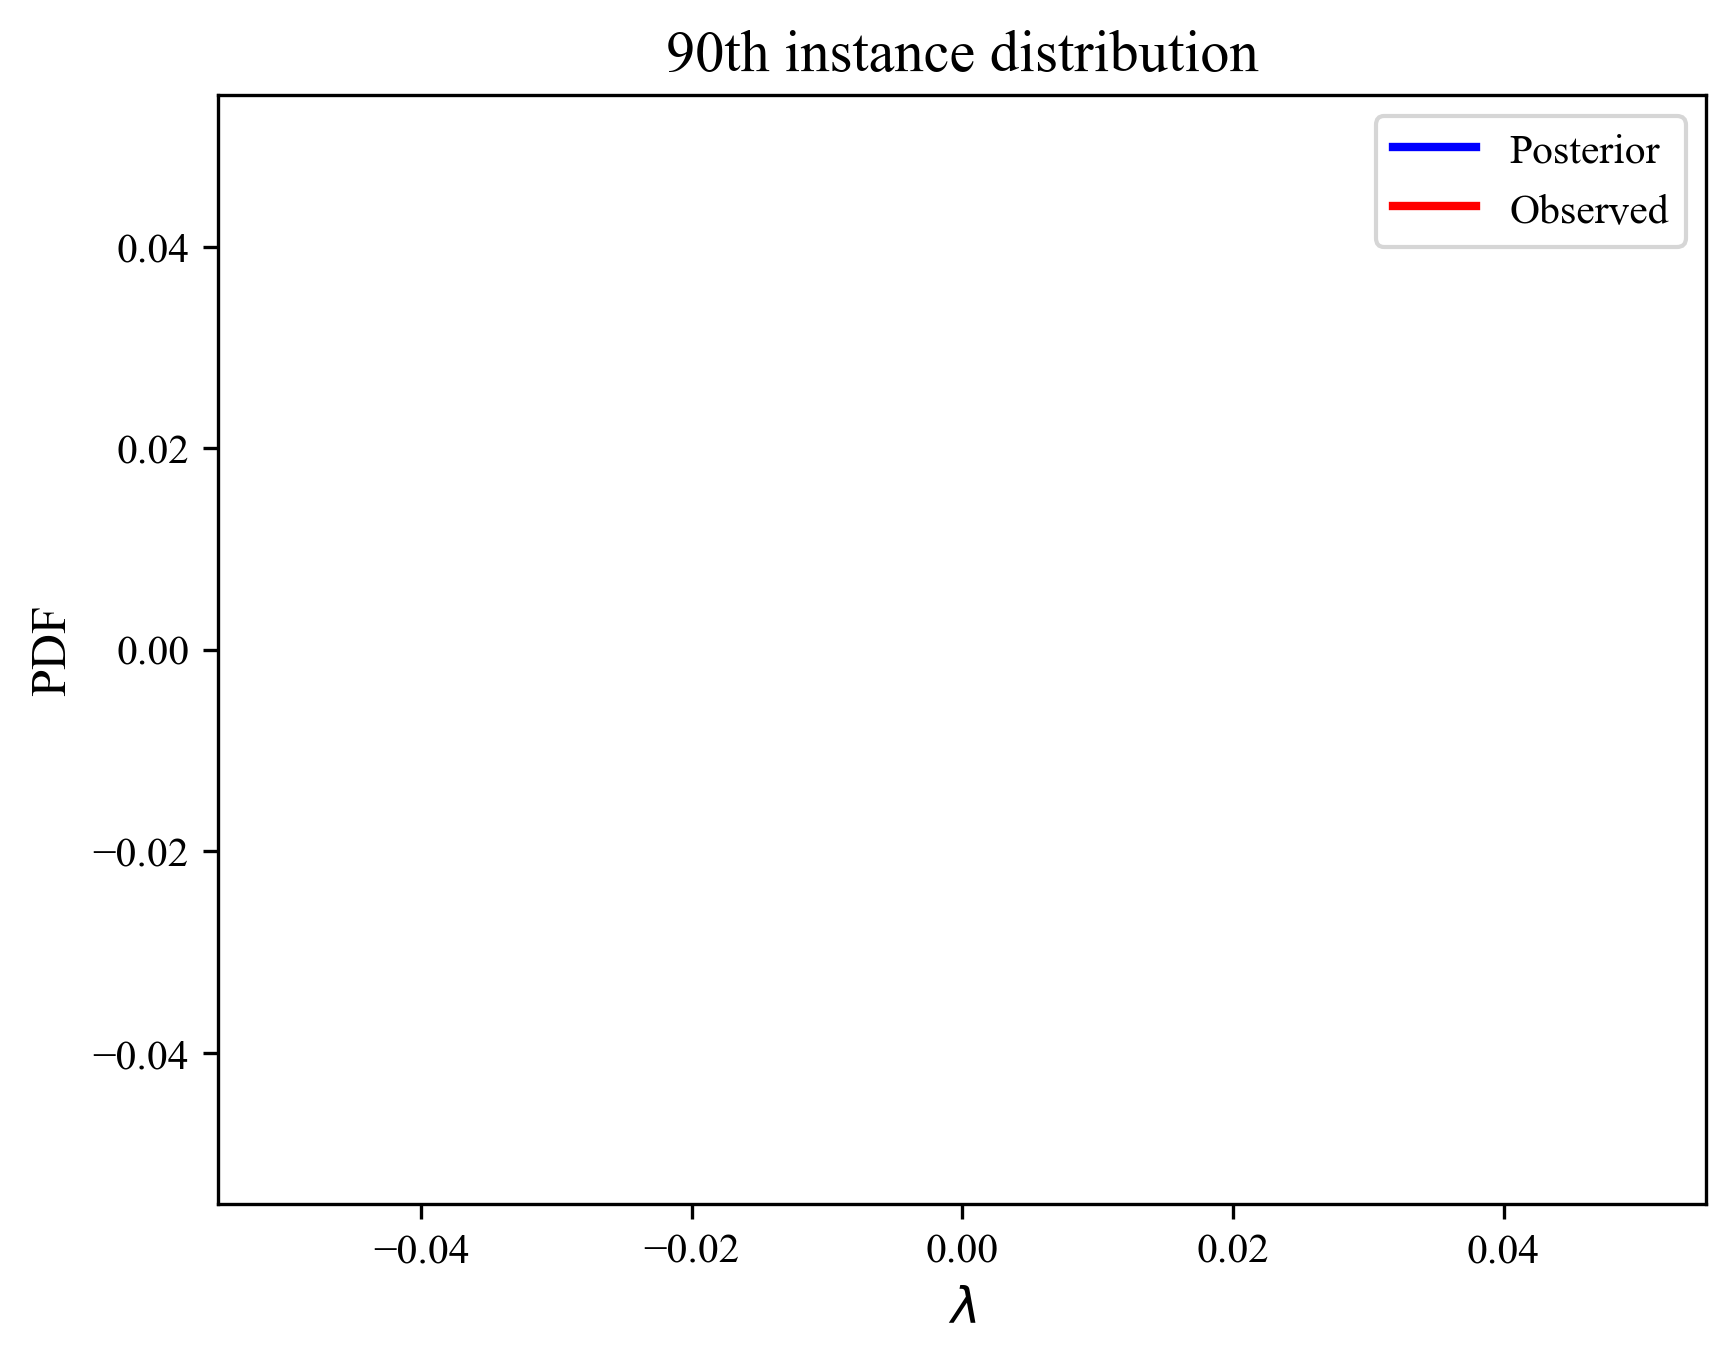

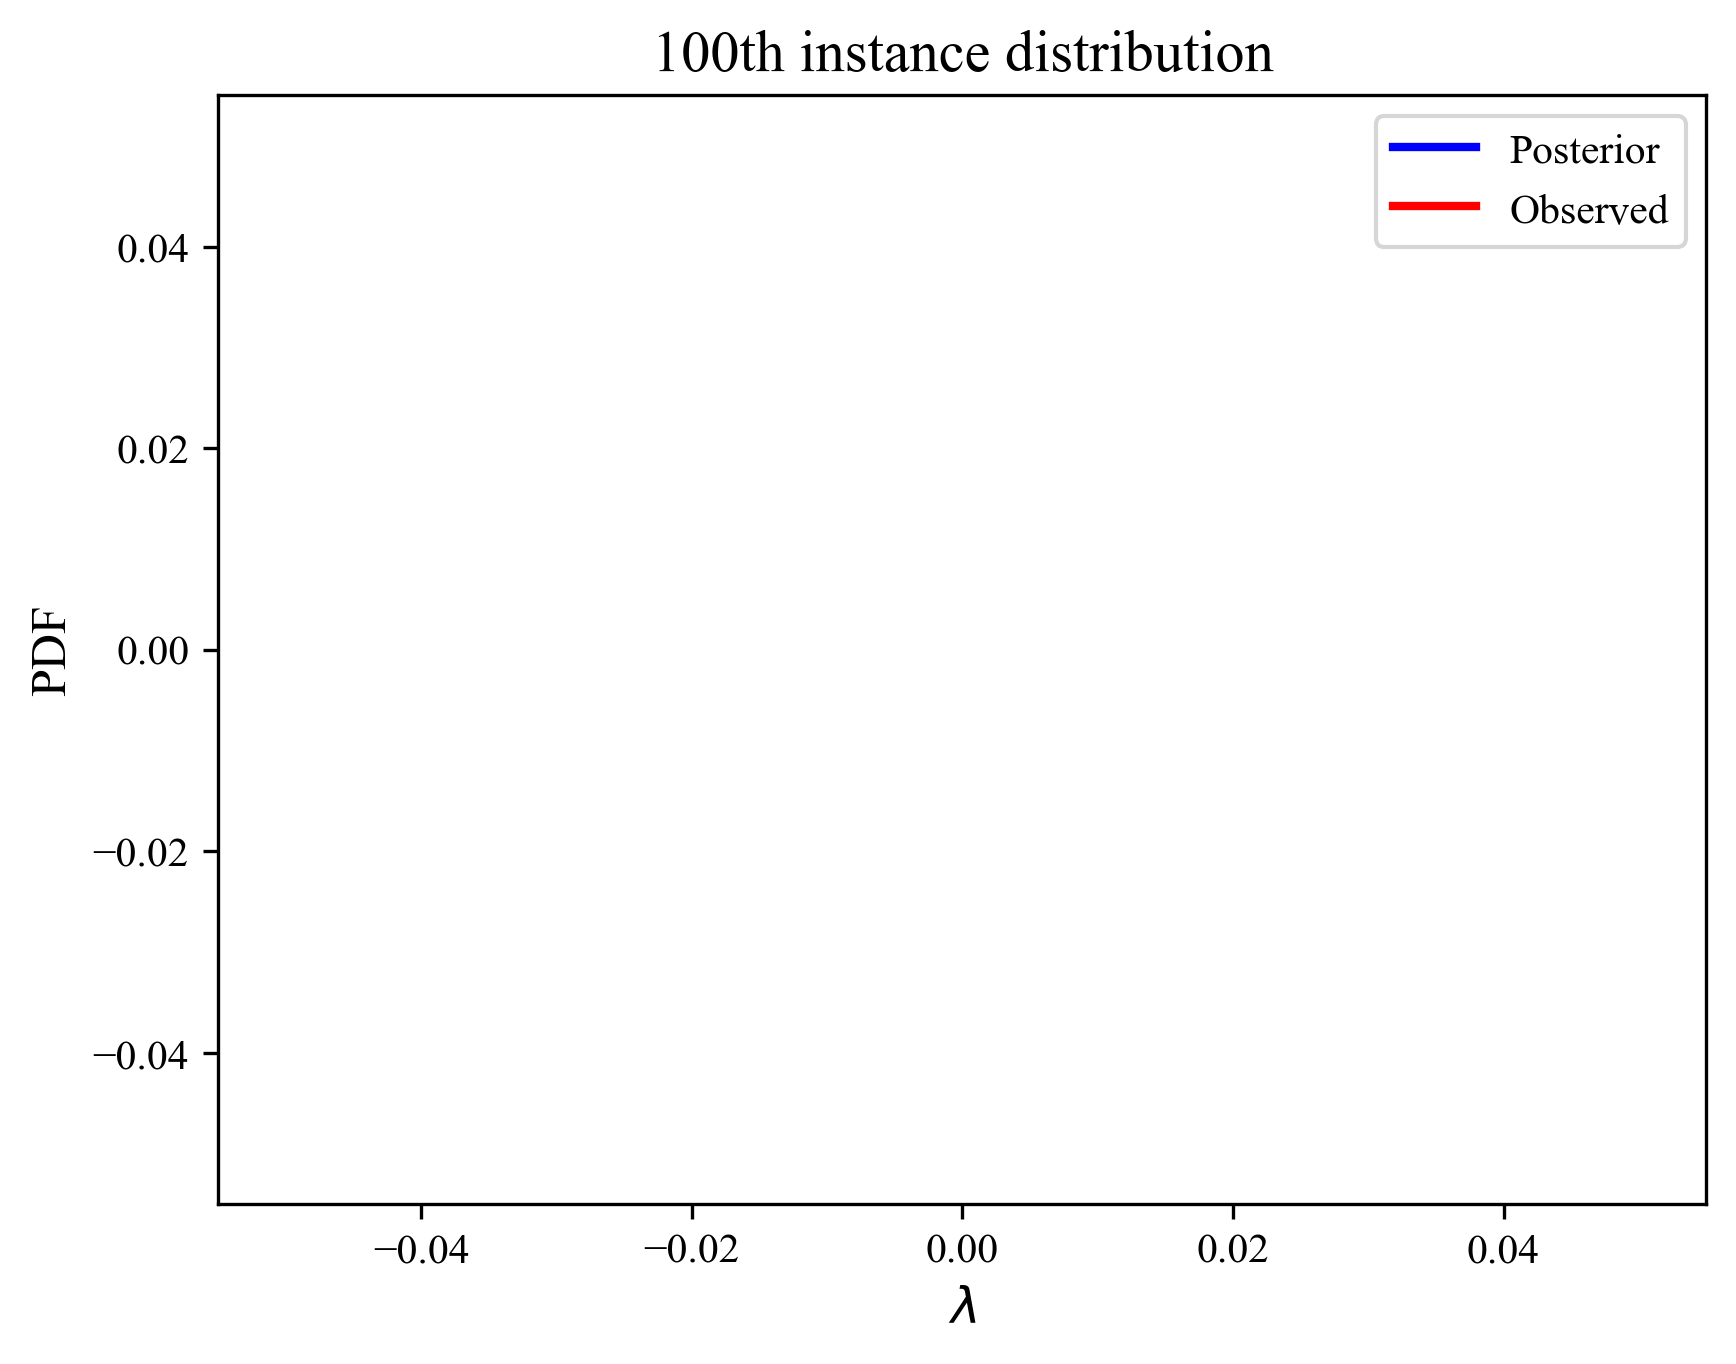

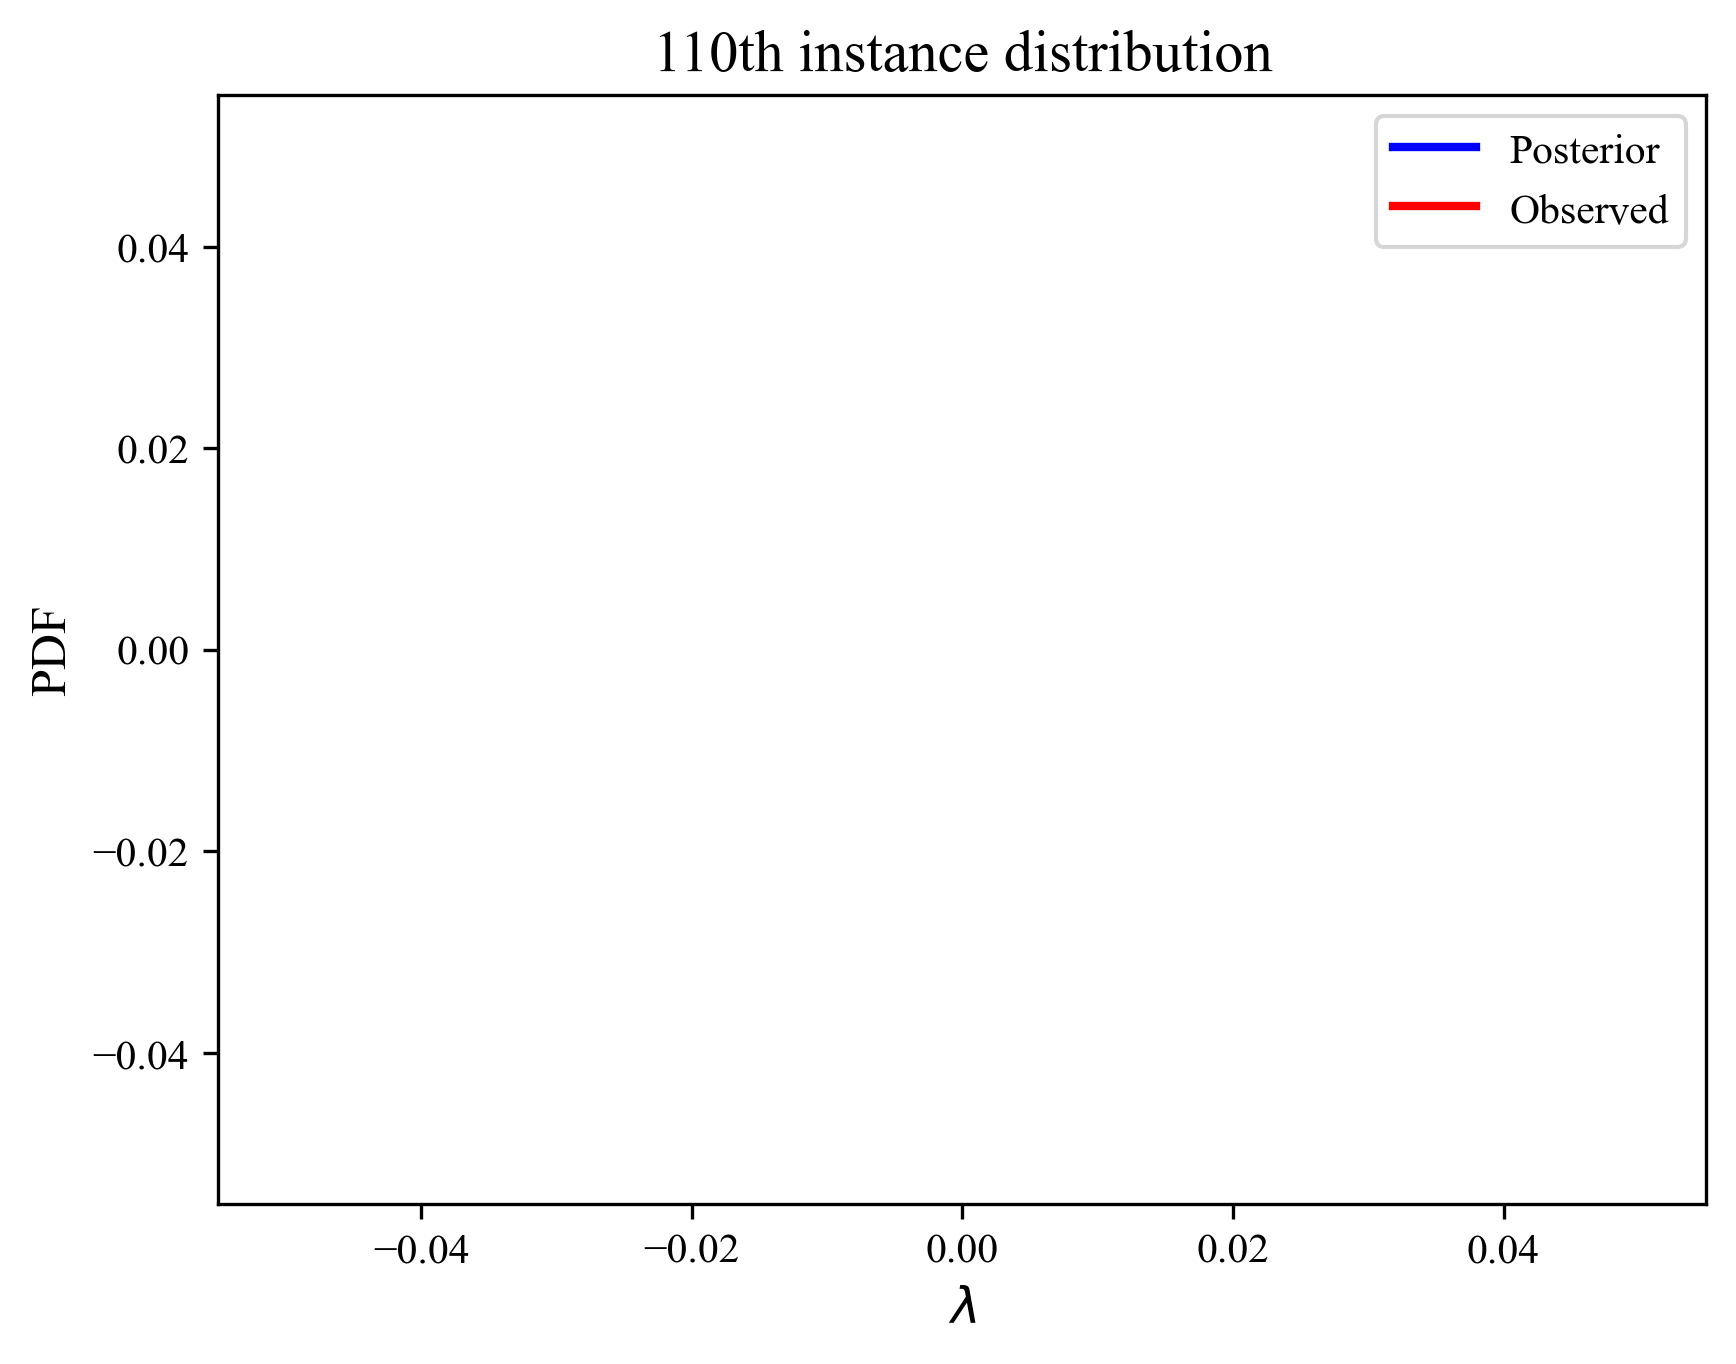

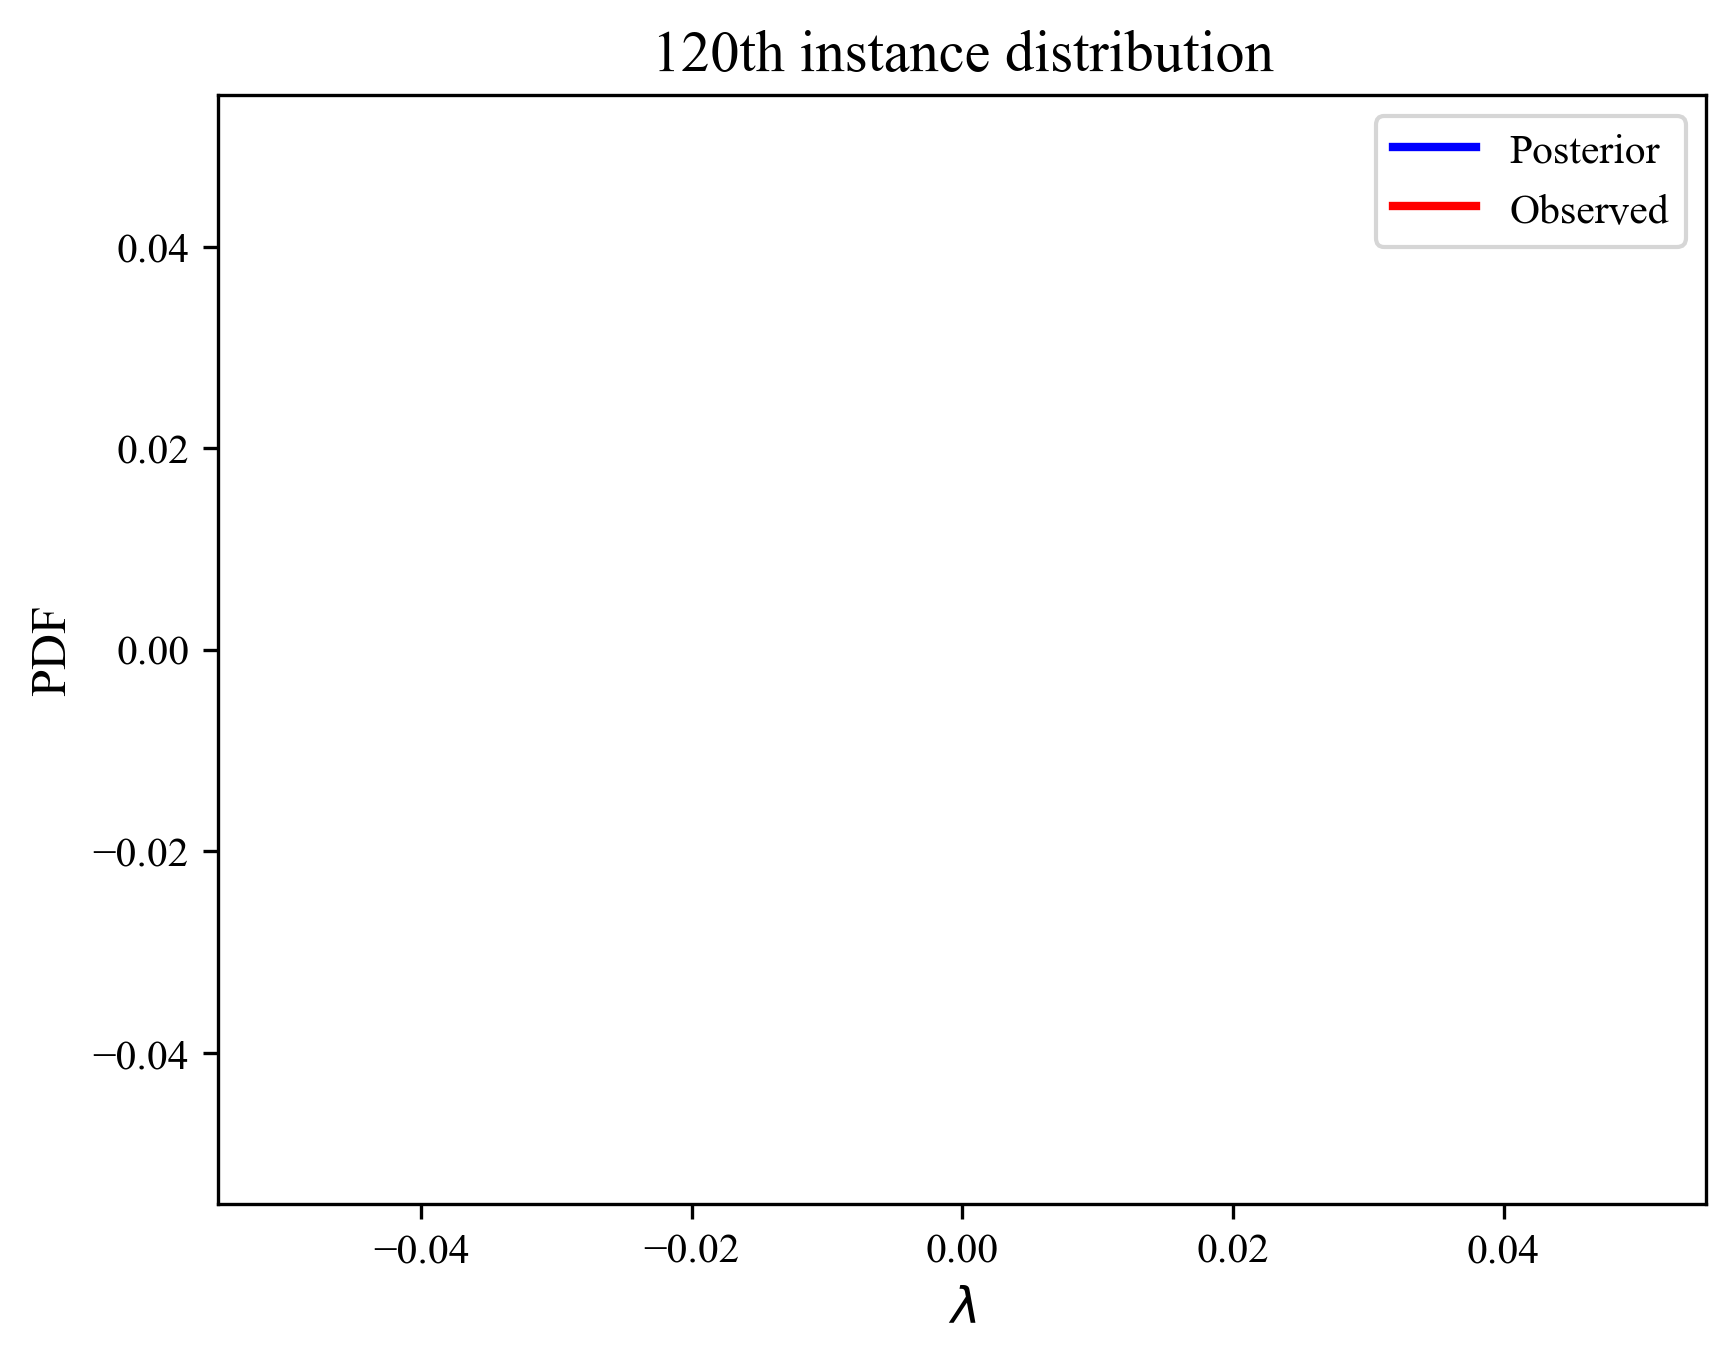

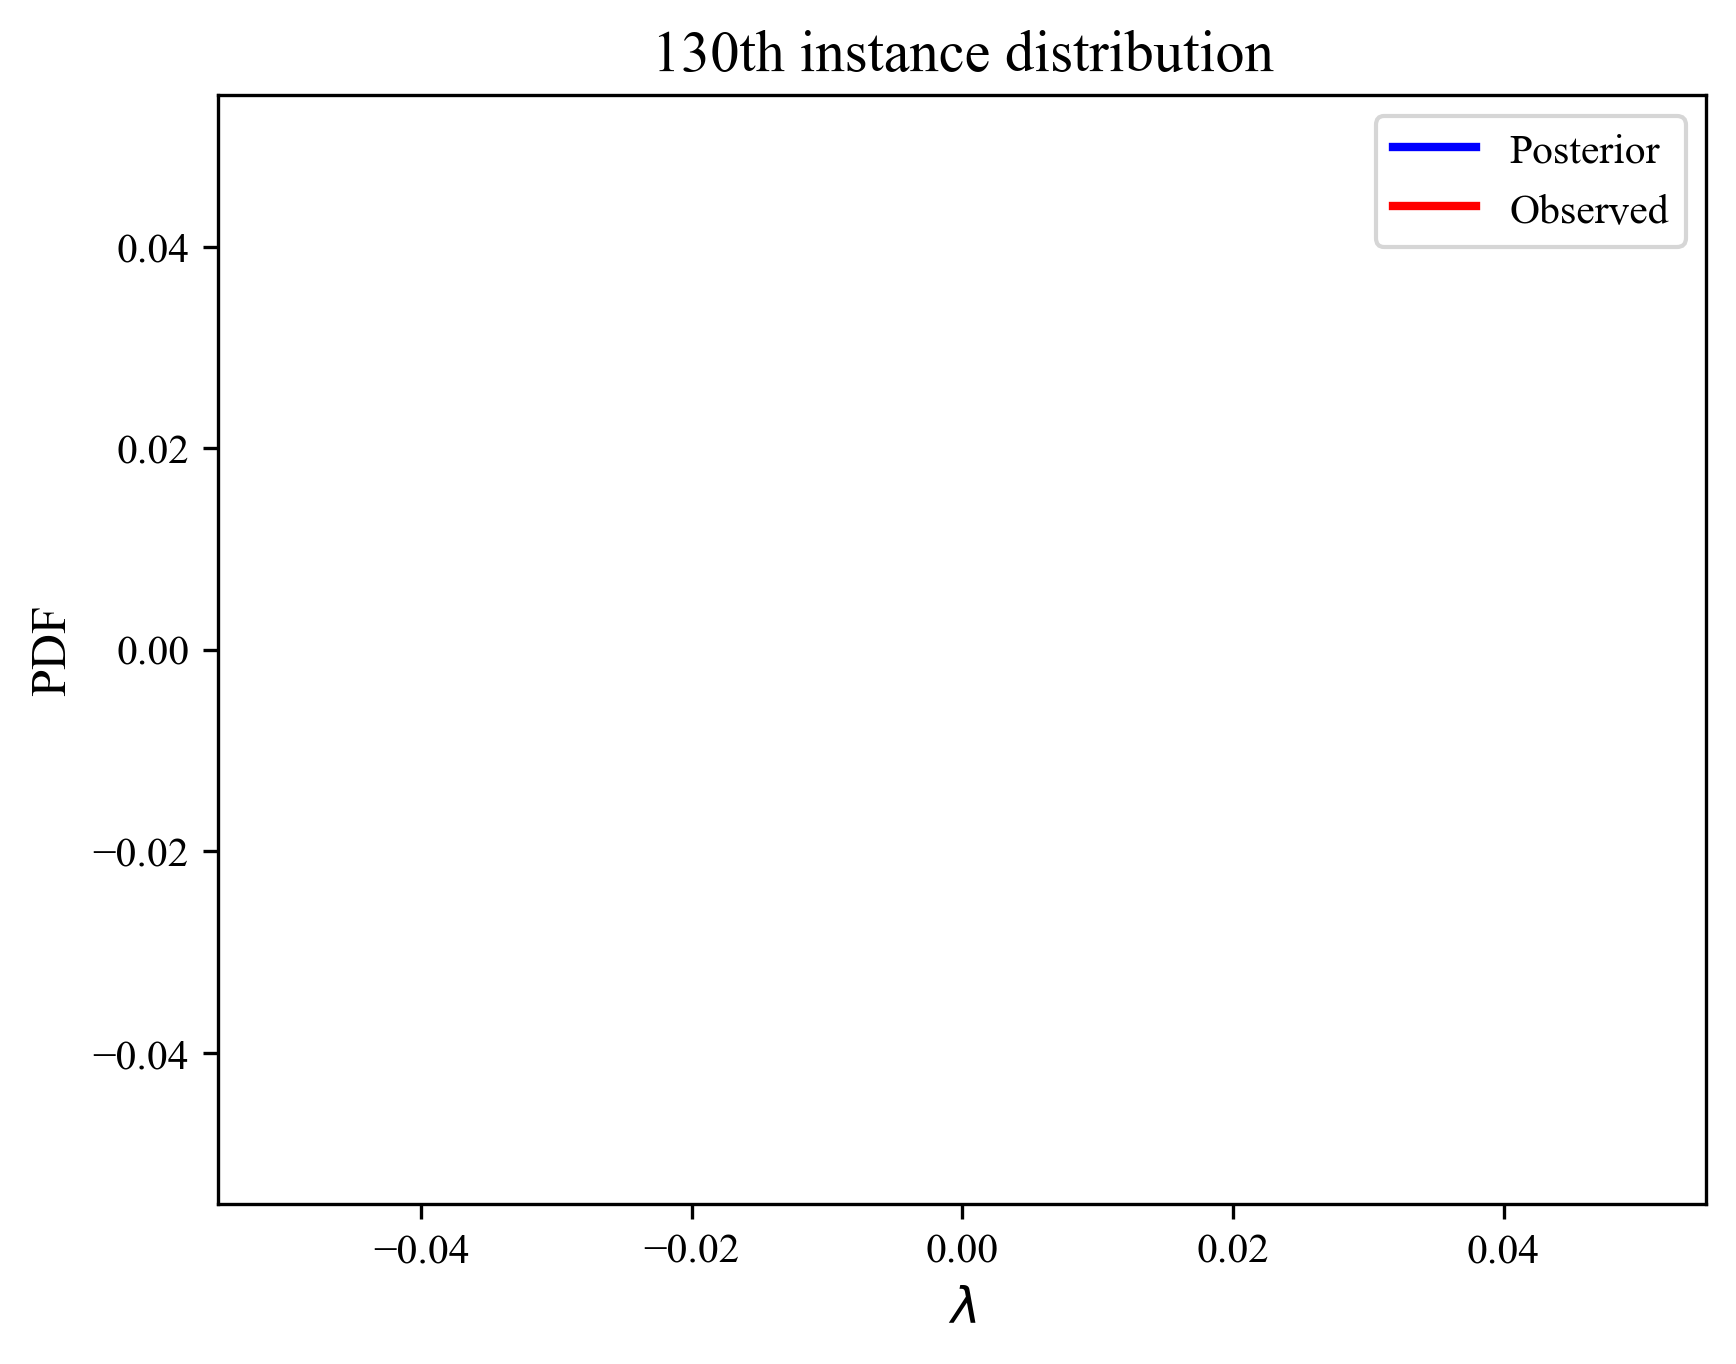

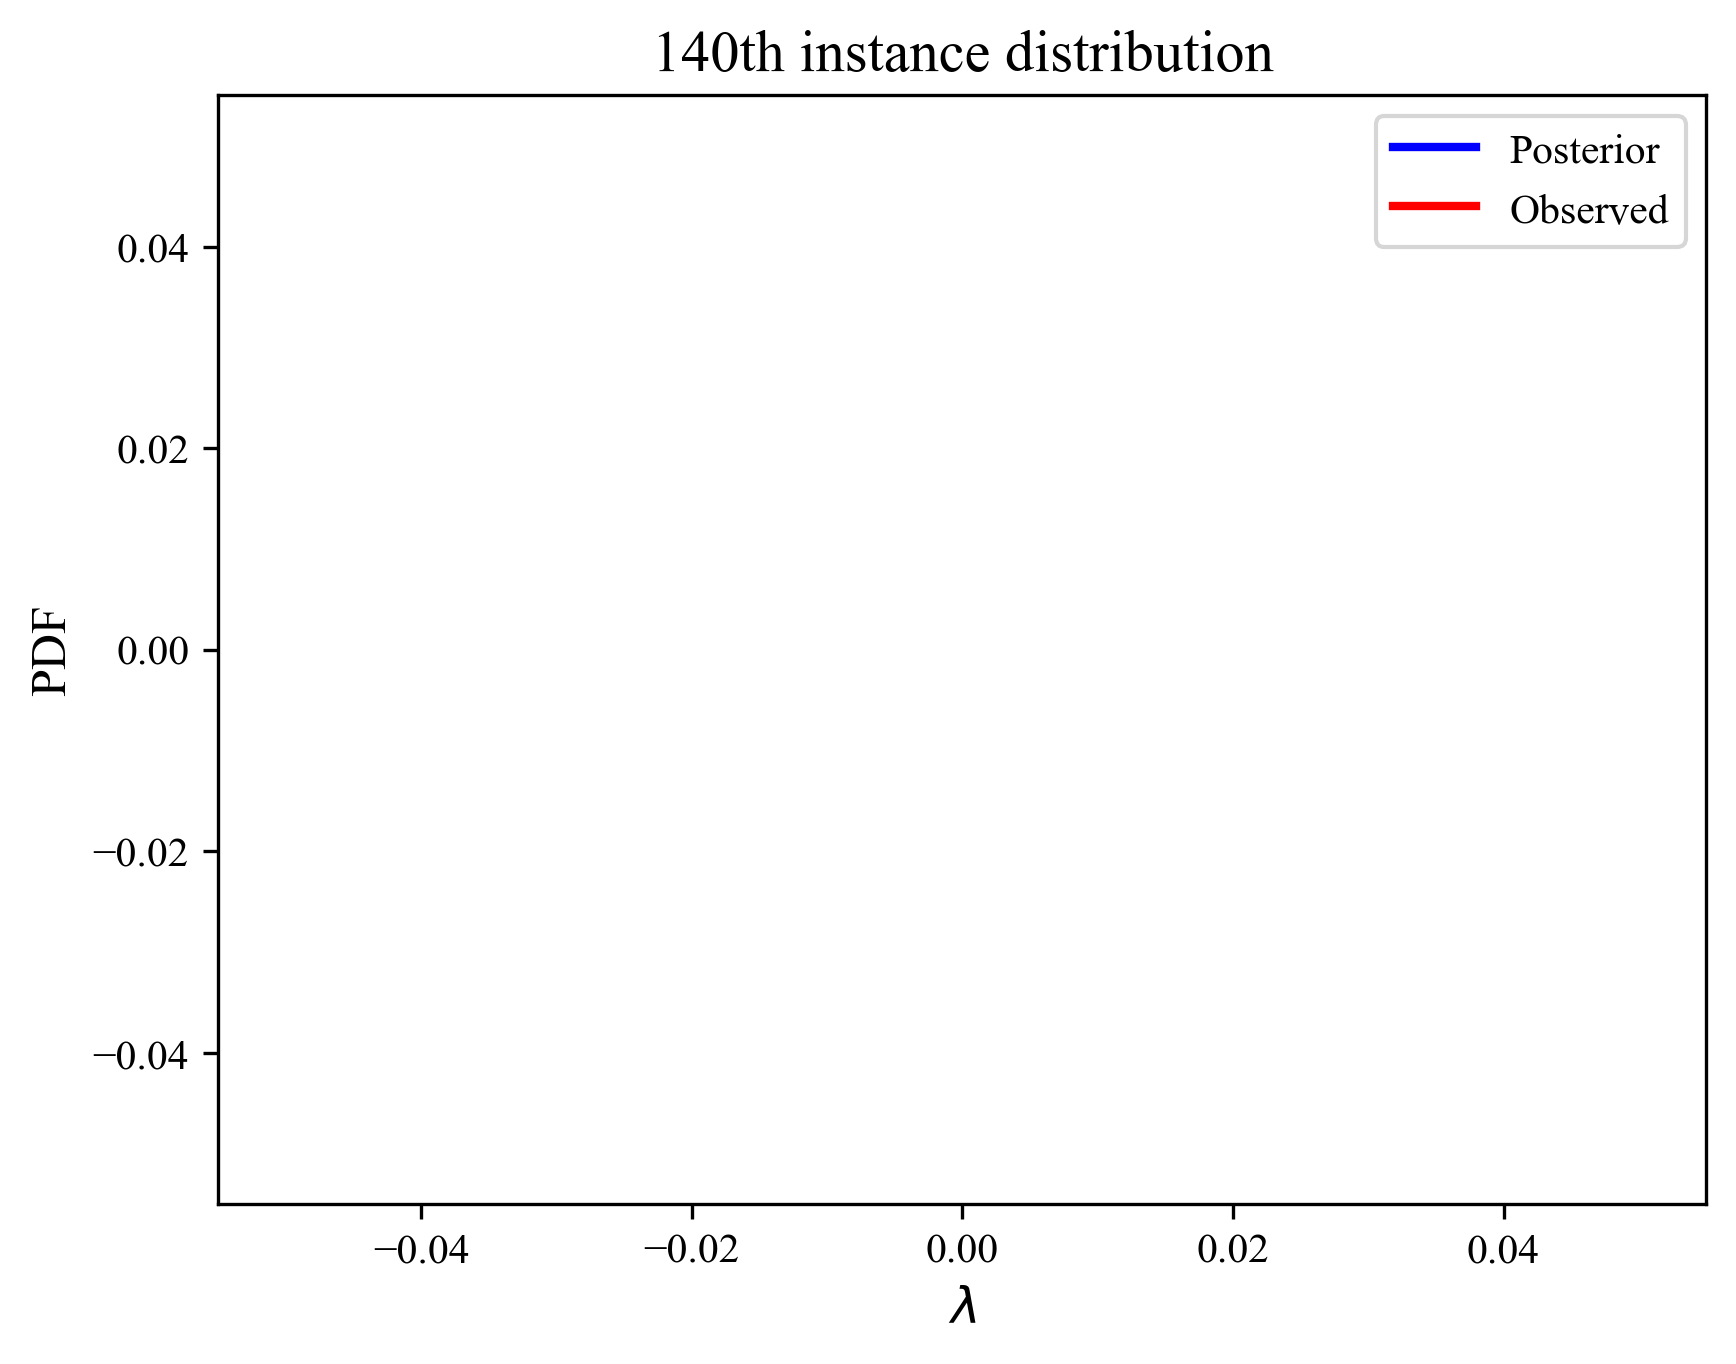

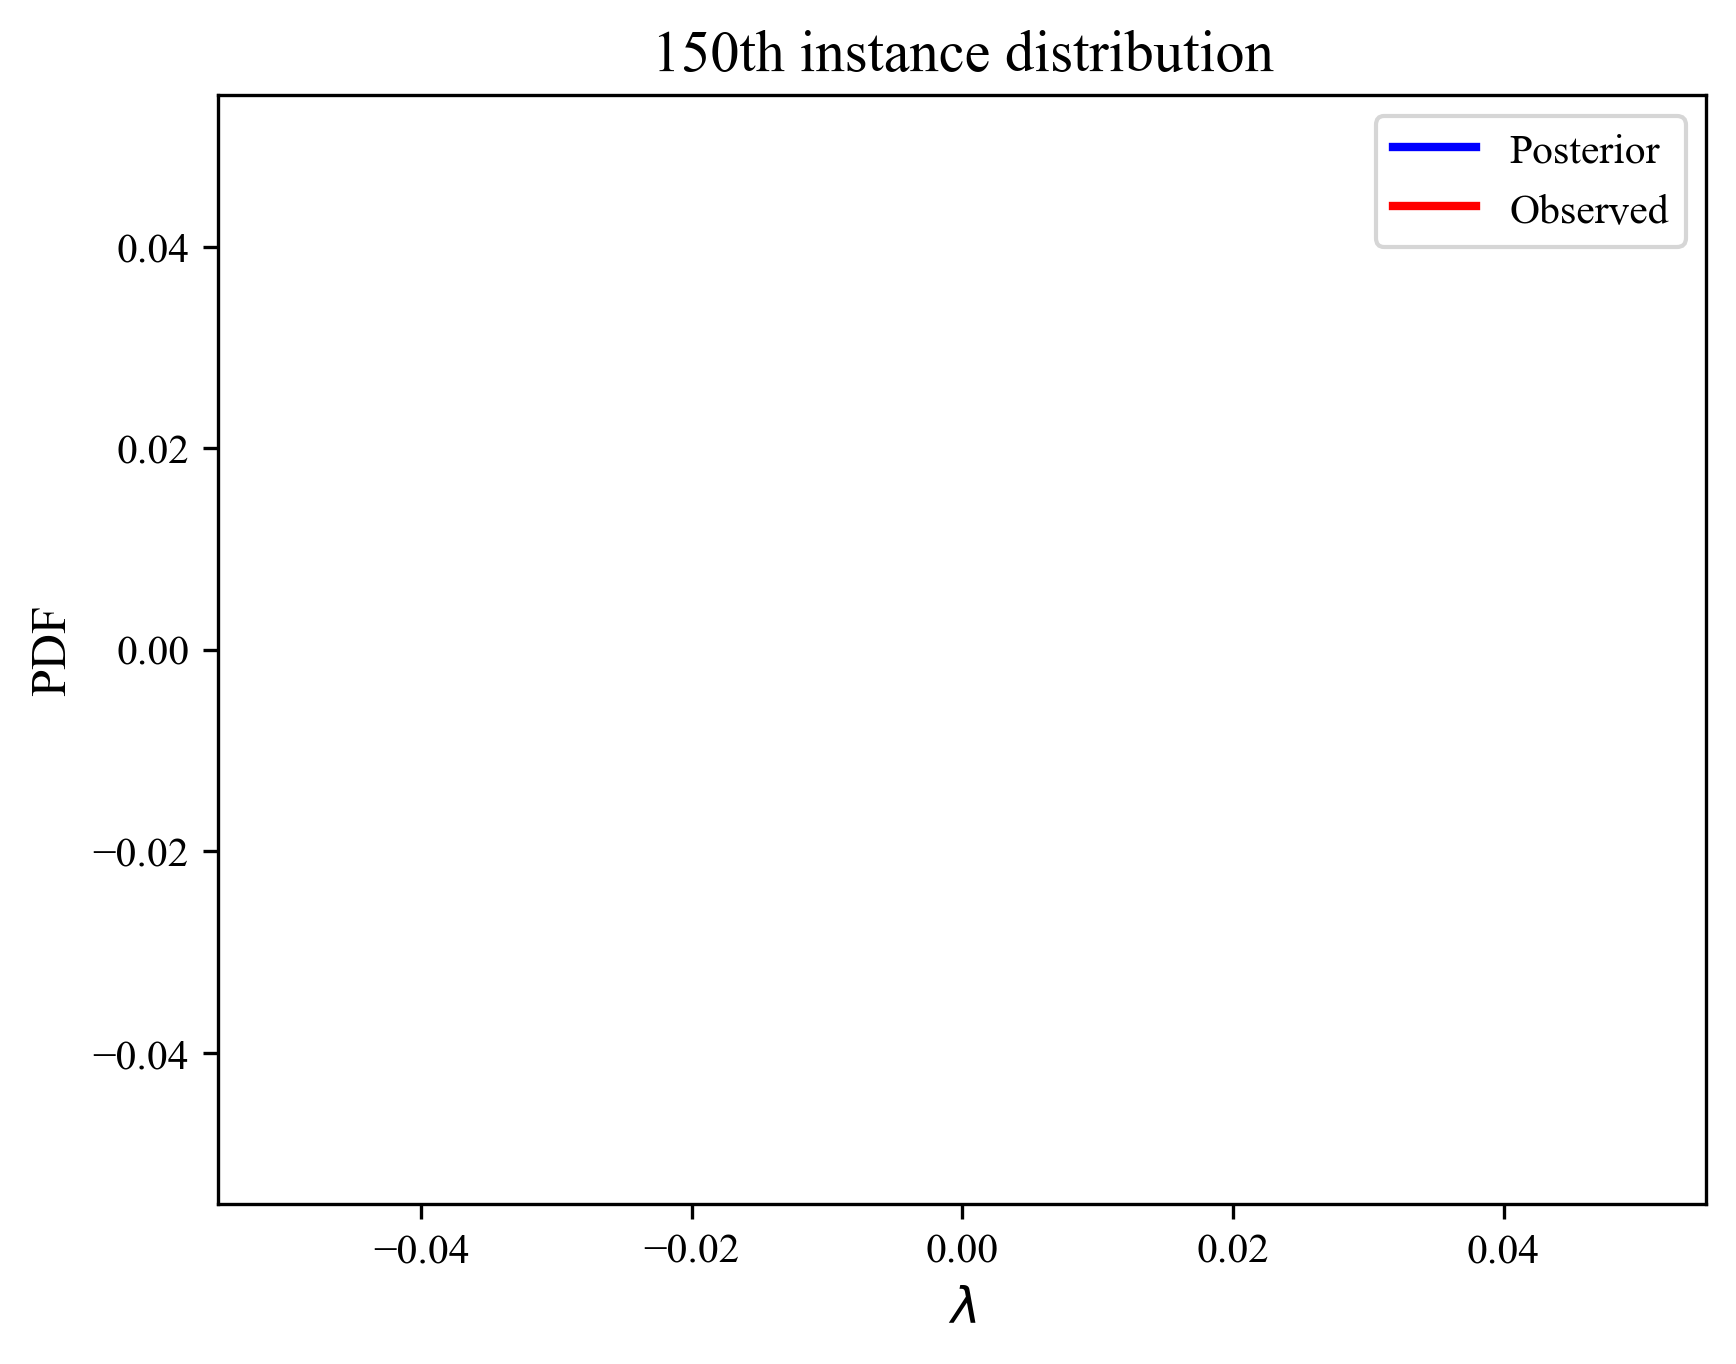

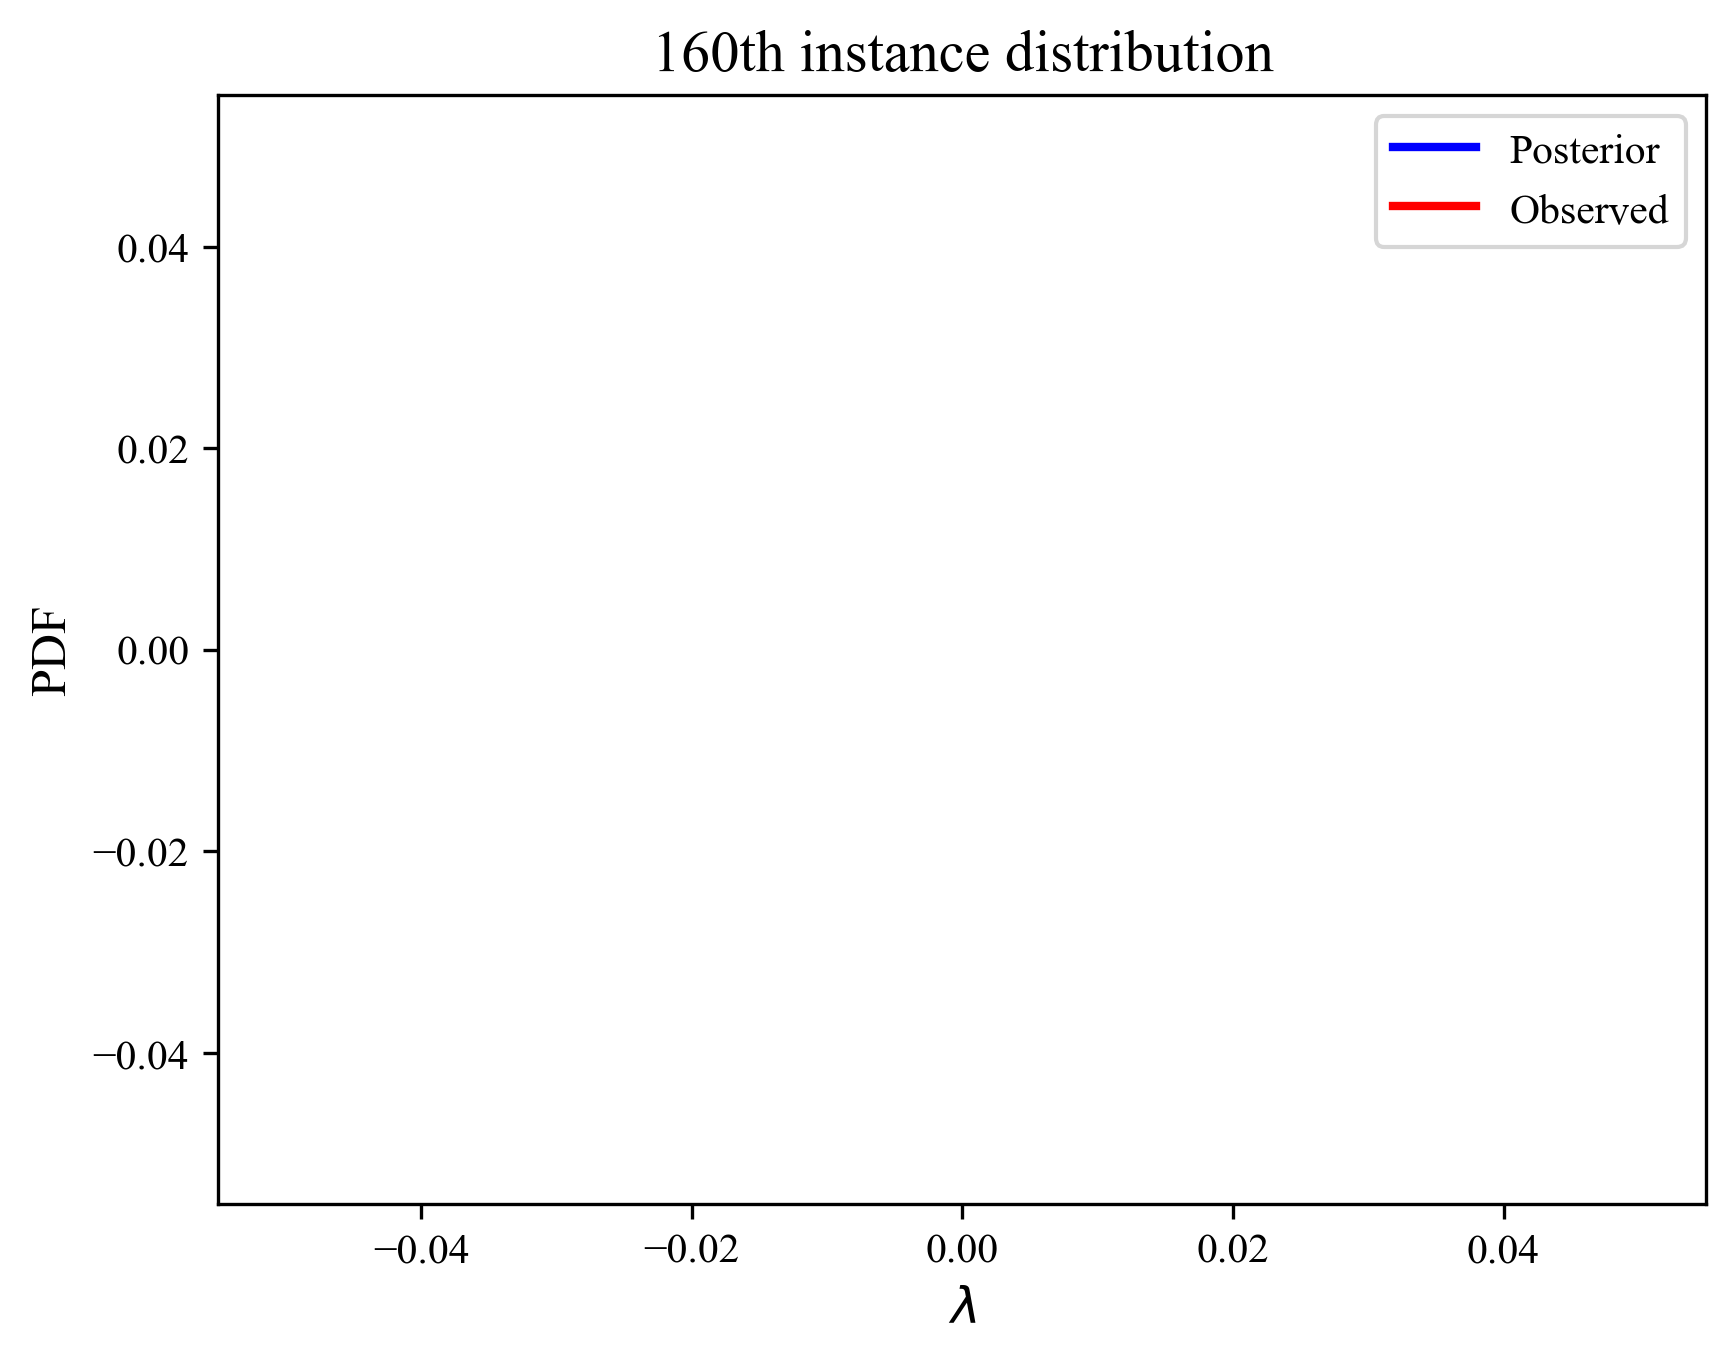

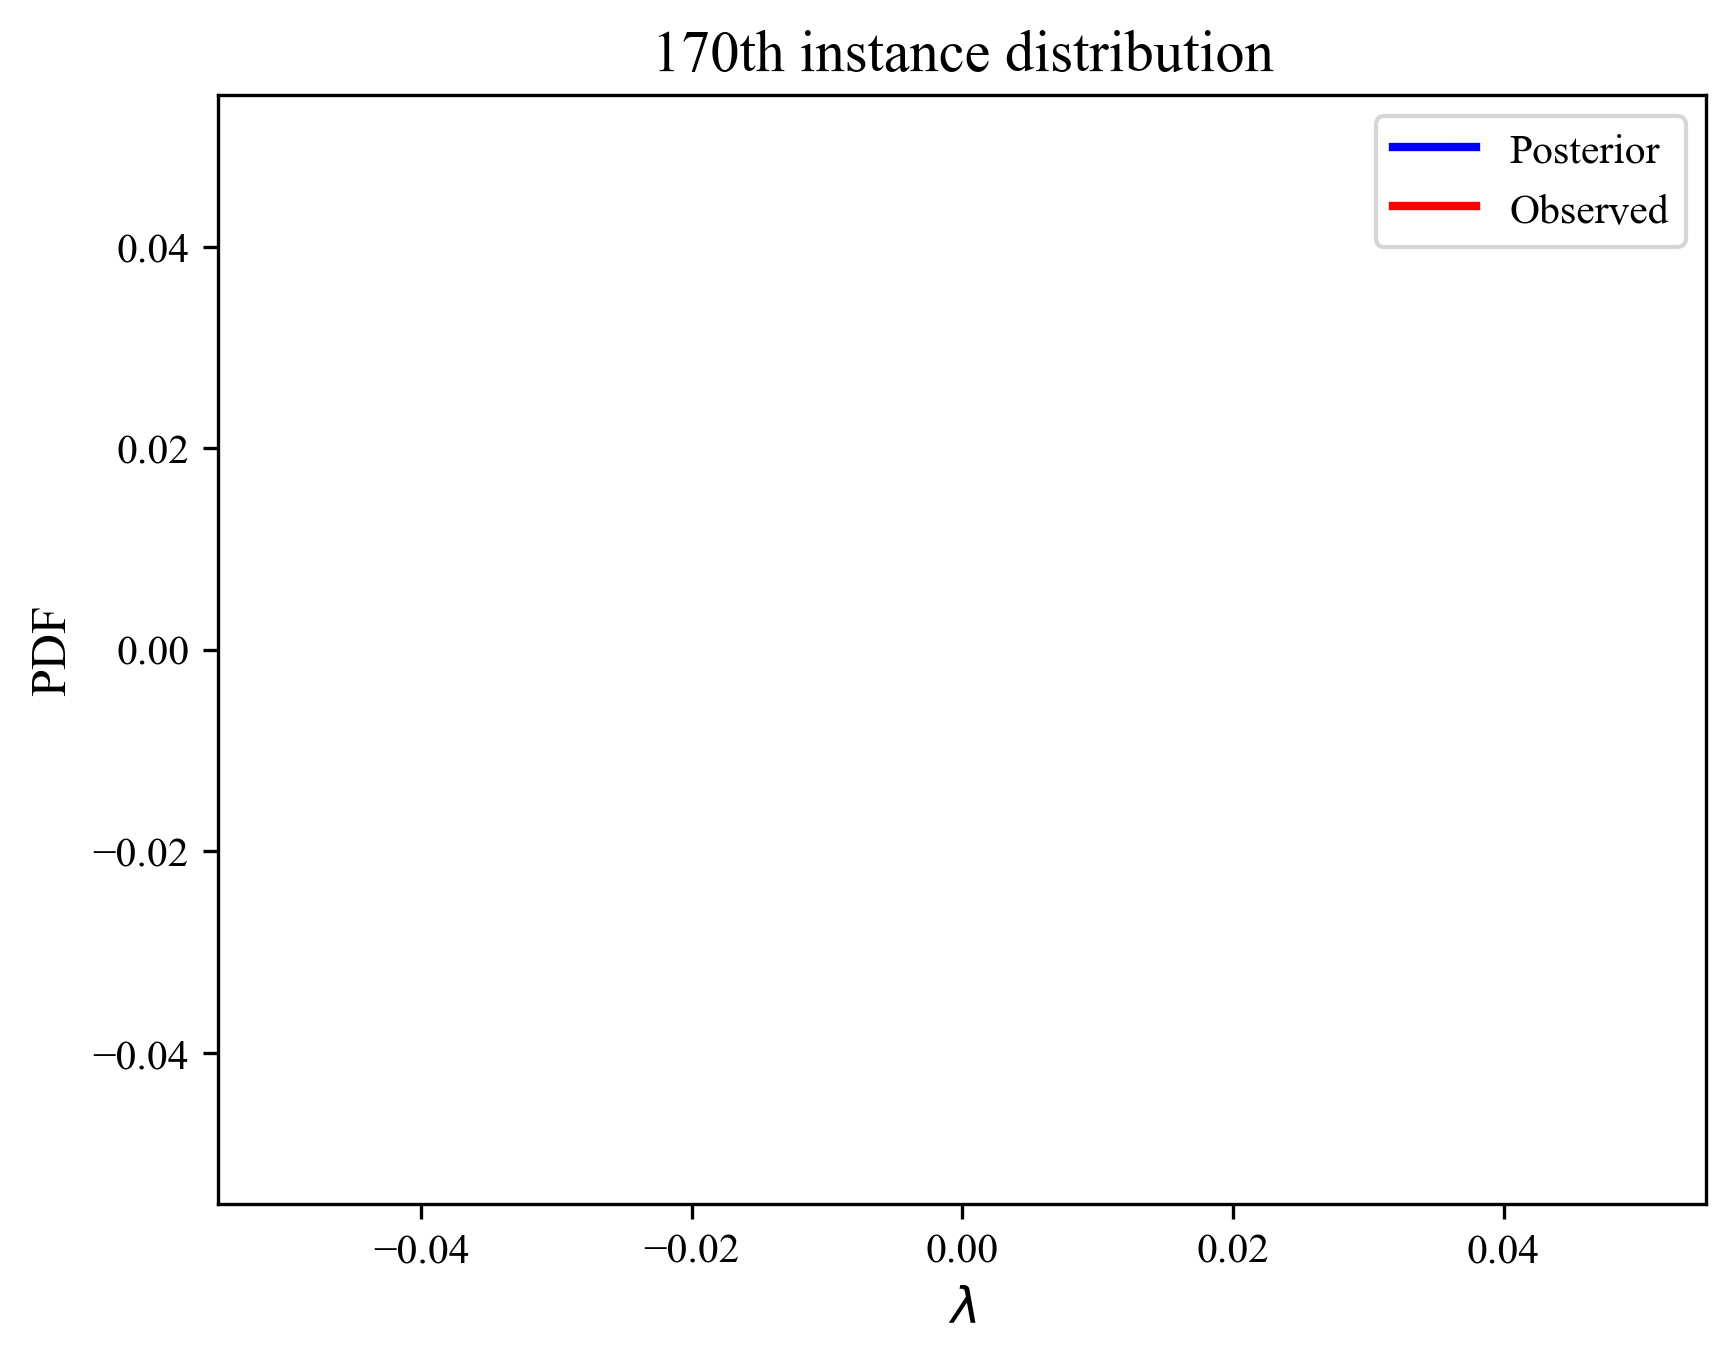

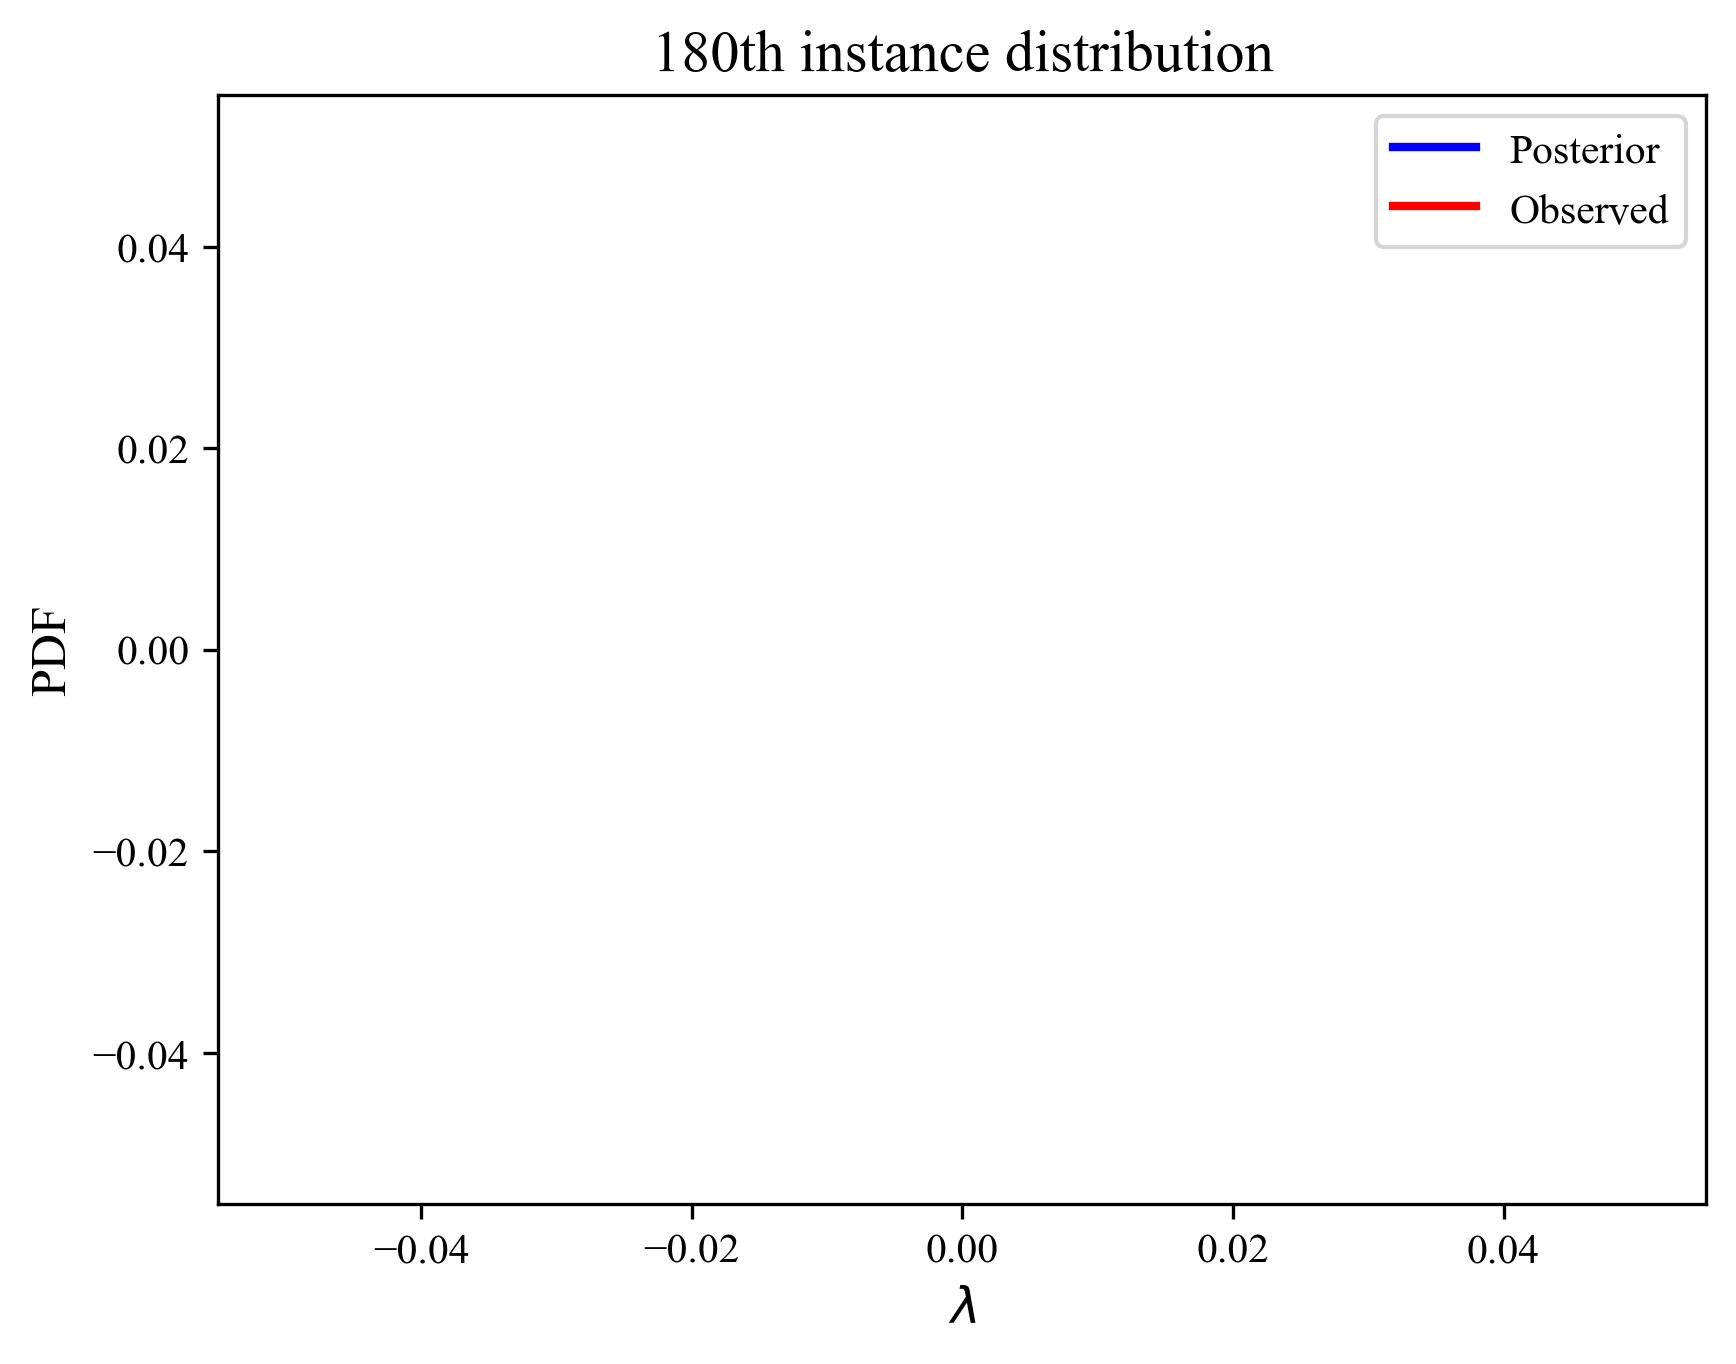

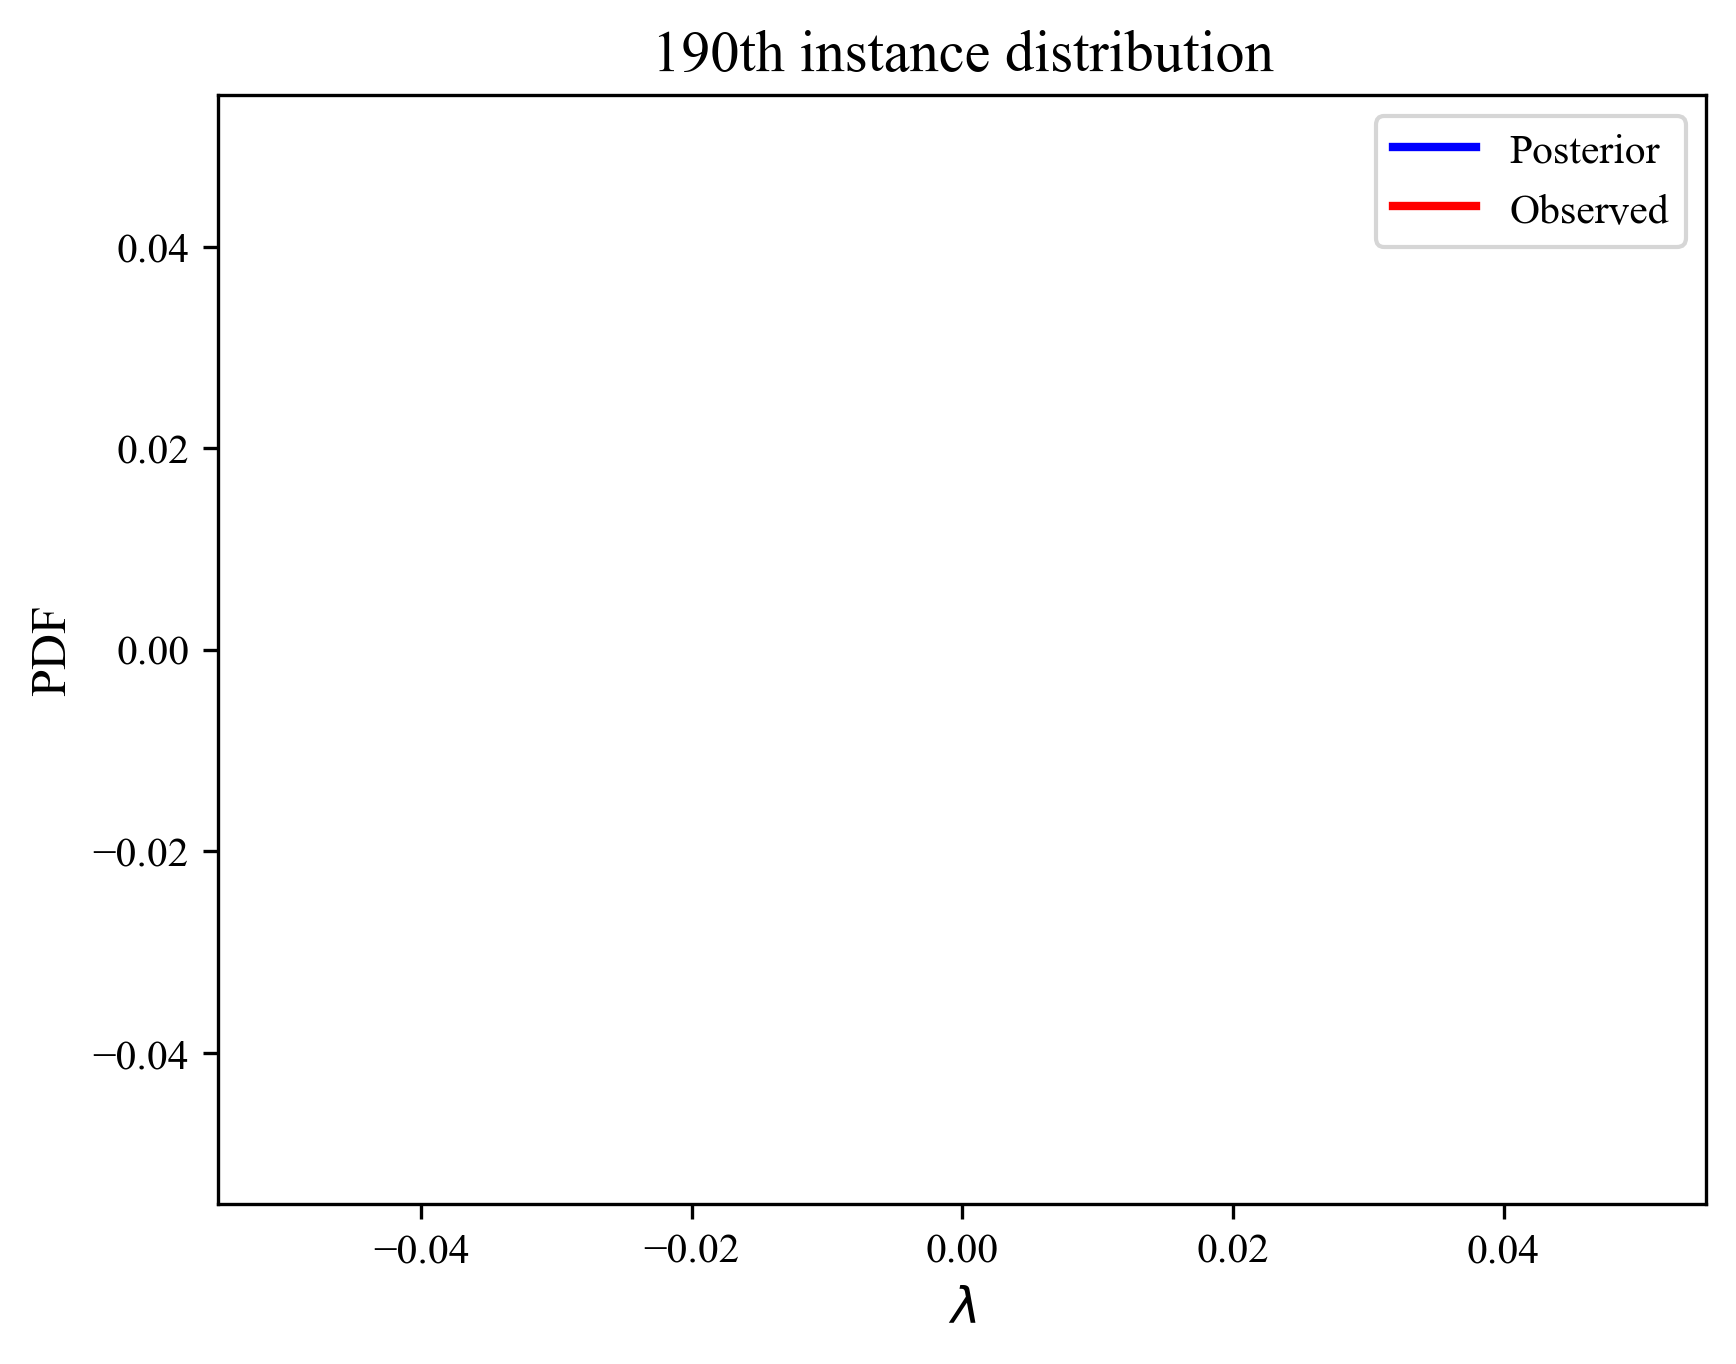

In [61]:
length = min(len(bootstrap_set_x),len(Push_forward_of_Posterior) )
for k in range(10,200,10):
    post_prior = extract_column_k([Push_forward_of_Posterior[:length], bootstrap_set_x[:length]], k=k)
    plot_normal(np.mean(post_prior, axis=0),np.std(post_prior, axis=0), ['Posterior','Observed'], f'{k}th instance distribution')
# plot_multivariate_normal(post_prior, 'Alpha', 'Beta', 'Recovered')